# Demo of the GTM on 10-Dimensional R-Vine-Copula Data

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 10 dimensional R-Vine-Copula as done in our [Paper](https://arxiv.org/pdf/2503.17845) Section 4.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [1]:
from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv
# Helpers to generate specfific vines and analyze there conditional independencies
from pyvinecopulib_simulation_helpers import *

# Other Stuff
import numpy as np
import torch
from torch.utils.data import DataLoader
from dataset_helpers import Generic_Dataset
from sklearn.metrics import roc_auc_score, roc_curve

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
set_seeds(1)

### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a R-Vine-Copula and add Gaussian marginals. To create the Vine we use the functions `sample_random_pair_copulas`and `compute_conditional_dependence_table` from our helpers. Theses allow use to set independence copulas upon Tree 3 to add full conditional independencies as detailed in our Paper. The `df`contains a tables with the copulas, there parameters and there tree positions in a manner comparable to the conditional independence table later generated with the GTM.

In [3]:
D = 7  # dimension
rvine_structure = pv.RVineStructure.simulate(7)
pair_copulas = sample_random_pair_copulas(D,Independence_tree=3)
vine_model = pv.Vinecop.from_structure(structure=rvine_structure, pair_copulas=pair_copulas)
df = compute_conditional_dependence_table(vine_model)
#df

creating a table to compare the true dependence structure later on to what the gtm learned

In [4]:

df_true_structure = df[["tree","edge","conditioned variables", "conditioned variable 1", "conditioned variable 2", "dependence", "var_row", "var_col"]]
df_true_structure_sub = df_true_structure[["var_row", "var_col", "dependence"]]
df_true_structure_sub.loc[:, "var_row"] = df_true_structure_sub["var_row"] - 1
df_true_structure_sub.loc[:, "var_col"] = df_true_structure_sub["var_col"] - 1


The `pyvinecopulib`package offers to plot the tree structures:

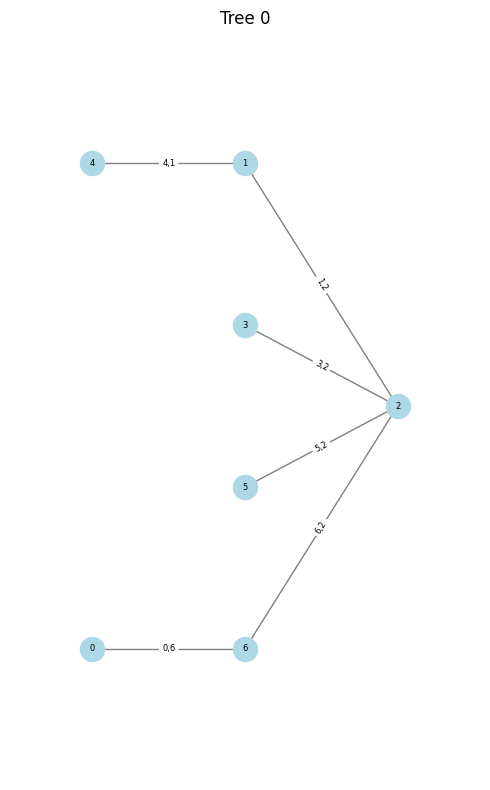

In [5]:
vine_model.plot(tree=[0])

In [6]:
# Train
N_train = 2000
simulated_data_uniform_train = vine_model.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = vine_model.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = vine_model.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [7]:
loglik_copula = np.log(vine_model.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(simulated_data_train).sum(1)
loglik_true_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(vine_model.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(simulated_data_validate).sum(1)
loglik_true_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(vine_model.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(simulated_data_test).sum(1)
loglik_true_test = torch.tensor(loglik_copula) + log_marginals

We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

In [8]:
copula_pv_est = vine_model
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

In [9]:
loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = torch.tensor(loglik_copula) + log_marginals

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [10]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_train)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_validate)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [11]:
model = GTM(
        number_variables = 7,
        number_transformation_layers = 1,
        number_decorrelation_layers= 3,
        degree_transformations = 15,
        degree_decorrelation = 30,
        spline_transformation = "bspline",
        spline_decorrelation = "bspline",
        transformation_spline_range = (-10, 10),
        device = "cpu")

The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

In [12]:
#model.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])

In [13]:
#model.plot_marginals(simulated_data_train)

### 3. Hyperparameter Tune and Train Model

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [14]:
study = model.hyperparameter_tune_penalties( 
        train_dataloader = dataloader_train,
        validate_dataloader = dataloader_validate,
        penalty_decorrelation_ridge_param = None,
        penalty_decorrelation_ridge_first_difference = "sample",
        penalty_decorrelation_ridge_second_difference = "sample",
        penalty_transformation_ridge_second_difference = None,
        penalty_lasso_conditional_independence = None,
        adaptive_lasso_weights_matrix=False,
        optimizer="LBFGS",
        learning_rate=1,
        iterations=2000,
        patience=5,
        min_delta=1e-7,
        seperate_copula_training=False,
        max_batches_per_iter=False,
        pretrained_transformation_layer=True,
        n_trials=30,
        temp_folder=".",
        study_name=None)
        

penalty_splines_params=torch.FloatTensor([
                            0, #study.best_params["penalty_decorrelation_ridge_param"],
                            study.best_params["penalty_decorrelation_ridge_first_difference"],
                            study.best_params["penalty_decorrelation_ridge_second_difference"],
                            0 #study.best_params["penalty_transformation_ridge_second_difference"]
                              ])
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence=False

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-12-09 18:29:12,677] A new study created in RDB with name: no-name-0d685c89-e6a9-4f39-9ced-ba71c68c3b7d
  0%|          | 0/2000 [00:00<?, ?it/s]/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:620: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  x=input_a_clone.T, t=knots.T, c=params_a.T, p=order, d=derivativ
  0%|          | 3/2000 [00:00<02:23, 13.92it/s]

current_loss: tensor(1.4404, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4396, grad_fn=<MeanBackward0>)
current_loss_val:  1.427314043045044
current_loss: tensor(1.4396, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4345, grad_fn=<MeanBackward0>)
current_loss_val:  1.4223655462265015
current_loss: tensor(1.4345, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4264, grad_fn=<MeanBackward0>)
current_loss_val:  1.4118810892105103


  0%|          | 5/2000 [00:00<02:11, 15.21it/s]

current_loss: tensor(1.4264, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4360, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4262, grad_fn=<MeanBackward0>)
current_loss_val:  1.4114141464233398
current_loss: tensor(1.4262, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4262, grad_fn=<MeanBackward0>)
current_loss_val:  1.4113550186157227
current_loss: tensor(1.4262, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4261, grad_fn=<MeanBackward0>)
current_loss_val:  1.4111508131027222
current_loss: tensor(1.4261, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<01:56, 17.05it/s]

current_loss_val:  1.410711646080017
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4392, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss_val:  1.410763144493103
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4258, grad_fn=<MeanBackward0>)
current_loss_val:  1.4106956720352173
current_loss: tensor(1.4258, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, grad_fn=<MeanBackward0>)
current_loss_val:  1.4102402925491333
current_loss: tensor(1.4255, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:00<02:03, 16.09it/s]

current_loss_val:  1.410384178161621
current_loss: tensor(1.4255, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, grad_fn=<MeanBackward0>)
current_loss_val:  1.4102847576141357
current_loss: tensor(1.4253, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, grad_fn=<MeanBackward0>)
current_loss_val:  1.4104504585266113
current_loss: tensor(1.4253, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, grad_fn=<MeanBackward0>)
current_loss_val:  1.41038978099823
current_loss: tensor(1.4252, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, grad_fn=<MeanBackward0>)
current_loss_val:  1.410475254058838
Early Stop at iteration 14 with minimal loss tensor(1.4102) and patience 5 and min_delta 1e-07



  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.4277, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4149, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3257, grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<12:14,  2.72it/s]

current_loss_val:  1.3112680912017822
current_loss: tensor(1.3257, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2126, grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<09:50,  3.38it/s]

current_loss_val:  1.195945143699646
current_loss: tensor(1.2126, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3598, grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<10:26,  3.19it/s]

current_loss: tensor(1.1857, grad_fn=<MeanBackward0>)
current_loss_val:  1.1677088737487793
current_loss: tensor(1.1857, grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:01<09:29,  3.50it/s]

current_loss: tensor(1.1712, grad_fn=<MeanBackward0>)
current_loss_val:  1.1530927419662476
current_loss: tensor(1.1712, grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<08:56,  3.72it/s]

current_loss: tensor(1.1458, grad_fn=<MeanBackward0>)
current_loss_val:  1.1247674226760864
current_loss: tensor(1.1458, grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:01<08:35,  3.87it/s]

current_loss: tensor(1.1414, grad_fn=<MeanBackward0>)
current_loss_val:  1.1160846948623657
current_loss: tensor(1.1414, grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<08:30,  3.91it/s]

current_loss: tensor(1.1302, grad_fn=<MeanBackward0>)
current_loss_val:  1.1062837839126587
current_loss: tensor(1.1302, grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:02<08:25,  3.94it/s]

current_loss: tensor(1.1270, grad_fn=<MeanBackward0>)
current_loss_val:  1.1038892269134521
current_loss: tensor(1.1270, grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:02<08:20,  3.98it/s]

current_loss: tensor(1.1204, grad_fn=<MeanBackward0>)
current_loss_val:  1.0990599393844604
current_loss: tensor(1.1204, grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:02<08:15,  4.01it/s]

current_loss: tensor(1.1070, grad_fn=<MeanBackward0>)
current_loss_val:  1.088146448135376
current_loss: tensor(1.1070, grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:02<09:04,  3.65it/s]

current_loss: tensor(1.1137, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1015, grad_fn=<MeanBackward0>)
current_loss_val:  1.0840109586715698


  1%|          | 12/2000 [00:03<08:47,  3.77it/s]

current_loss: tensor(1.1015, grad_fn=<MeanBackward0>)
current_loss: tensor(1.0968, grad_fn=<MeanBackward0>)
current_loss_val:  1.0799028873443604


  1%|          | 13/2000 [00:03<08:33,  3.87it/s]

current_loss: tensor(1.0968, grad_fn=<MeanBackward0>)
current_loss: tensor(1.0904, grad_fn=<MeanBackward0>)
current_loss_val:  1.0745582580566406
current_loss: tensor(1.0904, grad_fn=<MeanBackward0>)
current_loss: tensor(1.0898, grad_fn=<MeanBackward0>)
current_loss: tensor(1.0849, grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:03<09:32,  3.47it/s]

current_loss_val:  1.0699527263641357
current_loss: tensor(1.0849, grad_fn=<MeanBackward0>)
current_loss: tensor(1.0815, grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:04<09:03,  3.65it/s]

current_loss_val:  1.0664945840835571
current_loss: tensor(1.0815, grad_fn=<MeanBackward0>)
current_loss: tensor(1.0790, grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:04<08:49,  3.75it/s]

current_loss_val:  1.0641528367996216
current_loss: tensor(1.0790, grad_fn=<MeanBackward0>)
current_loss: tensor(1.0784, grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:04<09:56,  3.32it/s]

current_loss: tensor(1.0710, grad_fn=<MeanBackward0>)
current_loss_val:  1.0561542510986328
current_loss: tensor(1.0710, grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:04<09:25,  3.50it/s]

current_loss: tensor(1.0609, grad_fn=<MeanBackward0>)
current_loss_val:  1.044034719467163
current_loss: tensor(1.0609, grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:05<09:39,  3.42it/s]

current_loss: tensor(1.0517, grad_fn=<MeanBackward0>)
current_loss_val:  1.029679775238037
current_loss: tensor(1.0517, grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:05<09:09,  3.61it/s]

current_loss: tensor(1.0486, grad_fn=<MeanBackward0>)
current_loss_val:  1.0229167938232422
current_loss: tensor(1.0486, grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:05<09:16,  3.56it/s]

current_loss: tensor(1.0427, grad_fn=<MeanBackward0>)
current_loss_val:  1.01632821559906
current_loss: tensor(1.0427, grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:06<08:54,  3.70it/s]

current_loss: tensor(1.0408, grad_fn=<MeanBackward0>)
current_loss_val:  1.0144497156143188
current_loss: tensor(1.0408, grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:06<08:35,  3.84it/s]

current_loss: tensor(1.0335, grad_fn=<MeanBackward0>)
current_loss_val:  1.0071077346801758
current_loss: tensor(1.0335, grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:06<09:24,  3.50it/s]

current_loss: tensor(1.0593, grad_fn=<MeanBackward0>)
current_loss: tensor(1.0289, grad_fn=<MeanBackward0>)
current_loss_val:  1.002920389175415


  1%|▏         | 25/2000 [00:06<09:02,  3.64it/s]

current_loss: tensor(1.0289, grad_fn=<MeanBackward0>)
current_loss: tensor(1.0265, grad_fn=<MeanBackward0>)
current_loss_val:  1.000523328781128


  1%|▏         | 26/2000 [00:07<08:47,  3.74it/s]

current_loss: tensor(1.0265, grad_fn=<MeanBackward0>)
current_loss: tensor(1.0197, grad_fn=<MeanBackward0>)
current_loss_val:  0.9940090179443359
current_loss: tensor(1.0197, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2935, grad_fn=<MeanBackward0>)
current_loss: tensor(1.0185, grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:07<09:38,  3.41it/s]

current_loss_val:  0.9928698539733887
current_loss: tensor(1.0185, grad_fn=<MeanBackward0>)
current_loss: tensor(1.0176, grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:07<10:03,  3.27it/s]

current_loss: tensor(1.0133, grad_fn=<MeanBackward0>)
current_loss_val:  0.9903661608695984
current_loss: tensor(1.0133, grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:08<10:16,  3.20it/s]

current_loss: tensor(1.0230, grad_fn=<MeanBackward0>)
current_loss: tensor(1.0127, grad_fn=<MeanBackward0>)
current_loss_val:  0.990343451499939


  2%|▏         | 30/2000 [00:08<09:38,  3.41it/s]

current_loss: tensor(1.0127, grad_fn=<MeanBackward0>)
current_loss: tensor(1.0121, grad_fn=<MeanBackward0>)
current_loss_val:  0.9900048971176147


  2%|▏         | 31/2000 [00:08<09:08,  3.59it/s]

current_loss: tensor(1.0121, grad_fn=<MeanBackward0>)
current_loss: tensor(1.0093, grad_fn=<MeanBackward0>)
current_loss_val:  0.9882637858390808


  2%|▏         | 32/2000 [00:08<08:52,  3.70it/s]

current_loss: tensor(1.0093, grad_fn=<MeanBackward0>)
current_loss: tensor(1.0081, grad_fn=<MeanBackward0>)
current_loss_val:  0.9873494505882263


  2%|▏         | 33/2000 [00:09<08:35,  3.82it/s]

current_loss: tensor(1.0081, grad_fn=<MeanBackward0>)
current_loss: tensor(1.0071, grad_fn=<MeanBackward0>)
current_loss_val:  0.9857119917869568


  2%|▏         | 34/2000 [00:09<08:24,  3.90it/s]

current_loss: tensor(1.0071, grad_fn=<MeanBackward0>)
current_loss: tensor(1.0067, grad_fn=<MeanBackward0>)
current_loss_val:  0.9854653477668762


  2%|▏         | 35/2000 [00:09<08:14,  3.97it/s]

current_loss: tensor(1.0067, grad_fn=<MeanBackward0>)
current_loss: tensor(1.0049, grad_fn=<MeanBackward0>)
current_loss_val:  0.9847748875617981


  2%|▏         | 36/2000 [00:09<08:12,  3.99it/s]

current_loss: tensor(1.0049, grad_fn=<MeanBackward0>)
current_loss: tensor(1.0044, grad_fn=<MeanBackward0>)
current_loss_val:  0.9848326444625854


  2%|▏         | 37/2000 [00:10<08:12,  3.99it/s]

current_loss: tensor(1.0044, grad_fn=<MeanBackward0>)
current_loss: tensor(1.0036, grad_fn=<MeanBackward0>)
current_loss_val:  0.9842665791511536


  2%|▏         | 38/2000 [00:10<08:10,  4.00it/s]

current_loss: tensor(1.0036, grad_fn=<MeanBackward0>)
current_loss: tensor(1.0033, grad_fn=<MeanBackward0>)
current_loss_val:  0.9840983748435974


  2%|▏         | 39/2000 [00:10<08:07,  4.03it/s]

current_loss: tensor(1.0033, grad_fn=<MeanBackward0>)
current_loss: tensor(1.0029, grad_fn=<MeanBackward0>)
current_loss_val:  0.9837000370025635


  2%|▏         | 40/2000 [00:10<08:00,  4.08it/s]

current_loss: tensor(1.0029, grad_fn=<MeanBackward0>)
current_loss: tensor(1.0026, grad_fn=<MeanBackward0>)
current_loss_val:  0.9833498001098633


  2%|▏         | 41/2000 [00:11<07:58,  4.09it/s]

current_loss: tensor(1.0026, grad_fn=<MeanBackward0>)
current_loss: tensor(1.0024, grad_fn=<MeanBackward0>)
current_loss_val:  0.9829282760620117


  2%|▏         | 42/2000 [00:11<08:00,  4.08it/s]

current_loss: tensor(1.0024, grad_fn=<MeanBackward0>)
current_loss: tensor(1.0019, grad_fn=<MeanBackward0>)
current_loss_val:  0.9826793670654297


  2%|▏         | 43/2000 [00:11<08:00,  4.07it/s]

current_loss: tensor(1.0019, grad_fn=<MeanBackward0>)
current_loss: tensor(1.0017, grad_fn=<MeanBackward0>)
current_loss_val:  0.9826488494873047


  2%|▏         | 44/2000 [00:11<07:54,  4.12it/s]

current_loss: tensor(1.0017, grad_fn=<MeanBackward0>)
current_loss: tensor(1.0012, grad_fn=<MeanBackward0>)
current_loss_val:  0.9825115203857422


  2%|▏         | 45/2000 [00:12<07:55,  4.11it/s]

current_loss: tensor(1.0012, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9998, grad_fn=<MeanBackward0>)
current_loss_val:  0.9814997911453247


  2%|▏         | 46/2000 [00:12<07:59,  4.07it/s]

current_loss: tensor(0.9998, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9992, grad_fn=<MeanBackward0>)
current_loss_val:  0.9808796048164368


  2%|▏         | 47/2000 [00:12<08:00,  4.07it/s]

current_loss: tensor(0.9992, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9987, grad_fn=<MeanBackward0>)
current_loss_val:  0.9801943302154541


  2%|▏         | 48/2000 [00:12<08:00,  4.06it/s]

current_loss: tensor(0.9987, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9978, grad_fn=<MeanBackward0>)
current_loss_val:  0.9786463975906372


  2%|▏         | 49/2000 [00:13<08:01,  4.05it/s]

current_loss: tensor(0.9978, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9966, grad_fn=<MeanBackward0>)
current_loss_val:  0.9776728749275208


  2%|▎         | 50/2000 [00:13<07:57,  4.08it/s]

current_loss: tensor(0.9966, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9955, grad_fn=<MeanBackward0>)
current_loss_val:  0.9771663546562195


  3%|▎         | 51/2000 [00:13<08:03,  4.03it/s]

current_loss: tensor(0.9955, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9948, grad_fn=<MeanBackward0>)
current_loss_val:  0.9767734408378601
current_loss: tensor(0.9948, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9951, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9930, grad_fn=<MeanBackward0>)


  3%|▎         | 52/2000 [00:13<08:50,  3.67it/s]

current_loss_val:  0.9754160046577454
current_loss: tensor(0.9930, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9919, grad_fn=<MeanBackward0>)


  3%|▎         | 53/2000 [00:14<08:31,  3.81it/s]

current_loss_val:  0.9746459126472473
current_loss: tensor(0.9919, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9902, grad_fn=<MeanBackward0>)


  3%|▎         | 54/2000 [00:14<08:25,  3.85it/s]

current_loss_val:  0.9727741479873657
current_loss: tensor(0.9902, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9889, grad_fn=<MeanBackward0>)


  3%|▎         | 55/2000 [00:14<08:17,  3.91it/s]

current_loss_val:  0.9699773192405701
current_loss: tensor(0.9889, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9878, grad_fn=<MeanBackward0>)


  3%|▎         | 56/2000 [00:14<08:11,  3.95it/s]

current_loss_val:  0.969201922416687
current_loss: tensor(0.9878, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9872, grad_fn=<MeanBackward0>)


  3%|▎         | 57/2000 [00:15<08:03,  4.01it/s]

current_loss_val:  0.968687891960144
current_loss: tensor(0.9872, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9867, grad_fn=<MeanBackward0>)


  3%|▎         | 58/2000 [00:15<07:58,  4.06it/s]

current_loss_val:  0.968540370464325
current_loss: tensor(0.9867, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9862, grad_fn=<MeanBackward0>)


  3%|▎         | 59/2000 [00:15<07:53,  4.10it/s]

current_loss_val:  0.9688438177108765
current_loss: tensor(0.9862, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9858, grad_fn=<MeanBackward0>)


  3%|▎         | 60/2000 [00:15<07:50,  4.13it/s]

current_loss_val:  0.9687535762786865
current_loss: tensor(0.9858, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9849, grad_fn=<MeanBackward0>)


  3%|▎         | 61/2000 [00:16<07:51,  4.12it/s]

current_loss_val:  0.9686634540557861
current_loss: tensor(0.9849, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9851, grad_fn=<MeanBackward0>)


  3%|▎         | 62/2000 [00:16<08:49,  3.66it/s]

current_loss: tensor(0.9845, grad_fn=<MeanBackward0>)
current_loss_val:  0.9679484963417053
current_loss: tensor(0.9845, grad_fn=<MeanBackward0>)


  3%|▎         | 63/2000 [00:16<08:33,  3.77it/s]

current_loss: tensor(0.9845, grad_fn=<MeanBackward0>)
current_loss_val:  0.9680927991867065
current_loss: tensor(0.9845, grad_fn=<MeanBackward0>)


  3%|▎         | 64/2000 [00:16<08:17,  3.89it/s]

current_loss: tensor(0.9843, grad_fn=<MeanBackward0>)
current_loss_val:  0.9678774476051331
current_loss: tensor(0.9843, grad_fn=<MeanBackward0>)


  3%|▎         | 65/2000 [00:17<08:06,  3.98it/s]

current_loss: tensor(0.9842, grad_fn=<MeanBackward0>)
current_loss_val:  0.9678378701210022
current_loss: tensor(0.9842, grad_fn=<MeanBackward0>)


  3%|▎         | 66/2000 [00:17<08:06,  3.98it/s]

current_loss: tensor(0.9842, grad_fn=<MeanBackward0>)
current_loss_val:  0.9678649306297302
current_loss: tensor(0.9842, grad_fn=<MeanBackward0>)


  3%|▎         | 67/2000 [00:17<08:50,  3.65it/s]

current_loss: tensor(0.9840, grad_fn=<MeanBackward0>)
current_loss_val:  0.9680160284042358
current_loss: tensor(0.9840, grad_fn=<MeanBackward0>)


  3%|▎         | 68/2000 [00:18<15:14,  2.11it/s]

current_loss: tensor(0.9838, grad_fn=<MeanBackward0>)
current_loss_val:  0.9679319262504578
current_loss: tensor(0.9838, grad_fn=<MeanBackward0>)


  3%|▎         | 69/2000 [00:18<13:03,  2.47it/s]

current_loss: tensor(0.9831, grad_fn=<MeanBackward0>)
current_loss_val:  0.9674525856971741
current_loss: tensor(0.9831, grad_fn=<MeanBackward0>)


  4%|▎         | 70/2000 [00:19<12:21,  2.60it/s]

current_loss: tensor(0.9833, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9820, grad_fn=<MeanBackward0>)
current_loss_val:  0.9657986164093018
current_loss: tensor(0.9820, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9821, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9817, grad_fn=<MeanBackward0>)


  4%|▎         | 71/2000 [00:19<11:53,  2.70it/s]

current_loss_val:  0.9651203751564026
current_loss: tensor(0.9817, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9815, grad_fn=<MeanBackward0>)


  4%|▎         | 72/2000 [00:19<11:35,  2.77it/s]

current_loss: tensor(0.9802, grad_fn=<MeanBackward0>)
current_loss_val:  0.9639638662338257
current_loss: tensor(0.9802, grad_fn=<MeanBackward0>)


  4%|▎         | 73/2000 [00:20<10:28,  3.06it/s]

current_loss: tensor(0.9795, grad_fn=<MeanBackward0>)
current_loss_val:  0.9639043211936951
current_loss: tensor(0.9795, grad_fn=<MeanBackward0>)


  4%|▎         | 74/2000 [00:20<09:41,  3.31it/s]

current_loss: tensor(0.9782, grad_fn=<MeanBackward0>)
current_loss_val:  0.9624282717704773
current_loss: tensor(0.9782, grad_fn=<MeanBackward0>)


  4%|▍         | 75/2000 [00:20<09:07,  3.52it/s]

current_loss: tensor(0.9778, grad_fn=<MeanBackward0>)
current_loss_val:  0.9619815349578857
current_loss: tensor(0.9778, grad_fn=<MeanBackward0>)


  4%|▍         | 76/2000 [00:20<08:49,  3.64it/s]

current_loss: tensor(0.9776, grad_fn=<MeanBackward0>)
current_loss_val:  0.9618231654167175
current_loss: tensor(0.9776, grad_fn=<MeanBackward0>)


  4%|▍         | 77/2000 [00:21<09:31,  3.36it/s]

current_loss: tensor(0.9781, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9771, grad_fn=<MeanBackward0>)
current_loss_val:  0.9617495536804199


  4%|▍         | 78/2000 [00:21<08:59,  3.57it/s]

current_loss: tensor(0.9771, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9767, grad_fn=<MeanBackward0>)
current_loss_val:  0.961518406867981


  4%|▍         | 79/2000 [00:21<08:37,  3.71it/s]

current_loss: tensor(0.9767, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9762, grad_fn=<MeanBackward0>)
current_loss_val:  0.9611639380455017


  4%|▍         | 80/2000 [00:21<08:21,  3.83it/s]

current_loss: tensor(0.9762, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9754, grad_fn=<MeanBackward0>)
current_loss_val:  0.96062171459198


  4%|▍         | 81/2000 [00:22<08:17,  3.86it/s]

current_loss: tensor(0.9754, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9749, grad_fn=<MeanBackward0>)
current_loss_val:  0.9596410393714905


  4%|▍         | 82/2000 [00:22<10:04,  3.17it/s]

current_loss: tensor(0.9749, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9746, grad_fn=<MeanBackward0>)
current_loss_val:  0.9594969153404236


  4%|▍         | 83/2000 [00:22<09:29,  3.37it/s]

current_loss: tensor(0.9746, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9743, grad_fn=<MeanBackward0>)
current_loss_val:  0.9593614935874939


  4%|▍         | 84/2000 [00:23<08:59,  3.55it/s]

current_loss: tensor(0.9743, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9740, grad_fn=<MeanBackward0>)
current_loss_val:  0.9591400027275085


  4%|▍         | 85/2000 [00:23<08:38,  3.69it/s]

current_loss: tensor(0.9740, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9737, grad_fn=<MeanBackward0>)
current_loss_val:  0.9591147899627686
current_loss: tensor(0.9737, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9734, grad_fn=<MeanBackward0>)
current_loss_val:  0.9589383602142334


  4%|▍         | 87/2000 [00:23<08:18,  3.84it/s]

current_loss: tensor(0.9734, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9731, grad_fn=<MeanBackward0>)
current_loss_val:  0.9586897492408752


  4%|▍         | 88/2000 [00:24<08:13,  3.88it/s]

current_loss: tensor(0.9731, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9728, grad_fn=<MeanBackward0>)
current_loss_val:  0.9586301445960999


  4%|▍         | 89/2000 [00:24<08:09,  3.91it/s]

current_loss: tensor(0.9728, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9725, grad_fn=<MeanBackward0>)
current_loss_val:  0.9585304260253906


  4%|▍         | 90/2000 [00:24<08:02,  3.96it/s]

current_loss: tensor(0.9725, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9721, grad_fn=<MeanBackward0>)
current_loss_val:  0.9582780599594116
current_loss: tensor(0.9721, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9722, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9719, grad_fn=<MeanBackward0>)


  5%|▍         | 91/2000 [00:24<08:46,  3.62it/s]

current_loss_val:  0.9581938982009888
current_loss: tensor(0.9719, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9719, grad_fn=<MeanBackward0>)


  5%|▍         | 92/2000 [00:25<08:32,  3.72it/s]

current_loss_val:  0.958167314529419
current_loss: tensor(0.9719, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9716, grad_fn=<MeanBackward0>)


  5%|▍         | 93/2000 [00:25<08:21,  3.80it/s]

current_loss_val:  0.9583049416542053
current_loss: tensor(0.9716, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9720, grad_fn=<MeanBackward0>)


  5%|▍         | 94/2000 [00:25<09:07,  3.48it/s]

current_loss: tensor(0.9716, grad_fn=<MeanBackward0>)
current_loss_val:  0.9582391381263733
current_loss: tensor(0.9716, grad_fn=<MeanBackward0>)


  5%|▍         | 95/2000 [00:26<09:44,  3.26it/s]

current_loss: tensor(0.9715, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9714, grad_fn=<MeanBackward0>)
current_loss_val:  0.9581523537635803


  5%|▍         | 96/2000 [00:26<09:11,  3.45it/s]

current_loss: tensor(0.9714, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9711, grad_fn=<MeanBackward0>)
current_loss_val:  0.9578403830528259
current_loss: tensor(0.9711, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9712, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9711, grad_fn=<MeanBackward0>)


  5%|▍         | 97/2000 [00:26<09:46,  3.25it/s]

current_loss_val:  0.9576234221458435
current_loss: tensor(0.9711, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9710, grad_fn=<MeanBackward0>)


  5%|▍         | 98/2000 [00:27<09:12,  3.44it/s]

current_loss_val:  0.9575313329696655
current_loss: tensor(0.9710, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9707, grad_fn=<MeanBackward0>)


  5%|▍         | 99/2000 [00:27<08:47,  3.61it/s]

current_loss_val:  0.9571417570114136
current_loss: tensor(0.9707, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9745, grad_fn=<MeanBackward0>)


  5%|▌         | 100/2000 [00:27<09:19,  3.40it/s]

current_loss: tensor(0.9705, grad_fn=<MeanBackward0>)
current_loss_val:  0.9572314620018005
current_loss: tensor(0.9705, grad_fn=<MeanBackward0>)


  5%|▌         | 101/2000 [00:27<08:54,  3.55it/s]

current_loss: tensor(0.9703, grad_fn=<MeanBackward0>)
current_loss_val:  0.9571108818054199
current_loss: tensor(0.9703, grad_fn=<MeanBackward0>)


  5%|▌         | 102/2000 [00:28<08:34,  3.69it/s]

current_loss: tensor(0.9689, grad_fn=<MeanBackward0>)
current_loss_val:  0.9563684463500977
current_loss: tensor(0.9689, grad_fn=<MeanBackward0>)


  5%|▌         | 103/2000 [00:28<08:19,  3.80it/s]

current_loss: tensor(0.9682, grad_fn=<MeanBackward0>)
current_loss_val:  0.9553165435791016
current_loss: tensor(0.9682, grad_fn=<MeanBackward0>)


  5%|▌         | 104/2000 [00:28<08:16,  3.82it/s]

current_loss: tensor(0.9678, grad_fn=<MeanBackward0>)
current_loss_val:  0.9537124633789062
current_loss: tensor(0.9678, grad_fn=<MeanBackward0>)


  5%|▌         | 105/2000 [00:28<08:12,  3.85it/s]

current_loss: tensor(0.9675, grad_fn=<MeanBackward0>)
current_loss_val:  0.9536792635917664
current_loss: tensor(0.9675, grad_fn=<MeanBackward0>)


  5%|▌         | 106/2000 [00:29<08:13,  3.84it/s]

current_loss: tensor(0.9672, grad_fn=<MeanBackward0>)
current_loss_val:  0.953780472278595
current_loss: tensor(0.9672, grad_fn=<MeanBackward0>)


  5%|▌         | 107/2000 [00:29<08:04,  3.91it/s]

current_loss: tensor(0.9669, grad_fn=<MeanBackward0>)
current_loss_val:  0.9538607597351074
current_loss: tensor(0.9669, grad_fn=<MeanBackward0>)


  5%|▌         | 108/2000 [00:29<07:58,  3.95it/s]

current_loss: tensor(0.9668, grad_fn=<MeanBackward0>)
current_loss_val:  0.9538856148719788
current_loss: tensor(0.9668, grad_fn=<MeanBackward0>)


  5%|▌         | 109/2000 [00:29<07:58,  3.95it/s]

current_loss: tensor(0.9667, grad_fn=<MeanBackward0>)
current_loss_val:  0.9538361430168152
current_loss: tensor(0.9667, grad_fn=<MeanBackward0>)


  5%|▌         | 109/2000 [00:30<08:42,  3.62it/s]

current_loss: tensor(0.9665, grad_fn=<MeanBackward0>)
current_loss_val:  0.9537605047225952
Early Stop at iteration 109 with minimal loss tensor(0.9537) and patience 5 and min_delta 1e-07



[I 2025-12-09 18:29:46,384] Trial 0 finished with value: -6.675755023956299 and parameters: {'penalty_decorrelation_ridge_first_difference': 3.5049277676362003, 'penalty_decorrelation_ridge_second_difference': 28.057472044930645}. Best is trial 0 with value: -6.675755023956299.
  0%|          | 1/2000 [00:00<08:13,  4.05it/s]

current_loss: tensor(0.9639, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9636, grad_fn=<MeanBackward0>)
current_loss_val:  0.9535315036773682


  0%|          | 2/2000 [00:00<08:16,  4.02it/s]

current_loss: tensor(0.9636, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9632, grad_fn=<MeanBackward0>)
current_loss_val:  0.95313560962677


  0%|          | 3/2000 [00:00<08:19,  4.00it/s]

current_loss: tensor(0.9632, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9628, grad_fn=<MeanBackward0>)
current_loss_val:  0.9527387619018555


  0%|          | 4/2000 [00:00<08:11,  4.06it/s]

current_loss: tensor(0.9628, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9626, grad_fn=<MeanBackward0>)
current_loss_val:  0.9525617361068726


  0%|          | 5/2000 [00:01<08:15,  4.03it/s]

current_loss: tensor(0.9626, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9625, grad_fn=<MeanBackward0>)
current_loss_val:  0.9524347186088562


  0%|          | 6/2000 [00:01<08:16,  4.01it/s]

current_loss: tensor(0.9625, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9621, grad_fn=<MeanBackward0>)
current_loss_val:  0.9522374868392944


  0%|          | 7/2000 [00:01<08:08,  4.08it/s]

current_loss: tensor(0.9621, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9620, grad_fn=<MeanBackward0>)
current_loss_val:  0.952239453792572


  0%|          | 8/2000 [00:01<08:04,  4.11it/s]

current_loss: tensor(0.9620, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9619, grad_fn=<MeanBackward0>)
current_loss_val:  0.952212393283844
current_loss: tensor(0.9619, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9624, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9618, grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:02<09:12,  3.60it/s]

current_loss_val:  0.9520940184593201
current_loss: tensor(0.9618, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9617, grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:02<08:50,  3.75it/s]

current_loss_val:  0.9520633816719055
current_loss: tensor(0.9617, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9616, grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:02<08:36,  3.85it/s]

current_loss_val:  0.9519529938697815
current_loss: tensor(0.9616, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9614, grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:03<08:27,  3.91it/s]

current_loss_val:  0.951730489730835
current_loss: tensor(0.9614, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9612, grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:03<08:44,  3.79it/s]

current_loss_val:  0.9512931704521179
current_loss: tensor(0.9612, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9619, grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:03<09:31,  3.47it/s]

current_loss: tensor(0.9609, grad_fn=<MeanBackward0>)
current_loss_val:  0.9509007930755615
current_loss: tensor(0.9609, grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:04<10:04,  3.28it/s]

current_loss: tensor(0.9608, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9600, grad_fn=<MeanBackward0>)
current_loss_val:  0.9499566555023193


  1%|          | 16/2000 [00:04<09:26,  3.50it/s]

current_loss: tensor(0.9600, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9595, grad_fn=<MeanBackward0>)
current_loss_val:  0.949039876461029


  1%|          | 17/2000 [00:04<09:06,  3.63it/s]

current_loss: tensor(0.9595, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9590, grad_fn=<MeanBackward0>)
current_loss_val:  0.9481832981109619
current_loss: tensor(0.9590, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9598, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9589, grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:04<09:47,  3.37it/s]

current_loss_val:  0.9480059742927551
current_loss: tensor(0.9589, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9588, grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:05<09:16,  3.56it/s]

current_loss_val:  0.9478650689125061
current_loss: tensor(0.9588, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9586, grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:05<08:58,  3.68it/s]

current_loss_val:  0.9477056264877319
current_loss: tensor(0.9586, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9617, grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:05<09:45,  3.38it/s]

current_loss: tensor(0.9586, grad_fn=<MeanBackward0>)
current_loss_val:  0.9476481676101685
current_loss: tensor(0.9586, grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:06<10:09,  3.25it/s]

current_loss: tensor(0.9585, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9583, grad_fn=<MeanBackward0>)
current_loss_val:  0.9476674795150757


  1%|          | 23/2000 [00:06<09:33,  3.45it/s]

current_loss: tensor(0.9583, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9578, grad_fn=<MeanBackward0>)
current_loss_val:  0.9478077292442322


  1%|          | 24/2000 [00:06<09:07,  3.61it/s]

current_loss: tensor(0.9578, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9574, grad_fn=<MeanBackward0>)
current_loss_val:  0.9473876953125


  1%|▏         | 25/2000 [00:06<08:43,  3.77it/s]

current_loss: tensor(0.9574, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9572, grad_fn=<MeanBackward0>)
current_loss_val:  0.9474748969078064


  1%|▏         | 26/2000 [00:07<08:25,  3.91it/s]

current_loss: tensor(0.9572, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9570, grad_fn=<MeanBackward0>)
current_loss_val:  0.9471844434738159


  1%|▏         | 27/2000 [00:07<08:17,  3.96it/s]

current_loss: tensor(0.9570, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9569, grad_fn=<MeanBackward0>)
current_loss_val:  0.9471633434295654
current_loss: tensor(0.9569, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9568, grad_fn=<MeanBackward0>)
current_loss_val:  0.9472224712371826


  1%|▏         | 29/2000 [00:07<08:14,  3.99it/s]

current_loss: tensor(0.9568, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9567, grad_fn=<MeanBackward0>)
current_loss_val:  0.9470594525337219


  2%|▏         | 30/2000 [00:08<08:13,  3.99it/s]

current_loss: tensor(0.9567, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9566, grad_fn=<MeanBackward0>)
current_loss_val:  0.9470334649085999


  2%|▏         | 31/2000 [00:08<08:11,  4.00it/s]

current_loss: tensor(0.9566, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9566, grad_fn=<MeanBackward0>)
current_loss_val:  0.94703209400177


  2%|▏         | 32/2000 [00:08<08:07,  4.04it/s]

current_loss: tensor(0.9566, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9566, grad_fn=<MeanBackward0>)
current_loss_val:  0.9469881653785706


  2%|▏         | 33/2000 [00:08<08:10,  4.01it/s]

current_loss: tensor(0.9566, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9565, grad_fn=<MeanBackward0>)
current_loss_val:  0.9468846917152405


  2%|▏         | 34/2000 [00:09<08:09,  4.02it/s]

current_loss: tensor(0.9565, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9564, grad_fn=<MeanBackward0>)
current_loss_val:  0.9468234777450562


  2%|▏         | 35/2000 [00:09<08:10,  4.01it/s]

current_loss: tensor(0.9564, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9564, grad_fn=<MeanBackward0>)
current_loss_val:  0.9468168020248413


  2%|▏         | 36/2000 [00:09<08:04,  4.06it/s]

current_loss: tensor(0.9564, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9563, grad_fn=<MeanBackward0>)
current_loss_val:  0.9469127655029297


  2%|▏         | 37/2000 [00:09<08:05,  4.05it/s]

current_loss: tensor(0.9563, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9562, grad_fn=<MeanBackward0>)
current_loss_val:  0.9467786550521851


  2%|▏         | 38/2000 [00:09<08:02,  4.06it/s]

current_loss: tensor(0.9562, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9561, grad_fn=<MeanBackward0>)
current_loss_val:  0.9466893672943115


  2%|▏         | 39/2000 [00:10<08:02,  4.07it/s]

current_loss: tensor(0.9561, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9558, grad_fn=<MeanBackward0>)
current_loss_val:  0.9464171528816223


  2%|▏         | 40/2000 [00:10<08:03,  4.05it/s]

current_loss: tensor(0.9558, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9557, grad_fn=<MeanBackward0>)
current_loss_val:  0.946370542049408


  2%|▏         | 41/2000 [00:10<08:02,  4.06it/s]

current_loss: tensor(0.9557, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9554, grad_fn=<MeanBackward0>)
current_loss_val:  0.94622802734375


  2%|▏         | 42/2000 [00:10<08:01,  4.07it/s]

current_loss: tensor(0.9554, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9553, grad_fn=<MeanBackward0>)
current_loss_val:  0.9461785554885864


  2%|▏         | 43/2000 [00:11<07:59,  4.08it/s]

current_loss: tensor(0.9553, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9550, grad_fn=<MeanBackward0>)
current_loss_val:  0.94600510597229


  2%|▏         | 44/2000 [00:11<08:03,  4.05it/s]

current_loss: tensor(0.9550, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9548, grad_fn=<MeanBackward0>)
current_loss_val:  0.9460368156433105


  2%|▏         | 45/2000 [00:11<07:56,  4.10it/s]

current_loss: tensor(0.9548, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9546, grad_fn=<MeanBackward0>)
current_loss_val:  0.946211576461792


  2%|▏         | 46/2000 [00:11<07:51,  4.14it/s]

current_loss: tensor(0.9546, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9546, grad_fn=<MeanBackward0>)
current_loss_val:  0.9462758302688599


  2%|▏         | 47/2000 [00:12<07:48,  4.17it/s]

current_loss: tensor(0.9546, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9545, grad_fn=<MeanBackward0>)
current_loss_val:  0.9461280703544617
current_loss: tensor(0.9545, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9545, grad_fn=<MeanBackward0>)


  2%|▏         | 47/2000 [00:12<08:37,  3.78it/s]

current_loss_val:  0.9460821747779846
Early Stop at iteration 47 with minimal loss tensor(0.9460) and patience 5 and min_delta 1e-07



[I 2025-12-09 18:29:59,799] Trial 1 finished with value: -6.622035503387451 and parameters: {'penalty_decorrelation_ridge_first_difference': 5.872928446292861, 'penalty_decorrelation_ridge_second_difference': 12.485624072605665}. Best is trial 1 with value: -6.622035503387451.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(0.9706, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9703, grad_fn=<MeanBackward0>)
current_loss_val:  0.9535888433456421


  0%|          | 2/2000 [00:00<08:26,  3.95it/s]

current_loss: tensor(0.9703, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9699, grad_fn=<MeanBackward0>)
current_loss_val:  0.9532406330108643


  0%|          | 3/2000 [00:00<08:21,  3.99it/s]

current_loss: tensor(0.9699, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9696, grad_fn=<MeanBackward0>)
current_loss_val:  0.9529528617858887
current_loss: tensor(0.9696, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9693, grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:01<08:34,  3.88it/s]

current_loss_val:  0.9528833031654358
current_loss: tensor(0.9693, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9693, grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<10:06,  3.29it/s]

current_loss: tensor(0.9692, grad_fn=<MeanBackward0>)
current_loss_val:  0.9527743458747864
current_loss: tensor(0.9692, grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:01<09:30,  3.49it/s]

current_loss: tensor(0.9690, grad_fn=<MeanBackward0>)
current_loss_val:  0.9527460932731628
current_loss: tensor(0.9690, grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<09:09,  3.62it/s]

current_loss: tensor(0.9687, grad_fn=<MeanBackward0>)
current_loss_val:  0.9527363777160645
current_loss: tensor(0.9687, grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:02<09:19,  3.56it/s]

current_loss: tensor(0.9682, grad_fn=<MeanBackward0>)
current_loss_val:  0.9524819850921631
current_loss: tensor(0.9682, grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:02<09:04,  3.65it/s]

current_loss: tensor(0.9680, grad_fn=<MeanBackward0>)
current_loss_val:  0.952168345451355
current_loss: tensor(0.9680, grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:02<08:56,  3.71it/s]

current_loss: tensor(0.9679, grad_fn=<MeanBackward0>)
current_loss_val:  0.9520436525344849
current_loss: tensor(0.9679, grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:03<09:26,  3.51it/s]

current_loss: tensor(0.9677, grad_fn=<MeanBackward0>)
current_loss_val:  0.9519487023353577
current_loss: tensor(0.9677, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9677, grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:03<09:22,  3.53it/s]

current_loss_val:  0.9518454670906067
current_loss: tensor(0.9677, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9676, grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:03<09:20,  3.55it/s]

current_loss_val:  0.9518507122993469
current_loss: tensor(0.9676, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9676, grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:04<11:31,  2.87it/s]

current_loss_val:  0.9518657326698303
current_loss: tensor(0.9676, grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:04<12:07,  2.73it/s]

current_loss: tensor(0.9674, grad_fn=<MeanBackward0>)
current_loss_val:  0.9518383741378784
current_loss: tensor(0.9674, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9673, grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:04<11:36,  2.85it/s]

current_loss_val:  0.9516714811325073
current_loss: tensor(0.9673, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9672, grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:05<10:34,  3.13it/s]

current_loss_val:  0.951569676399231
current_loss: tensor(0.9672, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9672, grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:05<10:04,  3.28it/s]

current_loss_val:  0.9514791369438171
current_loss: tensor(0.9672, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9671, grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:05<09:37,  3.43it/s]

current_loss_val:  0.9513190984725952
current_loss: tensor(0.9671, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9670, grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:05<09:14,  3.57it/s]

current_loss_val:  0.951335072517395
current_loss: tensor(0.9670, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9670, grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:06<09:51,  3.35it/s]

current_loss: tensor(0.9668, grad_fn=<MeanBackward0>)
current_loss_val:  0.9513477087020874
current_loss: tensor(0.9668, grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:06<09:26,  3.49it/s]

current_loss: tensor(0.9665, grad_fn=<MeanBackward0>)
current_loss_val:  0.9513826966285706
current_loss: tensor(0.9665, grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:06<09:11,  3.59it/s]

current_loss: tensor(0.9661, grad_fn=<MeanBackward0>)
current_loss_val:  0.9509839415550232
current_loss: tensor(0.9661, grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:06<09:05,  3.62it/s]

current_loss: tensor(0.9656, grad_fn=<MeanBackward0>)
current_loss_val:  0.9507179856300354
current_loss: tensor(0.9656, grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:07<09:47,  3.36it/s]

current_loss: tensor(0.9654, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9644, grad_fn=<MeanBackward0>)
current_loss_val:  0.9494654536247253


  1%|▏         | 26/2000 [00:07<09:24,  3.49it/s]

current_loss: tensor(0.9644, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9639, grad_fn=<MeanBackward0>)
current_loss_val:  0.949447751045227


  1%|▏         | 27/2000 [00:07<09:03,  3.63it/s]

current_loss: tensor(0.9639, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9634, grad_fn=<MeanBackward0>)
current_loss_val:  0.9492133259773254


  1%|▏         | 28/2000 [00:08<08:51,  3.71it/s]

current_loss: tensor(0.9634, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9631, grad_fn=<MeanBackward0>)
current_loss_val:  0.9491936564445496


  1%|▏         | 29/2000 [00:08<08:41,  3.78it/s]

current_loss: tensor(0.9631, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9626, grad_fn=<MeanBackward0>)
current_loss_val:  0.9494182467460632


  2%|▏         | 30/2000 [00:08<08:39,  3.79it/s]

current_loss: tensor(0.9626, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9619, grad_fn=<MeanBackward0>)
current_loss_val:  0.9485841989517212


  2%|▏         | 31/2000 [00:08<08:32,  3.84it/s]

current_loss: tensor(0.9619, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9618, grad_fn=<MeanBackward0>)
current_loss_val:  0.9485569000244141


  2%|▏         | 32/2000 [00:09<08:25,  3.89it/s]

current_loss: tensor(0.9618, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9616, grad_fn=<MeanBackward0>)
current_loss_val:  0.948563277721405


  2%|▏         | 33/2000 [00:09<08:28,  3.87it/s]

current_loss: tensor(0.9616, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9614, grad_fn=<MeanBackward0>)
current_loss_val:  0.9485292434692383


  2%|▏         | 34/2000 [00:09<08:26,  3.88it/s]

current_loss: tensor(0.9614, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9612, grad_fn=<MeanBackward0>)
current_loss_val:  0.9483848214149475
current_loss: tensor(0.9612, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9608, grad_fn=<MeanBackward0>)
current_loss_val:  0.9481478333473206


  2%|▏         | 36/2000 [00:10<08:24,  3.89it/s]

current_loss: tensor(0.9608, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9606, grad_fn=<MeanBackward0>)
current_loss_val:  0.9481848478317261


  2%|▏         | 37/2000 [00:10<08:20,  3.92it/s]

current_loss: tensor(0.9606, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9604, grad_fn=<MeanBackward0>)
current_loss_val:  0.9479594826698303


  2%|▏         | 38/2000 [00:10<08:21,  3.91it/s]

current_loss: tensor(0.9604, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9603, grad_fn=<MeanBackward0>)
current_loss_val:  0.947896420955658


  2%|▏         | 39/2000 [00:10<08:26,  3.87it/s]

current_loss: tensor(0.9603, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9602, grad_fn=<MeanBackward0>)
current_loss_val:  0.9478898048400879


  2%|▏         | 40/2000 [00:11<08:16,  3.94it/s]

current_loss: tensor(0.9602, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9602, grad_fn=<MeanBackward0>)
current_loss_val:  0.9478053450584412


  2%|▏         | 41/2000 [00:11<08:24,  3.89it/s]

current_loss: tensor(0.9602, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9601, grad_fn=<MeanBackward0>)
current_loss_val:  0.9477899074554443


  2%|▏         | 42/2000 [00:11<08:21,  3.90it/s]

current_loss: tensor(0.9601, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9601, grad_fn=<MeanBackward0>)
current_loss_val:  0.9477896690368652


  2%|▏         | 43/2000 [00:11<08:19,  3.92it/s]

current_loss: tensor(0.9601, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9601, grad_fn=<MeanBackward0>)
current_loss_val:  0.9477672576904297


  2%|▏         | 44/2000 [00:12<08:17,  3.93it/s]

current_loss: tensor(0.9601, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9599, grad_fn=<MeanBackward0>)
current_loss_val:  0.9475897550582886
current_loss: tensor(0.9599, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9600, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9598, grad_fn=<MeanBackward0>)


  2%|▏         | 45/2000 [00:12<09:15,  3.52it/s]

current_loss_val:  0.9474185109138489
current_loss: tensor(0.9598, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9596, grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:12<09:08,  3.56it/s]

current_loss_val:  0.9473320841789246
current_loss: tensor(0.9596, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9590, grad_fn=<MeanBackward0>)


  2%|▏         | 47/2000 [00:13<08:54,  3.65it/s]

current_loss_val:  0.9470930695533752
current_loss: tensor(0.9590, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9589, grad_fn=<MeanBackward0>)


  2%|▏         | 48/2000 [00:13<08:41,  3.74it/s]

current_loss_val:  0.9470356702804565
current_loss: tensor(0.9589, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9588, grad_fn=<MeanBackward0>)


  2%|▏         | 49/2000 [00:13<08:42,  3.73it/s]

current_loss_val:  0.9468792080879211
current_loss: tensor(0.9588, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9588, grad_fn=<MeanBackward0>)


  2%|▎         | 50/2000 [00:13<08:33,  3.80it/s]

current_loss_val:  0.9468748569488525
current_loss: tensor(0.9588, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9587, grad_fn=<MeanBackward0>)


  3%|▎         | 51/2000 [00:14<08:27,  3.84it/s]

current_loss_val:  0.946894645690918
current_loss: tensor(0.9587, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9587, grad_fn=<MeanBackward0>)


  3%|▎         | 52/2000 [00:14<08:19,  3.90it/s]

current_loss_val:  0.9468372464179993
current_loss: tensor(0.9587, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9586, grad_fn=<MeanBackward0>)


  3%|▎         | 53/2000 [00:14<08:22,  3.87it/s]

current_loss_val:  0.9468027949333191
current_loss: tensor(0.9586, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9585, grad_fn=<MeanBackward0>)


  3%|▎         | 54/2000 [00:14<08:21,  3.88it/s]

current_loss_val:  0.9467176795005798
current_loss: tensor(0.9585, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9585, grad_fn=<MeanBackward0>)


  3%|▎         | 55/2000 [00:15<08:22,  3.87it/s]

current_loss_val:  0.9466298818588257
current_loss: tensor(0.9585, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9585, grad_fn=<MeanBackward0>)


  3%|▎         | 56/2000 [00:15<08:16,  3.91it/s]

current_loss_val:  0.9466214179992676
current_loss: tensor(0.9585, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9583, grad_fn=<MeanBackward0>)


  3%|▎         | 57/2000 [00:15<08:17,  3.90it/s]

current_loss_val:  0.946617841720581
current_loss: tensor(0.9583, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9584, grad_fn=<MeanBackward0>)


  3%|▎         | 58/2000 [00:16<09:22,  3.45it/s]

current_loss: tensor(0.9583, grad_fn=<MeanBackward0>)
current_loss_val:  0.9466741681098938
current_loss: tensor(0.9583, grad_fn=<MeanBackward0>)


  3%|▎         | 59/2000 [00:16<09:07,  3.55it/s]

current_loss: tensor(0.9582, grad_fn=<MeanBackward0>)
current_loss_val:  0.9466320276260376
current_loss: tensor(0.9582, grad_fn=<MeanBackward0>)


  3%|▎         | 60/2000 [00:16<08:51,  3.65it/s]

current_loss: tensor(0.9580, grad_fn=<MeanBackward0>)
current_loss_val:  0.9464330077171326
current_loss: tensor(0.9580, grad_fn=<MeanBackward0>)


  3%|▎         | 61/2000 [00:16<08:42,  3.71it/s]

current_loss: tensor(0.9578, grad_fn=<MeanBackward0>)
current_loss_val:  0.9462648034095764
current_loss: tensor(0.9578, grad_fn=<MeanBackward0>)


  3%|▎         | 62/2000 [00:17<08:33,  3.77it/s]

current_loss: tensor(0.9578, grad_fn=<MeanBackward0>)
current_loss_val:  0.9459126591682434
current_loss: tensor(0.9578, grad_fn=<MeanBackward0>)


  3%|▎         | 63/2000 [00:17<08:31,  3.78it/s]

current_loss: tensor(0.9576, grad_fn=<MeanBackward0>)
current_loss_val:  0.9458791613578796
current_loss: tensor(0.9576, grad_fn=<MeanBackward0>)


  3%|▎         | 64/2000 [00:17<08:19,  3.88it/s]

current_loss: tensor(0.9576, grad_fn=<MeanBackward0>)
current_loss_val:  0.9459062218666077
current_loss: tensor(0.9576, grad_fn=<MeanBackward0>)


  3%|▎         | 65/2000 [00:17<08:20,  3.87it/s]

current_loss: tensor(0.9574, grad_fn=<MeanBackward0>)
current_loss_val:  0.9459645748138428
current_loss: tensor(0.9574, grad_fn=<MeanBackward0>)


  3%|▎         | 66/2000 [00:18<08:17,  3.89it/s]

current_loss: tensor(0.9574, grad_fn=<MeanBackward0>)
current_loss_val:  0.945955216884613
current_loss: tensor(0.9574, grad_fn=<MeanBackward0>)


  3%|▎         | 67/2000 [00:18<08:17,  3.89it/s]

current_loss: tensor(0.9573, grad_fn=<MeanBackward0>)
current_loss_val:  0.9459549188613892
current_loss: tensor(0.9573, grad_fn=<MeanBackward0>)


  3%|▎         | 67/2000 [00:18<08:56,  3.61it/s]

current_loss: tensor(0.9572, grad_fn=<MeanBackward0>)
current_loss_val:  0.9459775686264038
Early Stop at iteration 67 with minimal loss tensor(0.9459) and patience 5 and min_delta 1e-07



[I 2025-12-09 18:30:19,479] Trial 2 finished with value: -6.621154308319092 and parameters: {'penalty_decorrelation_ridge_first_difference': 9.260945626690274, 'penalty_decorrelation_ridge_second_difference': 14.31125422532607}. Best is trial 2 with value: -6.621154308319092.
  0%|          | 1/2000 [00:00<08:34,  3.88it/s]

current_loss: tensor(0.9824, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9820, grad_fn=<MeanBackward0>)
current_loss_val:  0.9536640048027039


  0%|          | 2/2000 [00:00<08:31,  3.91it/s]

current_loss: tensor(0.9820, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9816, grad_fn=<MeanBackward0>)
current_loss_val:  0.9533854126930237
current_loss: tensor(0.9816, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9811, grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<08:44,  3.80it/s]

current_loss_val:  0.9532047510147095
current_loss: tensor(0.9811, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9808, grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:01<08:46,  3.79it/s]

current_loss_val:  0.9533798098564148
current_loss: tensor(0.9808, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9806, grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<09:23,  3.54it/s]

current_loss_val:  0.9536417126655579
current_loss: tensor(0.9806, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9803, grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:01<09:00,  3.69it/s]

current_loss_val:  0.9535914659500122
current_loss: tensor(0.9803, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9801, grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<08:58,  3.70it/s]

current_loss_val:  0.953727126121521
current_loss: tensor(0.9801, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9798, grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:02<10:07,  3.28it/s]

current_loss_val:  0.9538862705230713
Early Stop at iteration 7 with minimal loss tensor(0.9532) and patience 5 and min_delta 1e-07



[I 2025-12-09 18:30:22,591] Trial 3 finished with value: -6.672432899475098 and parameters: {'penalty_decorrelation_ridge_first_difference': 16.852968622011627, 'penalty_decorrelation_ridge_second_difference': 11.949019904611502}. Best is trial 2 with value: -6.621154308319092.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(0.9969, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9963, grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<10:47,  3.09it/s]

current_loss_val:  0.9537668824195862
current_loss: tensor(0.9963, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9956, grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<09:37,  3.46it/s]

current_loss_val:  0.9536841511726379
current_loss: tensor(0.9956, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9954, grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<09:27,  3.52it/s]

current_loss_val:  0.9545096755027771
current_loss: tensor(0.9954, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9945, grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:01<09:11,  3.62it/s]

current_loss_val:  0.9537644982337952
current_loss: tensor(0.9945, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9943, grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<08:54,  3.74it/s]

current_loss_val:  0.9537599086761475
current_loss: tensor(0.9943, grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:01<09:39,  3.44it/s]

current_loss: tensor(0.9943, grad_fn=<MeanBackward0>)
current_loss_val:  0.9538222551345825
current_loss: tensor(0.9943, grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:01<10:58,  3.03it/s]

current_loss: tensor(0.9940, grad_fn=<MeanBackward0>)
current_loss_val:  0.9541866779327393
Early Stop at iteration 6 with minimal loss tensor(0.9537) and patience 5 and min_delta 1e-07



[I 2025-12-09 18:30:25,388] Trial 4 finished with value: -6.675788402557373 and parameters: {'penalty_decorrelation_ridge_first_difference': 25.66786056050273, 'penalty_decorrelation_ridge_second_difference': 10.87746113860347}. Best is trial 2 with value: -6.621154308319092.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(0.9884, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9880, grad_fn=<MeanBackward0>)
current_loss_val:  0.9537032842636108


  0%|          | 2/2000 [00:00<08:36,  3.87it/s]

current_loss: tensor(0.9880, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9874, grad_fn=<MeanBackward0>)
current_loss_val:  0.9534785747528076
current_loss: tensor(0.9874, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9868, grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<09:22,  3.55it/s]

current_loss_val:  0.9533624649047852
current_loss: tensor(0.9868, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9864, grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:01<08:54,  3.73it/s]

current_loss_val:  0.9536008238792419
current_loss: tensor(0.9864, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9857, grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<08:48,  3.77it/s]

current_loss_val:  0.9540957808494568
current_loss: tensor(0.9857, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9855, grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:01<08:41,  3.83it/s]

current_loss_val:  0.9554508328437805
current_loss: tensor(0.9855, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9848, grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<08:45,  3.79it/s]

current_loss_val:  0.9550753831863403
current_loss: tensor(0.9848, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9847, grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:02<10:00,  3.32it/s]

current_loss_val:  0.9550003409385681
Early Stop at iteration 7 with minimal loss tensor(0.9534) and patience 5 and min_delta 1e-07



[I 2025-12-09 18:30:28,231] Trial 5 finished with value: -6.673537254333496 and parameters: {'penalty_decorrelation_ridge_first_difference': 20.686597542512004, 'penalty_decorrelation_ridge_second_difference': 10.873992231728797}. Best is trial 2 with value: -6.621154308319092.
  0%|          | 1/2000 [00:00<08:11,  4.07it/s]

current_loss: tensor(0.9800, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9795, grad_fn=<MeanBackward0>)
current_loss_val:  0.9536849856376648


  0%|          | 2/2000 [00:00<08:19,  4.00it/s]

current_loss: tensor(0.9795, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9790, grad_fn=<MeanBackward0>)
current_loss_val:  0.9534177780151367


  0%|          | 3/2000 [00:00<08:17,  4.01it/s]

current_loss: tensor(0.9790, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9786, grad_fn=<MeanBackward0>)
current_loss_val:  0.9532519578933716


  0%|          | 4/2000 [00:01<08:22,  3.97it/s]

current_loss: tensor(0.9786, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9783, grad_fn=<MeanBackward0>)
current_loss_val:  0.9533514380455017


  0%|          | 5/2000 [00:01<08:20,  3.99it/s]

current_loss: tensor(0.9783, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9779, grad_fn=<MeanBackward0>)
current_loss_val:  0.9536061882972717


  0%|          | 6/2000 [00:01<08:17,  4.01it/s]

current_loss: tensor(0.9779, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9776, grad_fn=<MeanBackward0>)
current_loss_val:  0.9545557498931885


  0%|          | 7/2000 [00:01<08:21,  3.97it/s]

current_loss: tensor(0.9776, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9772, grad_fn=<MeanBackward0>)
current_loss_val:  0.9540936350822449


  0%|          | 7/2000 [00:02<09:31,  3.49it/s]

current_loss: tensor(0.9772, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9770, grad_fn=<MeanBackward0>)
current_loss_val:  0.9540450572967529
Early Stop at iteration 7 with minimal loss tensor(0.9533) and patience 5 and min_delta 1e-07



[I 2025-12-09 18:30:30,906] Trial 6 finished with value: -6.672763824462891 and parameters: {'penalty_decorrelation_ridge_first_difference': 13.175507190257543, 'penalty_decorrelation_ridge_second_difference': 19.87607608436243}. Best is trial 2 with value: -6.621154308319092.
  0%|          | 1/2000 [00:00<08:20,  3.99it/s]

current_loss: tensor(0.9639, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9636, grad_fn=<MeanBackward0>)
current_loss_val:  0.953583836555481
current_loss: tensor(0.9636, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9631, grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<09:18,  3.58it/s]

current_loss_val:  0.9532029032707214
current_loss: tensor(0.9631, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9628, grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<09:00,  3.69it/s]

current_loss_val:  0.9528989195823669
current_loss: tensor(0.9628, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9626, grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:01<08:47,  3.78it/s]

current_loss_val:  0.9527988433837891
current_loss: tensor(0.9626, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9624, grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<08:46,  3.79it/s]

current_loss_val:  0.9527419209480286
current_loss: tensor(0.9624, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9621, grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:01<08:44,  3.80it/s]

current_loss_val:  0.9527227282524109
current_loss: tensor(0.9621, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9620, grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<08:36,  3.86it/s]

current_loss_val:  0.9527036547660828
current_loss: tensor(0.9620, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9617, grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:02<08:30,  3.90it/s]

current_loss_val:  0.95247483253479
current_loss: tensor(0.9617, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9615, grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:02<08:33,  3.88it/s]

current_loss_val:  0.952327311038971
current_loss: tensor(0.9615, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9613, grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:02<08:29,  3.91it/s]

current_loss_val:  0.952124297618866
current_loss: tensor(0.9613, grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:02<08:59,  3.69it/s]

current_loss: tensor(0.9608, grad_fn=<MeanBackward0>)
current_loss_val:  0.9512782096862793
current_loss: tensor(0.9608, grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:03<08:50,  3.75it/s]

current_loss: tensor(0.9607, grad_fn=<MeanBackward0>)
current_loss_val:  0.9511483907699585
current_loss: tensor(0.9607, grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:03<08:44,  3.79it/s]

current_loss: tensor(0.9604, grad_fn=<MeanBackward0>)
current_loss_val:  0.950770914554596
current_loss: tensor(0.9604, grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:03<08:36,  3.85it/s]

current_loss: tensor(0.9603, grad_fn=<MeanBackward0>)
current_loss_val:  0.9507380723953247
current_loss: tensor(0.9603, grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:03<08:31,  3.88it/s]

current_loss: tensor(0.9602, grad_fn=<MeanBackward0>)
current_loss_val:  0.9508066177368164
current_loss: tensor(0.9602, grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:04<09:27,  3.49it/s]

current_loss: tensor(0.9603, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9600, grad_fn=<MeanBackward0>)
current_loss_val:  0.9509952068328857


  1%|          | 17/2000 [00:04<09:03,  3.65it/s]

current_loss: tensor(0.9600, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9600, grad_fn=<MeanBackward0>)
current_loss_val:  0.9509981870651245


  1%|          | 18/2000 [00:04<08:49,  3.75it/s]

current_loss: tensor(0.9600, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9599, grad_fn=<MeanBackward0>)
current_loss_val:  0.9510005712509155


  1%|          | 19/2000 [00:05<08:38,  3.82it/s]

current_loss: tensor(0.9599, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9597, grad_fn=<MeanBackward0>)
current_loss_val:  0.9507094621658325
current_loss: tensor(0.9597, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9600, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9597, grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:05<09:22,  3.52it/s]

current_loss_val:  0.95058274269104
current_loss: tensor(0.9597, grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:05<10:30,  3.14it/s]

current_loss: tensor(0.9597, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9596, grad_fn=<MeanBackward0>)
current_loss_val:  0.9504774808883667


  1%|          | 22/2000 [00:06<09:50,  3.35it/s]

current_loss: tensor(0.9596, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9595, grad_fn=<MeanBackward0>)
current_loss_val:  0.9503598809242249
current_loss: tensor(0.9595, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9595, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9594, grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:06<10:13,  3.22it/s]

current_loss_val:  0.9503606557846069
current_loss: tensor(0.9594, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9594, grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:06<10:32,  3.13it/s]

current_loss: tensor(0.9593, grad_fn=<MeanBackward0>)
current_loss_val:  0.9502752423286438
current_loss: tensor(0.9593, grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:06<09:50,  3.35it/s]

current_loss: tensor(0.9590, grad_fn=<MeanBackward0>)
current_loss_val:  0.9501906633377075
current_loss: tensor(0.9590, grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:07<09:20,  3.52it/s]

current_loss: tensor(0.9590, grad_fn=<MeanBackward0>)
current_loss_val:  0.9506901502609253
current_loss: tensor(0.9590, grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:07<09:01,  3.65it/s]

current_loss: tensor(0.9586, grad_fn=<MeanBackward0>)
current_loss_val:  0.9501988887786865
current_loss: tensor(0.9586, grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:07<08:47,  3.74it/s]

current_loss: tensor(0.9586, grad_fn=<MeanBackward0>)
current_loss_val:  0.9500733613967896
current_loss: tensor(0.9586, grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:07<08:43,  3.76it/s]

current_loss: tensor(0.9584, grad_fn=<MeanBackward0>)
current_loss_val:  0.9497378468513489
current_loss: tensor(0.9584, grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:08<08:40,  3.78it/s]

current_loss: tensor(0.9584, grad_fn=<MeanBackward0>)
current_loss_val:  0.9496901035308838
current_loss: tensor(0.9584, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9583, grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:08<11:20,  2.89it/s]

current_loss_val:  0.9497024416923523
current_loss: tensor(0.9583, grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:09<15:33,  2.11it/s]

current_loss: tensor(0.9583, grad_fn=<MeanBackward0>)
current_loss_val:  0.9497069716453552
current_loss: tensor(0.9583, grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:09<13:23,  2.45it/s]

current_loss: tensor(0.9582, grad_fn=<MeanBackward0>)
current_loss_val:  0.9496641755104065
current_loss: tensor(0.9582, grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:10<12:48,  2.56it/s]

current_loss: tensor(0.9585, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9581, grad_fn=<MeanBackward0>)
current_loss_val:  0.9495276212692261


  2%|▏         | 35/2000 [00:10<11:30,  2.85it/s]

current_loss: tensor(0.9581, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9581, grad_fn=<MeanBackward0>)
current_loss_val:  0.9494854211807251


  2%|▏         | 36/2000 [00:10<10:37,  3.08it/s]

current_loss: tensor(0.9581, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9579, grad_fn=<MeanBackward0>)
current_loss_val:  0.9493097066879272


  2%|▏         | 37/2000 [00:10<09:54,  3.30it/s]

current_loss: tensor(0.9579, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9578, grad_fn=<MeanBackward0>)
current_loss_val:  0.9491549730300903


  2%|▏         | 38/2000 [00:11<09:23,  3.48it/s]

current_loss: tensor(0.9578, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9575, grad_fn=<MeanBackward0>)
current_loss_val:  0.9487256407737732


  2%|▏         | 39/2000 [00:11<09:02,  3.62it/s]

current_loss: tensor(0.9575, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9574, grad_fn=<MeanBackward0>)
current_loss_val:  0.9486217498779297


  2%|▏         | 40/2000 [00:11<08:42,  3.75it/s]

current_loss: tensor(0.9574, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9573, grad_fn=<MeanBackward0>)
current_loss_val:  0.9484879374504089


  2%|▏         | 41/2000 [00:11<08:33,  3.81it/s]

current_loss: tensor(0.9573, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9571, grad_fn=<MeanBackward0>)
current_loss_val:  0.9485470056533813


  2%|▏         | 42/2000 [00:12<08:23,  3.89it/s]

current_loss: tensor(0.9571, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9569, grad_fn=<MeanBackward0>)
current_loss_val:  0.9484950304031372


  2%|▏         | 43/2000 [00:12<08:20,  3.91it/s]

current_loss: tensor(0.9569, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9564, grad_fn=<MeanBackward0>)
current_loss_val:  0.9482670426368713


  2%|▏         | 44/2000 [00:12<08:12,  3.97it/s]

current_loss: tensor(0.9564, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9561, grad_fn=<MeanBackward0>)
current_loss_val:  0.9478620290756226
current_loss: tensor(0.9561, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9564, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9559, grad_fn=<MeanBackward0>)


  2%|▏         | 45/2000 [00:12<09:06,  3.58it/s]

current_loss_val:  0.947303295135498
current_loss: tensor(0.9559, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9556, grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:13<08:56,  3.64it/s]

current_loss_val:  0.9469494819641113
current_loss: tensor(0.9556, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9553, grad_fn=<MeanBackward0>)


  2%|▏         | 47/2000 [00:13<08:48,  3.69it/s]

current_loss_val:  0.9465861916542053
current_loss: tensor(0.9553, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9549, grad_fn=<MeanBackward0>)


  2%|▏         | 48/2000 [00:13<08:36,  3.78it/s]

current_loss_val:  0.9459474682807922
current_loss: tensor(0.9549, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9544, grad_fn=<MeanBackward0>)


  2%|▏         | 49/2000 [00:14<08:34,  3.79it/s]

current_loss_val:  0.9456795454025269
current_loss: tensor(0.9544, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9542, grad_fn=<MeanBackward0>)


  2%|▎         | 50/2000 [00:14<09:23,  3.46it/s]

current_loss: tensor(0.9528, grad_fn=<MeanBackward0>)
current_loss_val:  0.944945752620697
current_loss: tensor(0.9528, grad_fn=<MeanBackward0>)


  3%|▎         | 51/2000 [00:14<10:02,  3.24it/s]

current_loss: tensor(0.9547, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9523, grad_fn=<MeanBackward0>)
current_loss_val:  0.9447925686836243


  3%|▎         | 52/2000 [00:14<09:28,  3.43it/s]

current_loss: tensor(0.9523, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9519, grad_fn=<MeanBackward0>)
current_loss_val:  0.9447037577629089


  3%|▎         | 53/2000 [00:15<09:00,  3.60it/s]

current_loss: tensor(0.9519, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9512, grad_fn=<MeanBackward0>)
current_loss_val:  0.9444853067398071
current_loss: tensor(0.9512, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9511, grad_fn=<MeanBackward0>)
current_loss_val:  0.9441668391227722


  3%|▎         | 55/2000 [00:15<08:41,  3.73it/s]

current_loss: tensor(0.9511, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9506, grad_fn=<MeanBackward0>)
current_loss_val:  0.9440140128135681


  3%|▎         | 56/2000 [00:15<08:23,  3.86it/s]

current_loss: tensor(0.9506, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9505, grad_fn=<MeanBackward0>)
current_loss_val:  0.9439693093299866


  3%|▎         | 57/2000 [00:16<08:18,  3.90it/s]

current_loss: tensor(0.9505, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9500, grad_fn=<MeanBackward0>)
current_loss_val:  0.9439680576324463


  3%|▎         | 58/2000 [00:16<08:18,  3.89it/s]

current_loss: tensor(0.9500, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9494, grad_fn=<MeanBackward0>)
current_loss_val:  0.9438807368278503
current_loss: tensor(0.9494, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9495, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9490, grad_fn=<MeanBackward0>)


  3%|▎         | 59/2000 [00:16<09:10,  3.53it/s]

current_loss_val:  0.9435441493988037
current_loss: tensor(0.9490, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9488, grad_fn=<MeanBackward0>)


  3%|▎         | 60/2000 [00:17<08:47,  3.68it/s]

current_loss_val:  0.9434338808059692
current_loss: tensor(0.9488, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9487, grad_fn=<MeanBackward0>)


  3%|▎         | 61/2000 [00:17<09:38,  3.35it/s]

current_loss: tensor(0.9482, grad_fn=<MeanBackward0>)
current_loss_val:  0.9431569576263428
current_loss: tensor(0.9482, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9603, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9481, grad_fn=<MeanBackward0>)


  3%|▎         | 62/2000 [00:17<10:13,  3.16it/s]

current_loss_val:  0.9430658221244812
current_loss: tensor(0.9481, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9480, grad_fn=<MeanBackward0>)


  3%|▎         | 63/2000 [00:18<09:34,  3.37it/s]

current_loss_val:  0.9430485963821411
current_loss: tensor(0.9480, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9477, grad_fn=<MeanBackward0>)


  3%|▎         | 64/2000 [00:18<09:10,  3.52it/s]

current_loss_val:  0.9429125189781189
current_loss: tensor(0.9477, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9476, grad_fn=<MeanBackward0>)


  3%|▎         | 65/2000 [00:18<08:47,  3.67it/s]

current_loss_val:  0.9426175951957703
current_loss: tensor(0.9476, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9475, grad_fn=<MeanBackward0>)


  3%|▎         | 66/2000 [00:18<08:41,  3.71it/s]

current_loss_val:  0.9426496028900146
current_loss: tensor(0.9475, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9474, grad_fn=<MeanBackward0>)


  3%|▎         | 67/2000 [00:19<08:34,  3.75it/s]

current_loss_val:  0.9426188468933105
current_loss: tensor(0.9474, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9474, grad_fn=<MeanBackward0>)


  3%|▎         | 68/2000 [00:19<08:26,  3.81it/s]

current_loss_val:  0.9426153898239136
current_loss: tensor(0.9474, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9473, grad_fn=<MeanBackward0>)


  3%|▎         | 69/2000 [00:19<08:20,  3.86it/s]

current_loss_val:  0.9426509737968445
current_loss: tensor(0.9473, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9472, grad_fn=<MeanBackward0>)


  4%|▎         | 70/2000 [00:19<08:20,  3.86it/s]

current_loss_val:  0.9425394535064697
current_loss: tensor(0.9472, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9471, grad_fn=<MeanBackward0>)


  4%|▎         | 71/2000 [00:20<08:19,  3.86it/s]

current_loss_val:  0.942476212978363
current_loss: tensor(0.9471, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9471, grad_fn=<MeanBackward0>)


  4%|▎         | 72/2000 [00:20<09:14,  3.47it/s]

current_loss: tensor(0.9470, grad_fn=<MeanBackward0>)
current_loss_val:  0.9424348473548889
current_loss: tensor(0.9470, grad_fn=<MeanBackward0>)


  4%|▎         | 73/2000 [00:20<08:49,  3.64it/s]

current_loss: tensor(0.9469, grad_fn=<MeanBackward0>)
current_loss_val:  0.942299485206604
current_loss: tensor(0.9469, grad_fn=<MeanBackward0>)


  4%|▎         | 74/2000 [00:20<08:41,  3.69it/s]

current_loss: tensor(0.9469, grad_fn=<MeanBackward0>)
current_loss_val:  0.9423138499259949
current_loss: tensor(0.9469, grad_fn=<MeanBackward0>)


  4%|▍         | 75/2000 [00:21<08:30,  3.77it/s]

current_loss: tensor(0.9469, grad_fn=<MeanBackward0>)
current_loss_val:  0.9423397183418274
current_loss: tensor(0.9469, grad_fn=<MeanBackward0>)


  4%|▍         | 76/2000 [00:21<08:27,  3.79it/s]

current_loss: tensor(0.9469, grad_fn=<MeanBackward0>)
current_loss_val:  0.9423455595970154
current_loss: tensor(0.9469, grad_fn=<MeanBackward0>)


  4%|▍         | 77/2000 [00:21<08:16,  3.87it/s]

current_loss: tensor(0.9469, grad_fn=<MeanBackward0>)
current_loss_val:  0.9423536062240601
current_loss: tensor(0.9469, grad_fn=<MeanBackward0>)


  4%|▍         | 77/2000 [00:21<09:08,  3.50it/s]

current_loss: tensor(0.9468, grad_fn=<MeanBackward0>)
current_loss_val:  0.9423506259918213
Early Stop at iteration 77 with minimal loss tensor(0.9423) and patience 5 and min_delta 1e-07



[I 2025-12-09 18:30:53,505] Trial 7 finished with value: -6.596096038818359 and parameters: {'penalty_decorrelation_ridge_first_difference': 2.832364496137638, 'penalty_decorrelation_ridge_second_difference': 23.202974244046537}. Best is trial 7 with value: -6.596096038818359.
  0%|          | 1/2000 [00:00<08:08,  4.09it/s]

current_loss: tensor(0.9738, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9735, grad_fn=<MeanBackward0>)
current_loss_val:  0.9535802006721497


  0%|          | 2/2000 [00:00<08:20,  3.99it/s]

current_loss: tensor(0.9735, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9732, grad_fn=<MeanBackward0>)
current_loss_val:  0.953233540058136


  0%|          | 3/2000 [00:00<08:18,  4.00it/s]

current_loss: tensor(0.9732, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9729, grad_fn=<MeanBackward0>)
current_loss_val:  0.9529293179512024


  0%|          | 4/2000 [00:00<08:08,  4.09it/s]

current_loss: tensor(0.9729, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9726, grad_fn=<MeanBackward0>)
current_loss_val:  0.952850878238678
current_loss: tensor(0.9726, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9726, grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<09:59,  3.33it/s]

current_loss: tensor(0.9723, grad_fn=<MeanBackward0>)
current_loss_val:  0.9527428150177002
current_loss: tensor(0.9723, grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:01<09:30,  3.49it/s]

current_loss: tensor(0.9721, grad_fn=<MeanBackward0>)
current_loss_val:  0.952705442905426
current_loss: tensor(0.9721, grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<09:08,  3.64it/s]

current_loss: tensor(0.9718, grad_fn=<MeanBackward0>)
current_loss_val:  0.9527087211608887
current_loss: tensor(0.9718, grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:02<08:58,  3.70it/s]

current_loss: tensor(0.9712, grad_fn=<MeanBackward0>)
current_loss_val:  0.9523000717163086
current_loss: tensor(0.9712, grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:02<08:52,  3.74it/s]

current_loss: tensor(0.9707, grad_fn=<MeanBackward0>)
current_loss_val:  0.9517248868942261
current_loss: tensor(0.9707, grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:02<08:43,  3.80it/s]

current_loss: tensor(0.9703, grad_fn=<MeanBackward0>)
current_loss_val:  0.9513118267059326
current_loss: tensor(0.9703, grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:02<08:35,  3.86it/s]

current_loss: tensor(0.9701, grad_fn=<MeanBackward0>)
current_loss_val:  0.9513055682182312
current_loss: tensor(0.9701, grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:03<09:04,  3.65it/s]

current_loss: tensor(0.9699, grad_fn=<MeanBackward0>)
current_loss_val:  0.9511145949363708
current_loss: tensor(0.9699, grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:03<08:53,  3.72it/s]

current_loss: tensor(0.9697, grad_fn=<MeanBackward0>)
current_loss_val:  0.9509974718093872
current_loss: tensor(0.9697, grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:03<08:44,  3.79it/s]

current_loss: tensor(0.9695, grad_fn=<MeanBackward0>)
current_loss_val:  0.9509479403495789
current_loss: tensor(0.9695, grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:03<08:37,  3.84it/s]

current_loss: tensor(0.9692, grad_fn=<MeanBackward0>)
current_loss_val:  0.950677752494812
current_loss: tensor(0.9692, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9692, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9691, grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:04<09:40,  3.42it/s]

current_loss_val:  0.950760543346405
current_loss: tensor(0.9691, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9689, grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:04<09:20,  3.54it/s]

current_loss_val:  0.9507110714912415
current_loss: tensor(0.9689, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9687, grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:04<08:52,  3.72it/s]

current_loss_val:  0.9507712125778198
current_loss: tensor(0.9687, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9684, grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:05<08:33,  3.86it/s]

current_loss_val:  0.9510304927825928
current_loss: tensor(0.9684, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9683, grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:05<09:15,  3.57it/s]

current_loss_val:  0.9510126113891602
Early Stop at iteration 19 with minimal loss tensor(0.9507) and patience 5 and min_delta 1e-07



[I 2025-12-09 18:30:59,488] Trial 8 finished with value: -6.6547441482543945 and parameters: {'penalty_decorrelation_ridge_first_difference': 13.120502517005006, 'penalty_decorrelation_ridge_second_difference': 7.555131177942409}. Best is trial 7 with value: -6.596096038818359.
  0%|          | 1/2000 [00:00<08:39,  3.85it/s]

current_loss: tensor(0.9880, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9877, grad_fn=<MeanBackward0>)
current_loss_val:  0.9536488652229309
current_loss: tensor(0.9877, grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:01<19:51,  1.68it/s]

current_loss: tensor(0.9872, grad_fn=<MeanBackward0>)
current_loss_val:  0.9533690214157104
current_loss: tensor(0.9872, grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:01<14:43,  2.26it/s]

current_loss: tensor(0.9866, grad_fn=<MeanBackward0>)
current_loss_val:  0.9531570076942444
current_loss: tensor(0.9866, grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:01<12:12,  2.72it/s]

current_loss: tensor(0.9861, grad_fn=<MeanBackward0>)
current_loss_val:  0.9534587860107422
current_loss: tensor(0.9861, grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<11:30,  2.89it/s]

current_loss: tensor(0.9854, grad_fn=<MeanBackward0>)
current_loss_val:  0.9538856148719788
current_loss: tensor(0.9854, grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:02<10:27,  3.18it/s]

current_loss: tensor(0.9847, grad_fn=<MeanBackward0>)
current_loss_val:  0.9544318914413452
current_loss: tensor(0.9847, grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:02<09:54,  3.35it/s]

current_loss: tensor(0.9844, grad_fn=<MeanBackward0>)
current_loss_val:  0.9544588327407837
current_loss: tensor(0.9844, grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:02<12:43,  2.61it/s]

current_loss: tensor(0.9838, grad_fn=<MeanBackward0>)
current_loss_val:  0.9551024436950684
Early Stop at iteration 7 with minimal loss tensor(0.9532) and patience 5 and min_delta 1e-07



[I 2025-12-09 18:31:02,735] Trial 9 finished with value: -6.672099590301514 and parameters: {'penalty_decorrelation_ridge_first_difference': 23.560284998504173, 'penalty_decorrelation_ridge_second_difference': 0.14719852500532984}. Best is trial 7 with value: -6.596096038818359.
  0%|          | 1/2000 [00:00<08:04,  4.13it/s]

current_loss: tensor(0.9878, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9873, grad_fn=<MeanBackward0>)
current_loss_val:  0.9537343978881836


  0%|          | 2/2000 [00:00<08:13,  4.05it/s]

current_loss: tensor(0.9873, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9866, grad_fn=<MeanBackward0>)
current_loss_val:  0.9535509347915649


  0%|          | 3/2000 [00:00<08:20,  3.99it/s]

current_loss: tensor(0.9866, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9861, grad_fn=<MeanBackward0>)
current_loss_val:  0.9535359144210815


  0%|          | 4/2000 [00:00<08:14,  4.03it/s]

current_loss: tensor(0.9861, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9857, grad_fn=<MeanBackward0>)
current_loss_val:  0.9535878896713257


  0%|          | 5/2000 [00:01<08:20,  3.98it/s]

current_loss: tensor(0.9857, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9853, grad_fn=<MeanBackward0>)
current_loss_val:  0.9540716409683228


  0%|          | 6/2000 [00:01<08:22,  3.97it/s]

current_loss: tensor(0.9853, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9849, grad_fn=<MeanBackward0>)
current_loss_val:  0.9545447826385498


  0%|          | 7/2000 [00:01<08:23,  3.96it/s]

current_loss: tensor(0.9849, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9847, grad_fn=<MeanBackward0>)
current_loss_val:  0.9557725787162781
current_loss: tensor(0.9847, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9843, grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:02<09:34,  3.47it/s]

current_loss_val:  0.9553215503692627
Early Stop at iteration 7 with minimal loss tensor(0.9535) and patience 5 and min_delta 1e-07



[I 2025-12-09 18:31:05,370] Trial 10 finished with value: -6.674751281738281 and parameters: {'penalty_decorrelation_ridge_first_difference': 18.248021327018815, 'penalty_decorrelation_ridge_second_difference': 18.124781301591852}. Best is trial 7 with value: -6.596096038818359.
  0%|          | 1/2000 [00:00<08:03,  4.14it/s]

current_loss: tensor(0.9925, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9920, grad_fn=<MeanBackward0>)
current_loss_val:  0.9537168145179749


  0%|          | 2/2000 [00:00<08:12,  4.06it/s]

current_loss: tensor(0.9920, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9915, grad_fn=<MeanBackward0>)
current_loss_val:  0.9535232186317444
current_loss: tensor(0.9915, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9907, grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<12:09,  2.74it/s]

current_loss_val:  0.9534885883331299
current_loss: tensor(0.9907, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9902, grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:01<10:34,  3.14it/s]

current_loss_val:  0.9536809921264648
current_loss: tensor(0.9902, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9894, grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<09:37,  3.46it/s]

current_loss_val:  0.9544129967689514
current_loss: tensor(0.9894, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9890, grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:01<09:13,  3.60it/s]

current_loss_val:  0.9555861353874207
current_loss: tensor(0.9890, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9886, grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<08:52,  3.74it/s]

current_loss_val:  0.9559775590896606
current_loss: tensor(0.9886, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9884, grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:02<10:36,  3.13it/s]

current_loss_val:  0.9557890892028809
Early Stop at iteration 7 with minimal loss tensor(0.9535) and patience 5 and min_delta 1e-07



[I 2025-12-09 18:31:08,261] Trial 11 finished with value: -6.67441987991333 and parameters: {'penalty_decorrelation_ridge_first_difference': 24.074439674631506, 'penalty_decorrelation_ridge_second_difference': 7.408404926564321}. Best is trial 7 with value: -6.596096038818359.
  0%|          | 1/2000 [00:00<08:46,  3.80it/s]

current_loss: tensor(1.0008, grad_fn=<MeanBackward0>)
current_loss: tensor(1.0000, grad_fn=<MeanBackward0>)
current_loss_val:  0.9538043141365051
current_loss: tensor(1.0000, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9986, grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<09:40,  3.44it/s]

current_loss_val:  0.9540355801582336
current_loss: tensor(0.9986, grad_fn=<MeanBackward0>)
current_loss: tensor(1.0008, grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<10:37,  3.13it/s]

current_loss: tensor(0.9981, grad_fn=<MeanBackward0>)
current_loss_val:  0.9540322422981262
current_loss: tensor(0.9981, grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:01<09:57,  3.34it/s]

current_loss: tensor(0.9976, grad_fn=<MeanBackward0>)
current_loss_val:  0.954117476940155
current_loss: tensor(0.9976, grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<09:18,  3.57it/s]

current_loss: tensor(0.9959, grad_fn=<MeanBackward0>)
current_loss_val:  0.9557602405548096
current_loss: tensor(0.9959, grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<11:17,  2.95it/s]

current_loss: tensor(0.9949, grad_fn=<MeanBackward0>)
current_loss_val:  0.9576236605644226
Early Stop at iteration 5 with minimal loss tensor(0.9538) and patience 5 and min_delta 1e-07



[I 2025-12-09 18:31:10,623] Trial 12 finished with value: -6.676630020141602 and parameters: {'penalty_decorrelation_ridge_first_difference': 24.477272506371836, 'penalty_decorrelation_ridge_second_difference': 23.055826840303943}. Best is trial 7 with value: -6.596096038818359.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(0.9674, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9671, grad_fn=<MeanBackward0>)
current_loss_val:  0.9535383582115173


  0%|          | 2/2000 [00:00<08:35,  3.88it/s]

current_loss: tensor(0.9671, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9667, grad_fn=<MeanBackward0>)
current_loss_val:  0.9531547427177429
current_loss: tensor(0.9667, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9664, grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<08:48,  3.78it/s]

current_loss_val:  0.9527732133865356
current_loss: tensor(0.9664, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9661, grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:01<09:02,  3.68it/s]

current_loss_val:  0.9526098370552063
current_loss: tensor(0.9661, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9660, grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<10:27,  3.18it/s]

current_loss: tensor(0.9659, grad_fn=<MeanBackward0>)
current_loss_val:  0.9524075984954834
current_loss: tensor(0.9659, grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:01<09:51,  3.37it/s]

current_loss: tensor(0.9656, grad_fn=<MeanBackward0>)
current_loss_val:  0.9523005485534668
current_loss: tensor(0.9656, grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<09:19,  3.56it/s]

current_loss: tensor(0.9653, grad_fn=<MeanBackward0>)
current_loss_val:  0.9521619081497192
current_loss: tensor(0.9653, grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:02<09:01,  3.68it/s]

current_loss: tensor(0.9647, grad_fn=<MeanBackward0>)
current_loss_val:  0.9515999555587769
current_loss: tensor(0.9647, grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:02<09:46,  3.39it/s]

current_loss: tensor(0.9650, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9645, grad_fn=<MeanBackward0>)
current_loss_val:  0.9512841105461121
current_loss: tensor(0.9645, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9644, grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:02<09:33,  3.47it/s]

current_loss_val:  0.951097846031189
current_loss: tensor(0.9644, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9641, grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:03<09:13,  3.59it/s]

current_loss_val:  0.9505031108856201
current_loss: tensor(0.9641, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9641, grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:03<09:50,  3.37it/s]

current_loss: tensor(0.9639, grad_fn=<MeanBackward0>)
current_loss_val:  0.9504338502883911
current_loss: tensor(0.9639, grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:03<09:35,  3.45it/s]

current_loss: tensor(0.9636, grad_fn=<MeanBackward0>)
current_loss_val:  0.9501644372940063
current_loss: tensor(0.9636, grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:03<09:19,  3.55it/s]

current_loss: tensor(0.9631, grad_fn=<MeanBackward0>)
current_loss_val:  0.9494986534118652
current_loss: tensor(0.9631, grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:04<09:09,  3.61it/s]

current_loss: tensor(0.9630, grad_fn=<MeanBackward0>)
current_loss_val:  0.9492844343185425
current_loss: tensor(0.9630, grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:04<09:00,  3.67it/s]

current_loss: tensor(0.9628, grad_fn=<MeanBackward0>)
current_loss_val:  0.9489179849624634
current_loss: tensor(0.9628, grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:04<08:54,  3.71it/s]

current_loss: tensor(0.9628, grad_fn=<MeanBackward0>)
current_loss_val:  0.9488142728805542
current_loss: tensor(0.9628, grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:05<08:48,  3.75it/s]

current_loss: tensor(0.9625, grad_fn=<MeanBackward0>)
current_loss_val:  0.9483405351638794
current_loss: tensor(0.9625, grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:05<09:36,  3.44it/s]

current_loss: tensor(0.9637, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9623, grad_fn=<MeanBackward0>)
current_loss_val:  0.9484403133392334


  1%|          | 20/2000 [00:05<09:13,  3.58it/s]

current_loss: tensor(0.9623, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9621, grad_fn=<MeanBackward0>)
current_loss_val:  0.9483532905578613
current_loss: tensor(0.9621, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9618, grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:05<09:21,  3.53it/s]

current_loss_val:  0.9482964277267456
current_loss: tensor(0.9618, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9616, grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:06<09:28,  3.48it/s]

current_loss_val:  0.9482982754707336
current_loss: tensor(0.9616, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9616, grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:06<09:04,  3.63it/s]

current_loss_val:  0.9481955170631409
current_loss: tensor(0.9616, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9613, grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:06<08:58,  3.67it/s]

current_loss_val:  0.9480671882629395
current_loss: tensor(0.9613, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9612, grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:06<08:51,  3.72it/s]

current_loss_val:  0.9480152130126953
current_loss: tensor(0.9612, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9610, grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:07<08:42,  3.78it/s]

current_loss_val:  0.947812557220459
current_loss: tensor(0.9610, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9637, grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:07<09:36,  3.42it/s]

current_loss: tensor(0.9609, grad_fn=<MeanBackward0>)
current_loss_val:  0.9476677775382996
current_loss: tensor(0.9609, grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:07<10:13,  3.22it/s]

current_loss: tensor(0.9609, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9607, grad_fn=<MeanBackward0>)
current_loss_val:  0.9475195407867432


  1%|▏         | 29/2000 [00:08<09:41,  3.39it/s]

current_loss: tensor(0.9607, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9605, grad_fn=<MeanBackward0>)
current_loss_val:  0.9473888278007507
current_loss: tensor(0.9605, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9615, grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:08<10:19,  3.18it/s]

current_loss: tensor(0.9604, grad_fn=<MeanBackward0>)
current_loss_val:  0.9474233388900757
current_loss: tensor(0.9604, grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:08<10:47,  3.04it/s]

current_loss: tensor(0.9604, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9602, grad_fn=<MeanBackward0>)
current_loss_val:  0.9473053812980652
current_loss: tensor(0.9602, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9602, grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:09<11:01,  2.97it/s]

current_loss: tensor(0.9601, grad_fn=<MeanBackward0>)
current_loss_val:  0.947382390499115
current_loss: tensor(0.9601, grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:09<10:14,  3.20it/s]

current_loss: tensor(0.9599, grad_fn=<MeanBackward0>)
current_loss_val:  0.9472658634185791
current_loss: tensor(0.9599, grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:09<09:40,  3.39it/s]

current_loss: tensor(0.9599, grad_fn=<MeanBackward0>)
current_loss_val:  0.9472861289978027
current_loss: tensor(0.9599, grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:10<09:18,  3.52it/s]

current_loss: tensor(0.9597, grad_fn=<MeanBackward0>)
current_loss_val:  0.9476274251937866
current_loss: tensor(0.9597, grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:10<09:53,  3.31it/s]

current_loss: tensor(0.9609, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9597, grad_fn=<MeanBackward0>)
current_loss_val:  0.9477056264877319
current_loss: tensor(0.9597, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9596, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9594, grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:10<10:17,  3.18it/s]

current_loss_val:  0.9478023648262024
current_loss: tensor(0.9594, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9593, grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:10<09:43,  3.36it/s]

current_loss_val:  0.9479308724403381
Early Stop at iteration 37 with minimal loss tensor(0.9473) and patience 5 and min_delta 1e-07



[I 2025-12-09 18:31:22,315] Trial 13 finished with value: -6.630861282348633 and parameters: {'penalty_decorrelation_ridge_first_difference': 9.033234703190603, 'penalty_decorrelation_ridge_second_difference': 8.617570514865355}. Best is trial 7 with value: -6.596096038818359.
  0%|          | 1/2000 [00:00<08:30,  3.92it/s]

current_loss: tensor(0.9673, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9670, grad_fn=<MeanBackward0>)
current_loss_val:  0.9535747766494751


  0%|          | 2/2000 [00:00<08:30,  3.91it/s]

current_loss: tensor(0.9670, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9666, grad_fn=<MeanBackward0>)
current_loss_val:  0.9532102942466736


  0%|          | 3/2000 [00:00<08:27,  3.93it/s]

current_loss: tensor(0.9666, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9663, grad_fn=<MeanBackward0>)
current_loss_val:  0.9528977274894714
current_loss: tensor(0.9663, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9661, grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:01<08:35,  3.87it/s]

current_loss_val:  0.9528012871742249
current_loss: tensor(0.9661, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9661, grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<09:13,  3.60it/s]

current_loss_val:  0.9527649879455566
current_loss: tensor(0.9661, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9658, grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:01<08:56,  3.72it/s]

current_loss_val:  0.9526224732398987
current_loss: tensor(0.9658, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9657, grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<08:51,  3.75it/s]

current_loss_val:  0.9526338577270508
current_loss: tensor(0.9657, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9656, grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:02<08:43,  3.81it/s]

current_loss_val:  0.952628493309021
current_loss: tensor(0.9656, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9659, grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:02<10:26,  3.18it/s]

current_loss: tensor(0.9655, grad_fn=<MeanBackward0>)
current_loss_val:  0.952538788318634
current_loss: tensor(0.9655, grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:02<10:26,  3.17it/s]

current_loss: tensor(0.9654, grad_fn=<MeanBackward0>)
current_loss_val:  0.9525225758552551
current_loss: tensor(0.9654, grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:03<10:02,  3.30it/s]

current_loss: tensor(0.9653, grad_fn=<MeanBackward0>)
current_loss_val:  0.9524590373039246
current_loss: tensor(0.9653, grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:03<09:39,  3.43it/s]

current_loss: tensor(0.9652, grad_fn=<MeanBackward0>)
current_loss_val:  0.9522378444671631
current_loss: tensor(0.9652, grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:03<09:20,  3.54it/s]

current_loss: tensor(0.9647, grad_fn=<MeanBackward0>)
current_loss_val:  0.9514691829681396
current_loss: tensor(0.9647, grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:04<09:58,  3.32it/s]

current_loss: tensor(0.9652, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9645, grad_fn=<MeanBackward0>)
current_loss_val:  0.9512602090835571


  1%|          | 15/2000 [00:04<09:32,  3.47it/s]

current_loss: tensor(0.9645, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9642, grad_fn=<MeanBackward0>)
current_loss_val:  0.9511451721191406


  1%|          | 16/2000 [00:04<09:10,  3.61it/s]

current_loss: tensor(0.9642, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9636, grad_fn=<MeanBackward0>)
current_loss_val:  0.9508612751960754


  1%|          | 17/2000 [00:04<08:57,  3.69it/s]

current_loss: tensor(0.9636, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9633, grad_fn=<MeanBackward0>)
current_loss_val:  0.9504886269569397
current_loss: tensor(0.9633, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9631, grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:05<08:53,  3.71it/s]

current_loss_val:  0.9502587914466858
current_loss: tensor(0.9631, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9630, grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:05<08:45,  3.77it/s]

current_loss_val:  0.9500476717948914
current_loss: tensor(0.9630, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9628, grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:05<08:45,  3.77it/s]

current_loss_val:  0.9497890472412109
current_loss: tensor(0.9628, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9626, grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:05<08:44,  3.78it/s]

current_loss_val:  0.9495478272438049
current_loss: tensor(0.9626, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9625, grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:06<08:47,  3.75it/s]

current_loss_val:  0.9497618675231934
current_loss: tensor(0.9625, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9624, grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:06<09:06,  3.62it/s]

current_loss_val:  0.9497513175010681
current_loss: tensor(0.9624, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9621, grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:06<08:57,  3.68it/s]

current_loss_val:  0.9499163031578064
current_loss: tensor(0.9621, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9620, grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:06<08:51,  3.71it/s]

current_loss_val:  0.9499121904373169
current_loss: tensor(0.9620, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9620, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9619, grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:08<10:36,  3.10it/s]

current_loss_val:  0.9497889280319214
Early Stop at iteration 25 with minimal loss tensor(0.9495) and patience 5 and min_delta 1e-07



[I 2025-12-09 18:31:31,118] Trial 14 finished with value: -6.646834850311279 and parameters: {'penalty_decorrelation_ridge_first_difference': 6.819902075768758, 'penalty_decorrelation_ridge_second_difference': 16.248555760363743}. Best is trial 7 with value: -6.596096038818359.
  0%|          | 1/2000 [00:00<08:26,  3.95it/s]

current_loss: tensor(0.9565, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9560, grad_fn=<MeanBackward0>)
current_loss_val:  0.9534242749214172


  0%|          | 2/2000 [00:00<08:30,  3.92it/s]

current_loss: tensor(0.9560, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9554, grad_fn=<MeanBackward0>)
current_loss_val:  0.9528732299804688


  0%|          | 3/2000 [00:00<08:30,  3.91it/s]

current_loss: tensor(0.9554, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9548, grad_fn=<MeanBackward0>)
current_loss_val:  0.9523293375968933
current_loss: tensor(0.9548, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9540, grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:01<08:35,  3.87it/s]

current_loss_val:  0.951857328414917
current_loss: tensor(0.9540, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9533, grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<08:32,  3.90it/s]

current_loss_val:  0.9517245292663574
current_loss: tensor(0.9533, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9528, grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:01<09:01,  3.68it/s]

current_loss_val:  0.9516439437866211
current_loss: tensor(0.9528, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9537, grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<10:03,  3.30it/s]

current_loss: tensor(0.9513, grad_fn=<MeanBackward0>)
current_loss_val:  0.9512827396392822
current_loss: tensor(0.9513, grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:02<09:37,  3.45it/s]

current_loss: tensor(0.9505, grad_fn=<MeanBackward0>)
current_loss_val:  0.9512694478034973
current_loss: tensor(0.9505, grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:02<09:20,  3.55it/s]

current_loss: tensor(0.9501, grad_fn=<MeanBackward0>)
current_loss_val:  0.9510108828544617
current_loss: tensor(0.9501, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9504, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9494, grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:02<11:04,  2.99it/s]

current_loss_val:  0.949828028678894
current_loss: tensor(0.9494, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9489, grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:03<10:20,  3.20it/s]

current_loss_val:  0.9490752816200256
current_loss: tensor(0.9489, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9487, grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:03<09:45,  3.40it/s]

current_loss_val:  0.9488299489021301
current_loss: tensor(0.9487, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9484, grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:03<09:26,  3.51it/s]

current_loss_val:  0.9485946297645569
current_loss: tensor(0.9484, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9481, grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:03<09:15,  3.58it/s]

current_loss_val:  0.9485611915588379
current_loss: tensor(0.9481, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9480, grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:04<09:09,  3.61it/s]

current_loss_val:  0.9485436677932739
current_loss: tensor(0.9480, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9476, grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:04<08:55,  3.71it/s]

current_loss_val:  0.9482228755950928
current_loss: tensor(0.9476, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9475, grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:04<08:56,  3.70it/s]

current_loss_val:  0.9480348825454712
current_loss: tensor(0.9475, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9473, grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:05<08:41,  3.80it/s]

current_loss_val:  0.9475266337394714
current_loss: tensor(0.9473, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9472, grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:05<08:42,  3.79it/s]

current_loss_val:  0.9471911191940308
current_loss: tensor(0.9472, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9471, grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:05<08:48,  3.75it/s]

current_loss_val:  0.9471889138221741
current_loss: tensor(0.9471, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9471, grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:05<08:36,  3.83it/s]

current_loss_val:  0.9472383260726929
current_loss: tensor(0.9471, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9470, grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:06<08:39,  3.81it/s]

current_loss_val:  0.9472947716712952
current_loss: tensor(0.9470, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9470, grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:06<08:48,  3.74it/s]

current_loss_val:  0.9474932551383972
current_loss: tensor(0.9470, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9469, grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:06<08:41,  3.79it/s]

current_loss_val:  0.9475080370903015
current_loss: tensor(0.9469, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9466, grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:06<09:25,  3.50it/s]

current_loss_val:  0.9474642872810364
Early Stop at iteration 24 with minimal loss tensor(0.9472) and patience 5 and min_delta 1e-07



[I 2025-12-09 18:31:38,679] Trial 15 finished with value: -6.630322456359863 and parameters: {'penalty_decorrelation_ridge_first_difference': 4.813735697743677, 'penalty_decorrelation_ridge_second_difference': 1.05768492936941}. Best is trial 7 with value: -6.596096038818359.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(0.9822, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9815, grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<08:55,  3.74it/s]

current_loss_val:  0.9537389278411865
current_loss: tensor(0.9815, grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<09:52,  3.37it/s]

current_loss: tensor(0.9807, grad_fn=<MeanBackward0>)
current_loss_val:  0.9535543918609619
current_loss: tensor(0.9807, grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<09:27,  3.52it/s]

current_loss: tensor(0.9803, grad_fn=<MeanBackward0>)
current_loss_val:  0.9535155296325684
current_loss: tensor(0.9803, grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:01<09:13,  3.61it/s]

current_loss: tensor(0.9800, grad_fn=<MeanBackward0>)
current_loss_val:  0.95363450050354
current_loss: tensor(0.9800, grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<09:35,  3.47it/s]

current_loss: tensor(0.9796, grad_fn=<MeanBackward0>)
current_loss_val:  0.9540713429450989
current_loss: tensor(0.9796, grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:01<09:17,  3.58it/s]

current_loss: tensor(0.9792, grad_fn=<MeanBackward0>)
current_loss_val:  0.9547886252403259
current_loss: tensor(0.9792, grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<09:08,  3.63it/s]

current_loss: tensor(0.9790, grad_fn=<MeanBackward0>)
current_loss_val:  0.9554535150527954
current_loss: tensor(0.9790, grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:02<10:33,  3.15it/s]

current_loss: tensor(0.9787, grad_fn=<MeanBackward0>)
current_loss_val:  0.9551325440406799
Early Stop at iteration 7 with minimal loss tensor(0.9535) and patience 5 and min_delta 1e-07



[I 2025-12-09 18:31:41,581] Trial 16 finished with value: -6.674609184265137 and parameters: {'penalty_decorrelation_ridge_first_difference': 11.643824494785818, 'penalty_decorrelation_ridge_second_difference': 29.73049561855778}. Best is trial 7 with value: -6.596096038818359.
  0%|          | 1/2000 [00:00<08:18,  4.01it/s]

current_loss: tensor(0.9630, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9627, grad_fn=<MeanBackward0>)
current_loss_val:  0.9535618424415588
current_loss: tensor(0.9627, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9623, grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<08:38,  3.86it/s]

current_loss_val:  0.953173041343689
current_loss: tensor(0.9623, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9619, grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<08:38,  3.85it/s]

current_loss_val:  0.9528299570083618
current_loss: tensor(0.9619, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9617, grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:01<08:40,  3.83it/s]

current_loss_val:  0.9527038335800171
current_loss: tensor(0.9617, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9616, grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<08:53,  3.74it/s]

current_loss_val:  0.9525973200798035
current_loss: tensor(0.9616, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9613, grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:01<08:39,  3.84it/s]

current_loss_val:  0.9525076746940613
current_loss: tensor(0.9613, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9612, grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<08:54,  3.73it/s]

current_loss_val:  0.9525216817855835
current_loss: tensor(0.9612, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9610, grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:02<08:54,  3.72it/s]

current_loss_val:  0.9524877667427063
current_loss: tensor(0.9610, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9619, grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:02<09:58,  3.33it/s]

current_loss: tensor(0.9608, grad_fn=<MeanBackward0>)
current_loss_val:  0.952280580997467
current_loss: tensor(0.9608, grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:02<09:37,  3.44it/s]

current_loss: tensor(0.9606, grad_fn=<MeanBackward0>)
current_loss_val:  0.9521771669387817
current_loss: tensor(0.9606, grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:03<10:09,  3.26it/s]

current_loss: tensor(0.9602, grad_fn=<MeanBackward0>)
current_loss_val:  0.951758086681366
current_loss: tensor(0.9602, grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:03<09:44,  3.40it/s]

current_loss: tensor(0.9597, grad_fn=<MeanBackward0>)
current_loss_val:  0.950946569442749


  1%|          | 13/2000 [00:03<09:47,  3.38it/s]

current_loss: tensor(0.9597, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9594, grad_fn=<MeanBackward0>)
current_loss_val:  0.9501115083694458


  1%|          | 14/2000 [00:03<09:17,  3.57it/s]

current_loss: tensor(0.9594, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9592, grad_fn=<MeanBackward0>)
current_loss_val:  0.9501309990882874
current_loss: tensor(0.9592, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9590, grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:04<09:04,  3.64it/s]

current_loss_val:  0.950471043586731
current_loss: tensor(0.9590, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9592, grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:04<09:58,  3.32it/s]

current_loss: tensor(0.9590, grad_fn=<MeanBackward0>)
current_loss_val:  0.9504886269569397
current_loss: tensor(0.9590, grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:04<09:37,  3.43it/s]

current_loss: tensor(0.9589, grad_fn=<MeanBackward0>)
current_loss_val:  0.9504378437995911
current_loss: tensor(0.9589, grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:05<09:51,  3.35it/s]

current_loss: tensor(0.9588, grad_fn=<MeanBackward0>)
current_loss_val:  0.9501245021820068
Early Stop at iteration 17 with minimal loss tensor(0.9501) and patience 5 and min_delta 1e-07



[I 2025-12-09 18:31:47,340] Trial 17 finished with value: -6.65078067779541 and parameters: {'penalty_decorrelation_ridge_first_difference': 3.192884319519508, 'penalty_decorrelation_ridge_second_difference': 20.074073369951677}. Best is trial 7 with value: -6.596096038818359.
  0%|          | 1/2000 [00:00<08:20,  3.99it/s]

current_loss: tensor(0.9530, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9526, grad_fn=<MeanBackward0>)
current_loss_val:  0.9534345865249634
current_loss: tensor(0.9526, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9520, grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<08:40,  3.84it/s]

current_loss_val:  0.9529035091400146
current_loss: tensor(0.9520, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9513, grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<08:31,  3.91it/s]

current_loss_val:  0.9521868824958801
current_loss: tensor(0.9513, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9507, grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:01<08:22,  3.97it/s]

current_loss_val:  0.9518218636512756
current_loss: tensor(0.9507, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9498, grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<08:17,  4.01it/s]

current_loss_val:  0.9514192342758179
current_loss: tensor(0.9498, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9492, grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:01<09:03,  3.67it/s]

current_loss_val:  0.9509724974632263
current_loss: tensor(0.9492, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9489, grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<08:49,  3.76it/s]

current_loss_val:  0.9509692192077637
current_loss: tensor(0.9489, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9485, grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:02<08:54,  3.73it/s]

current_loss_val:  0.9505094885826111
current_loss: tensor(0.9485, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9484, grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:02<08:45,  3.79it/s]

current_loss_val:  0.9502658843994141
current_loss: tensor(0.9484, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9481, grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:02<09:11,  3.61it/s]

current_loss_val:  0.9498721361160278
current_loss: tensor(0.9481, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9481, grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:03<09:56,  3.33it/s]

current_loss: tensor(0.9480, grad_fn=<MeanBackward0>)
current_loss_val:  0.9497026801109314
current_loss: tensor(0.9480, grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:03<09:37,  3.44it/s]

current_loss: tensor(0.9479, grad_fn=<MeanBackward0>)
current_loss_val:  0.9496386051177979
current_loss: tensor(0.9479, grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:03<09:21,  3.54it/s]

current_loss: tensor(0.9477, grad_fn=<MeanBackward0>)
current_loss_val:  0.9495559334754944
current_loss: tensor(0.9477, grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:03<09:06,  3.63it/s]

current_loss: tensor(0.9476, grad_fn=<MeanBackward0>)
current_loss_val:  0.9494604468345642
current_loss: tensor(0.9476, grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:04<08:56,  3.70it/s]

current_loss: tensor(0.9474, grad_fn=<MeanBackward0>)
current_loss_val:  0.9492532014846802
current_loss: tensor(0.9474, grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:04<08:48,  3.76it/s]

current_loss: tensor(0.9470, grad_fn=<MeanBackward0>)
current_loss_val:  0.948622465133667
current_loss: tensor(0.9470, grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:04<08:45,  3.77it/s]

current_loss: tensor(0.9466, grad_fn=<MeanBackward0>)
current_loss_val:  0.9479851126670837
current_loss: tensor(0.9466, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9466, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9463, grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:04<09:43,  3.40it/s]

current_loss_val:  0.9475311636924744
current_loss: tensor(0.9463, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9462, grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:05<09:21,  3.53it/s]

current_loss_val:  0.9473744630813599
current_loss: tensor(0.9462, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9458, grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:05<09:12,  3.59it/s]

current_loss_val:  0.9469462633132935
current_loss: tensor(0.9458, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9448, grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:05<08:47,  3.75it/s]

current_loss_val:  0.9458459615707397
current_loss: tensor(0.9448, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9457, grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:06<09:29,  3.47it/s]

current_loss: tensor(0.9444, grad_fn=<MeanBackward0>)
current_loss_val:  0.9451815485954285
current_loss: tensor(0.9444, grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:06<09:05,  3.63it/s]

current_loss: tensor(0.9438, grad_fn=<MeanBackward0>)
current_loss_val:  0.9446520209312439
current_loss: tensor(0.9438, grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:06<09:30,  3.47it/s]

current_loss: tensor(0.9434, grad_fn=<MeanBackward0>)
current_loss_val:  0.9443430304527283
current_loss: tensor(0.9434, grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:06<08:59,  3.66it/s]

current_loss: tensor(0.9431, grad_fn=<MeanBackward0>)
current_loss_val:  0.9441965818405151
current_loss: tensor(0.9431, grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:07<08:38,  3.81it/s]

current_loss: tensor(0.9429, grad_fn=<MeanBackward0>)
current_loss_val:  0.944298505783081
current_loss: tensor(0.9429, grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:07<08:24,  3.91it/s]

current_loss: tensor(0.9428, grad_fn=<MeanBackward0>)
current_loss_val:  0.944119393825531
current_loss: tensor(0.9428, grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:07<08:20,  3.94it/s]

current_loss: tensor(0.9426, grad_fn=<MeanBackward0>)
current_loss_val:  0.943976640701294
current_loss: tensor(0.9426, grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:07<08:20,  3.94it/s]

current_loss: tensor(0.9424, grad_fn=<MeanBackward0>)
current_loss_val:  0.9437857866287231
current_loss: tensor(0.9424, grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:08<09:13,  3.56it/s]

current_loss: tensor(0.9426, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9421, grad_fn=<MeanBackward0>)
current_loss_val:  0.9437474608421326


  2%|▏         | 31/2000 [00:08<08:51,  3.71it/s]

current_loss: tensor(0.9421, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9419, grad_fn=<MeanBackward0>)
current_loss_val:  0.9435867667198181


  2%|▏         | 32/2000 [00:08<08:31,  3.85it/s]

current_loss: tensor(0.9419, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9417, grad_fn=<MeanBackward0>)
current_loss_val:  0.9435437917709351


  2%|▏         | 33/2000 [00:08<08:20,  3.93it/s]

current_loss: tensor(0.9417, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9416, grad_fn=<MeanBackward0>)
current_loss_val:  0.9435304999351501


  2%|▏         | 34/2000 [00:09<08:10,  4.01it/s]

current_loss: tensor(0.9416, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9414, grad_fn=<MeanBackward0>)
current_loss_val:  0.9434531927108765


  2%|▏         | 35/2000 [00:09<08:04,  4.06it/s]

current_loss: tensor(0.9414, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9413, grad_fn=<MeanBackward0>)
current_loss_val:  0.9435227513313293


  2%|▏         | 36/2000 [00:09<07:58,  4.10it/s]

current_loss: tensor(0.9413, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9412, grad_fn=<MeanBackward0>)
current_loss_val:  0.9435663819313049
current_loss: tensor(0.9412, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9413, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9411, grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:09<08:47,  3.72it/s]

current_loss_val:  0.9436452388763428
current_loss: tensor(0.9411, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9410, grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:10<08:29,  3.85it/s]

current_loss_val:  0.9437320232391357
current_loss: tensor(0.9410, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9409, grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:10<08:57,  3.65it/s]

current_loss_val:  0.9438018798828125
Early Stop at iteration 38 with minimal loss tensor(0.9435) and patience 5 and min_delta 1e-07



[I 2025-12-09 18:31:58,618] Trial 18 finished with value: -6.6041717529296875 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.5875057643490731, 'penalty_decorrelation_ridge_second_difference': 8.605912194996165}. Best is trial 7 with value: -6.596096038818359.
  0%|          | 1/2000 [00:00<08:10,  4.07it/s]

current_loss: tensor(0.9539, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9535, grad_fn=<MeanBackward0>)
current_loss_val:  0.9534363746643066


  0%|          | 2/2000 [00:00<08:09,  4.08it/s]

current_loss: tensor(0.9535, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9530, grad_fn=<MeanBackward0>)
current_loss_val:  0.9529097080230713


  0%|          | 3/2000 [00:00<08:10,  4.07it/s]

current_loss: tensor(0.9530, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9523, grad_fn=<MeanBackward0>)
current_loss_val:  0.9521894454956055


  0%|          | 4/2000 [00:00<08:08,  4.09it/s]

current_loss: tensor(0.9523, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9517, grad_fn=<MeanBackward0>)
current_loss_val:  0.95182204246521


  0%|          | 5/2000 [00:01<08:04,  4.12it/s]

current_loss: tensor(0.9517, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9508, grad_fn=<MeanBackward0>)
current_loss_val:  0.951438844203949


  0%|          | 6/2000 [00:01<08:07,  4.09it/s]

current_loss: tensor(0.9508, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9503, grad_fn=<MeanBackward0>)
current_loss_val:  0.9511308670043945
current_loss: tensor(0.9503, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9499, grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<08:55,  3.72it/s]

current_loss_val:  0.9508993625640869
current_loss: tensor(0.9499, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9497, grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:02<08:47,  3.77it/s]

current_loss_val:  0.9506732821464539
current_loss: tensor(0.9497, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9489, grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:02<08:35,  3.86it/s]

current_loss_val:  0.9496868252754211
current_loss: tensor(0.9489, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9484, grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:02<08:37,  3.85it/s]

current_loss_val:  0.949073076248169
current_loss: tensor(0.9484, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9482, grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:02<08:40,  3.82it/s]

current_loss_val:  0.9488044381141663
current_loss: tensor(0.9482, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9479, grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:03<08:46,  3.78it/s]

current_loss_val:  0.9485381841659546
current_loss: tensor(0.9479, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9477, grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:03<08:40,  3.82it/s]

current_loss_val:  0.9487950801849365
current_loss: tensor(0.9477, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9473, grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:03<08:30,  3.89it/s]

current_loss_val:  0.9482609033584595
current_loss: tensor(0.9473, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9472, grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:03<08:35,  3.85it/s]

current_loss_val:  0.9481316208839417
current_loss: tensor(0.9472, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9472, grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:04<08:27,  3.91it/s]

current_loss_val:  0.9480108022689819
current_loss: tensor(0.9472, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9471, grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:04<08:36,  3.84it/s]

current_loss_val:  0.9479849934577942
current_loss: tensor(0.9471, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9470, grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:04<08:40,  3.80it/s]

current_loss_val:  0.9478509426116943
current_loss: tensor(0.9470, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9470, grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:04<09:15,  3.57it/s]

current_loss_val:  0.9478015303611755
current_loss: tensor(0.9470, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9469, grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:05<09:05,  3.63it/s]

current_loss_val:  0.9477908611297607
current_loss: tensor(0.9469, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9466, grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:05<08:53,  3.71it/s]

current_loss_val:  0.9478899836540222
current_loss: tensor(0.9466, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9464, grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:05<08:45,  3.77it/s]

current_loss_val:  0.9479877352714539
current_loss: tensor(0.9464, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9461, grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:06<08:43,  3.77it/s]

current_loss_val:  0.9476773738861084
current_loss: tensor(0.9461, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9459, grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:06<08:43,  3.78it/s]

current_loss_val:  0.9475252032279968
current_loss: tensor(0.9459, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9455, grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:06<08:36,  3.83it/s]

current_loss_val:  0.9470987319946289
current_loss: tensor(0.9455, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9468, grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:06<09:21,  3.52it/s]

current_loss: tensor(0.9452, grad_fn=<MeanBackward0>)
current_loss_val:  0.9467902779579163
current_loss: tensor(0.9452, grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:07<09:01,  3.65it/s]

current_loss: tensor(0.9450, grad_fn=<MeanBackward0>)
current_loss_val:  0.9463790655136108
current_loss: tensor(0.9450, grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:07<09:01,  3.64it/s]

current_loss: tensor(0.9444, grad_fn=<MeanBackward0>)
current_loss_val:  0.9454377889633179
current_loss: tensor(0.9444, grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:07<08:48,  3.73it/s]

current_loss: tensor(0.9440, grad_fn=<MeanBackward0>)
current_loss_val:  0.9446584582328796
current_loss: tensor(0.9440, grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:07<08:40,  3.79it/s]

current_loss: tensor(0.9440, grad_fn=<MeanBackward0>)
current_loss_val:  0.9440771341323853
current_loss: tensor(0.9440, grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:08<08:31,  3.85it/s]

current_loss: tensor(0.9437, grad_fn=<MeanBackward0>)
current_loss_val:  0.9440727829933167
current_loss: tensor(0.9437, grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:08<08:29,  3.86it/s]

current_loss: tensor(0.9436, grad_fn=<MeanBackward0>)
current_loss_val:  0.9440922737121582
current_loss: tensor(0.9436, grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:08<08:32,  3.84it/s]

current_loss: tensor(0.9434, grad_fn=<MeanBackward0>)
current_loss_val:  0.9442033171653748
current_loss: tensor(0.9434, grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:09<09:17,  3.52it/s]

current_loss: tensor(0.9446, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9433, grad_fn=<MeanBackward0>)
current_loss_val:  0.9441953301429749


  2%|▏         | 35/2000 [00:09<08:56,  3.66it/s]

current_loss: tensor(0.9433, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9432, grad_fn=<MeanBackward0>)
current_loss_val:  0.9442090392112732


  2%|▏         | 35/2000 [00:09<08:53,  3.68it/s]

current_loss: tensor(0.9432, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9429, grad_fn=<MeanBackward0>)
current_loss_val:  0.9442463517189026
Early Stop at iteration 35 with minimal loss tensor(0.9441) and patience 5 and min_delta 1e-07



[I 2025-12-09 18:32:08,944] Trial 19 finished with value: -6.608509063720703 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.484889531809424, 'penalty_decorrelation_ridge_second_difference': 7.487878311109973}. Best is trial 7 with value: -6.596096038818359.
  0%|          | 1/2000 [00:00<08:10,  4.07it/s]

current_loss: tensor(0.9578, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9575, grad_fn=<MeanBackward0>)
current_loss_val:  0.9534962177276611


  0%|          | 2/2000 [00:00<08:20,  3.99it/s]

current_loss: tensor(0.9575, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9570, grad_fn=<MeanBackward0>)
current_loss_val:  0.9530538320541382


  0%|          | 3/2000 [00:00<08:24,  3.96it/s]

current_loss: tensor(0.9570, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9566, grad_fn=<MeanBackward0>)
current_loss_val:  0.952547013759613
current_loss: tensor(0.9566, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9563, grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:01<08:32,  3.89it/s]

current_loss_val:  0.9522929191589355
current_loss: tensor(0.9563, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9560, grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<08:25,  3.95it/s]

current_loss_val:  0.9520329833030701
current_loss: tensor(0.9560, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9556, grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:01<08:29,  3.92it/s]

current_loss_val:  0.9518390893936157
current_loss: tensor(0.9556, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9554, grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<08:23,  3.96it/s]

current_loss_val:  0.9517365097999573
current_loss: tensor(0.9554, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9551, grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:02<08:13,  4.04it/s]

current_loss_val:  0.9514164924621582
current_loss: tensor(0.9551, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9547, grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:02<08:05,  4.10it/s]

current_loss_val:  0.9509425163269043
current_loss: tensor(0.9547, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9543, grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:02<08:03,  4.12it/s]

current_loss_val:  0.9501621127128601
current_loss: tensor(0.9543, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9542, grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:02<08:11,  4.05it/s]

current_loss_val:  0.9498613476753235
current_loss: tensor(0.9542, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9538, grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:03<08:22,  3.95it/s]

current_loss_val:  0.9486830234527588
current_loss: tensor(0.9538, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9530, grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:03<08:30,  3.89it/s]

current_loss_val:  0.9480212330818176
current_loss: tensor(0.9530, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9530, grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:03<09:25,  3.51it/s]

current_loss: tensor(0.9528, grad_fn=<MeanBackward0>)
current_loss_val:  0.9479951858520508
current_loss: tensor(0.9528, grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:03<09:12,  3.59it/s]

current_loss: tensor(0.9525, grad_fn=<MeanBackward0>)
current_loss_val:  0.948377251625061
current_loss: tensor(0.9525, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9524, grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:04<10:37,  3.11it/s]

current_loss_val:  0.9481919407844543
current_loss: tensor(0.9524, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9523, grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:04<10:07,  3.26it/s]

current_loss_val:  0.9480792284011841
current_loss: tensor(0.9523, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9521, grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:04<09:30,  3.47it/s]

current_loss_val:  0.9479119181632996
current_loss: tensor(0.9521, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9520, grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:05<09:07,  3.62it/s]

current_loss_val:  0.9477024674415588
current_loss: tensor(0.9520, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9519, grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:05<08:49,  3.74it/s]

current_loss_val:  0.9476779699325562
current_loss: tensor(0.9519, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9518, grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:05<08:37,  3.82it/s]

current_loss_val:  0.9476606249809265
current_loss: tensor(0.9518, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9518, grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:05<08:29,  3.88it/s]

current_loss_val:  0.9476785063743591
current_loss: tensor(0.9518, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9517, grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:06<08:28,  3.89it/s]

current_loss_val:  0.9476657509803772
current_loss: tensor(0.9517, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9514, grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:06<08:23,  3.92it/s]

current_loss_val:  0.9475085735321045
current_loss: tensor(0.9514, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9511, grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:06<08:18,  3.96it/s]

current_loss_val:  0.9474040865898132
current_loss: tensor(0.9511, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9509, grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:06<08:21,  3.93it/s]

current_loss_val:  0.94720059633255
current_loss: tensor(0.9509, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9507, grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:07<08:16,  3.97it/s]

current_loss_val:  0.9468293786048889
current_loss: tensor(0.9507, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9507, grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:07<08:10,  4.02it/s]

current_loss_val:  0.9467223882675171
current_loss: tensor(0.9507, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9505, grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:07<08:08,  4.03it/s]

current_loss_val:  0.9471648335456848
current_loss: tensor(0.9505, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9501, grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:07<08:20,  3.94it/s]

current_loss_val:  0.9466808438301086
current_loss: tensor(0.9501, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9501, grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:08<08:24,  3.90it/s]

current_loss_val:  0.9465168118476868
current_loss: tensor(0.9501, grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:08<09:36,  3.41it/s]

current_loss: tensor(0.9499, grad_fn=<MeanBackward0>)
current_loss_val:  0.9462096095085144
current_loss: tensor(0.9499, grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:08<09:16,  3.53it/s]

current_loss: tensor(0.9496, grad_fn=<MeanBackward0>)
current_loss_val:  0.9459426403045654
current_loss: tensor(0.9496, grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:08<08:50,  3.70it/s]

current_loss: tensor(0.9494, grad_fn=<MeanBackward0>)
current_loss_val:  0.9457390904426575
current_loss: tensor(0.9494, grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:09<08:46,  3.73it/s]

current_loss: tensor(0.9490, grad_fn=<MeanBackward0>)
current_loss_val:  0.9455546140670776
current_loss: tensor(0.9490, grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:09<08:30,  3.85it/s]

current_loss: tensor(0.9486, grad_fn=<MeanBackward0>)
current_loss_val:  0.9454496502876282
current_loss: tensor(0.9486, grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:09<08:32,  3.83it/s]

current_loss: tensor(0.9479, grad_fn=<MeanBackward0>)
current_loss_val:  0.9447556734085083
current_loss: tensor(0.9479, grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:10<09:31,  3.43it/s]

current_loss: tensor(0.9479, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9478, grad_fn=<MeanBackward0>)
current_loss_val:  0.9445926547050476


  2%|▏         | 39/2000 [00:10<09:04,  3.60it/s]

current_loss: tensor(0.9478, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9477, grad_fn=<MeanBackward0>)
current_loss_val:  0.9443606734275818


  2%|▏         | 40/2000 [00:10<08:45,  3.73it/s]

current_loss: tensor(0.9477, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9472, grad_fn=<MeanBackward0>)
current_loss_val:  0.9438458681106567


  2%|▏         | 41/2000 [00:10<08:31,  3.83it/s]

current_loss: tensor(0.9472, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9466, grad_fn=<MeanBackward0>)
current_loss_val:  0.9433965086936951
current_loss: tensor(0.9466, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9466, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9463, grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:11<09:19,  3.50it/s]

current_loss_val:  0.9431358575820923
current_loss: tensor(0.9463, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9460, grad_fn=<MeanBackward0>)


  2%|▏         | 43/2000 [00:11<09:17,  3.51it/s]

current_loss_val:  0.942975640296936
current_loss: tensor(0.9460, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9455, grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:11<08:55,  3.65it/s]

current_loss_val:  0.9425687193870544
current_loss: tensor(0.9455, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9451, grad_fn=<MeanBackward0>)


  2%|▏         | 45/2000 [00:11<09:04,  3.59it/s]

current_loss_val:  0.9420666098594666
current_loss: tensor(0.9451, grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:12<11:19,  2.87it/s]

current_loss: tensor(0.9447, grad_fn=<MeanBackward0>)
current_loss_val:  0.9419841170310974
current_loss: tensor(0.9447, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9446, grad_fn=<MeanBackward0>)


  2%|▏         | 47/2000 [00:12<10:33,  3.08it/s]

current_loss_val:  0.9419650435447693
current_loss: tensor(0.9446, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9441, grad_fn=<MeanBackward0>)


  2%|▏         | 48/2000 [00:13<09:48,  3.32it/s]

current_loss_val:  0.9420763254165649
current_loss: tensor(0.9441, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9437, grad_fn=<MeanBackward0>)


  2%|▏         | 49/2000 [00:13<09:22,  3.47it/s]

current_loss_val:  0.942410945892334
current_loss: tensor(0.9437, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9433, grad_fn=<MeanBackward0>)


  2%|▎         | 50/2000 [00:13<09:04,  3.58it/s]

current_loss_val:  0.9423710107803345
current_loss: tensor(0.9433, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9430, grad_fn=<MeanBackward0>)


  3%|▎         | 51/2000 [00:13<08:56,  3.63it/s]

current_loss_val:  0.9423603415489197
current_loss: tensor(0.9430, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9427, grad_fn=<MeanBackward0>)


  3%|▎         | 51/2000 [00:14<08:57,  3.63it/s]

current_loss_val:  0.9421156644821167
Early Stop at iteration 51 with minimal loss tensor(0.9420) and patience 5 and min_delta 1e-07



[I 2025-12-09 18:32:23,838] Trial 20 finished with value: -6.593755722045898 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.8063202976380845, 'penalty_decorrelation_ridge_second_difference': 14.262373170480691}. Best is trial 20 with value: -6.593755722045898.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(0.9551, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9548, grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<14:32,  2.29it/s]

current_loss_val:  0.9534778594970703
current_loss: tensor(0.9548, grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<13:08,  2.53it/s]

current_loss: tensor(0.9543, grad_fn=<MeanBackward0>)
current_loss_val:  0.9530085921287537
current_loss: tensor(0.9543, grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:01<11:18,  2.94it/s]

current_loss: tensor(0.9538, grad_fn=<MeanBackward0>)
current_loss_val:  0.9524293541908264
current_loss: tensor(0.9538, grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:01<10:22,  3.21it/s]

current_loss: tensor(0.9534, grad_fn=<MeanBackward0>)
current_loss_val:  0.9521169066429138
current_loss: tensor(0.9534, grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<09:50,  3.38it/s]

current_loss: tensor(0.9528, grad_fn=<MeanBackward0>)
current_loss_val:  0.9517806172370911
current_loss: tensor(0.9528, grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:01<10:34,  3.14it/s]

current_loss: tensor(0.9530, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9524, grad_fn=<MeanBackward0>)
current_loss_val:  0.9516868591308594


  0%|          | 7/2000 [00:02<09:53,  3.36it/s]

current_loss: tensor(0.9524, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9522, grad_fn=<MeanBackward0>)
current_loss_val:  0.9514027833938599


  0%|          | 8/2000 [00:02<09:25,  3.52it/s]

current_loss: tensor(0.9522, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9518, grad_fn=<MeanBackward0>)
current_loss_val:  0.9508899450302124


  0%|          | 9/2000 [00:02<09:08,  3.63it/s]

current_loss: tensor(0.9518, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9510, grad_fn=<MeanBackward0>)
current_loss_val:  0.9495097398757935
current_loss: tensor(0.9510, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9510, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9508, grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:03<09:50,  3.37it/s]

current_loss_val:  0.949134886264801
current_loss: tensor(0.9508, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9506, grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:03<09:26,  3.51it/s]

current_loss_val:  0.9488746523857117
current_loss: tensor(0.9506, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9500, grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:03<09:37,  3.44it/s]

current_loss_val:  0.9482057690620422
current_loss: tensor(0.9500, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9494, grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:03<09:21,  3.54it/s]

current_loss_val:  0.947838544845581
current_loss: tensor(0.9494, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9499, grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:04<10:42,  3.09it/s]

current_loss: tensor(0.9493, grad_fn=<MeanBackward0>)
current_loss_val:  0.9476379156112671
current_loss: tensor(0.9493, grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:04<09:55,  3.33it/s]

current_loss: tensor(0.9492, grad_fn=<MeanBackward0>)
current_loss_val:  0.9475695490837097
current_loss: tensor(0.9492, grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:04<11:03,  2.99it/s]

current_loss: tensor(0.9487, grad_fn=<MeanBackward0>)
current_loss_val:  0.9468204379081726
current_loss: tensor(0.9487, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9506, grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:05<11:22,  2.91it/s]

current_loss: tensor(0.9486, grad_fn=<MeanBackward0>)
current_loss_val:  0.9467354416847229
current_loss: tensor(0.9486, grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:05<10:41,  3.09it/s]

current_loss: tensor(0.9484, grad_fn=<MeanBackward0>)
current_loss_val:  0.9466021060943604
current_loss: tensor(0.9484, grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:05<10:08,  3.25it/s]

current_loss: tensor(0.9480, grad_fn=<MeanBackward0>)
current_loss_val:  0.9462321400642395
current_loss: tensor(0.9480, grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:06<09:41,  3.40it/s]

current_loss: tensor(0.9477, grad_fn=<MeanBackward0>)
current_loss_val:  0.9462680220603943
current_loss: tensor(0.9477, grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:06<09:31,  3.46it/s]

current_loss: tensor(0.9476, grad_fn=<MeanBackward0>)
current_loss_val:  0.9460517764091492
current_loss: tensor(0.9476, grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:06<09:16,  3.56it/s]

current_loss: tensor(0.9475, grad_fn=<MeanBackward0>)
current_loss_val:  0.9459776878356934
current_loss: tensor(0.9475, grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:06<09:03,  3.64it/s]

current_loss: tensor(0.9475, grad_fn=<MeanBackward0>)
current_loss_val:  0.9459248185157776
current_loss: tensor(0.9475, grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:07<08:56,  3.68it/s]

current_loss: tensor(0.9474, grad_fn=<MeanBackward0>)
current_loss_val:  0.9457761645317078
current_loss: tensor(0.9474, grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:07<08:57,  3.67it/s]

current_loss: tensor(0.9473, grad_fn=<MeanBackward0>)
current_loss_val:  0.9457340240478516
current_loss: tensor(0.9473, grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:07<08:56,  3.68it/s]

current_loss: tensor(0.9471, grad_fn=<MeanBackward0>)
current_loss_val:  0.9456750154495239
current_loss: tensor(0.9471, grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:08<08:55,  3.68it/s]

current_loss: tensor(0.9471, grad_fn=<MeanBackward0>)
current_loss_val:  0.9456824064254761
current_loss: tensor(0.9471, grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:08<08:50,  3.72it/s]

current_loss: tensor(0.9470, grad_fn=<MeanBackward0>)
current_loss_val:  0.9456917643547058
current_loss: tensor(0.9470, grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:08<08:46,  3.74it/s]

current_loss: tensor(0.9469, grad_fn=<MeanBackward0>)
current_loss_val:  0.9457123279571533
current_loss: tensor(0.9469, grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:08<08:28,  3.88it/s]

current_loss: tensor(0.9468, grad_fn=<MeanBackward0>)
current_loss_val:  0.9457064867019653


  2%|▏         | 30/2000 [00:09<10:07,  3.24it/s]

current_loss: tensor(0.9468, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9467, grad_fn=<MeanBackward0>)
current_loss_val:  0.9456835985183716
Early Stop at iteration 30 with minimal loss tensor(0.9457) and patience 5 and min_delta 1e-07



[I 2025-12-09 18:32:34,376] Trial 21 finished with value: -6.619725704193115 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.1785520045920263, 'penalty_decorrelation_ridge_second_difference': 14.460628762495105}. Best is trial 20 with value: -6.593755722045898.
  0%|          | 1/2000 [00:00<08:06,  4.11it/s]

current_loss: tensor(0.9557, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9553, grad_fn=<MeanBackward0>)
current_loss_val:  0.9534655213356018


  0%|          | 2/2000 [00:00<08:14,  4.04it/s]

current_loss: tensor(0.9553, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9549, grad_fn=<MeanBackward0>)
current_loss_val:  0.9529857039451599
current_loss: tensor(0.9549, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9543, grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<08:26,  3.94it/s]

current_loss_val:  0.9523615837097168
current_loss: tensor(0.9543, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9538, grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:01<08:24,  3.95it/s]

current_loss_val:  0.9520241618156433
current_loss: tensor(0.9538, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9531, grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<08:28,  3.92it/s]

current_loss_val:  0.951647162437439
current_loss: tensor(0.9531, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9542, grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:01<09:42,  3.42it/s]

current_loss: tensor(0.9527, grad_fn=<MeanBackward0>)
current_loss_val:  0.9515146613121033
current_loss: tensor(0.9527, grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<09:25,  3.52it/s]

current_loss: tensor(0.9524, grad_fn=<MeanBackward0>)
current_loss_val:  0.9511377811431885
current_loss: tensor(0.9524, grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:02<09:12,  3.61it/s]

current_loss: tensor(0.9519, grad_fn=<MeanBackward0>)
current_loss_val:  0.9505316615104675
current_loss: tensor(0.9519, grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:02<09:52,  3.36it/s]

current_loss: tensor(0.9515, grad_fn=<MeanBackward0>)
current_loss_val:  0.9498414993286133
current_loss: tensor(0.9515, grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:02<10:25,  3.18it/s]

current_loss: tensor(0.9514, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9512, grad_fn=<MeanBackward0>)
current_loss_val:  0.949093759059906


  1%|          | 11/2000 [00:03<09:44,  3.40it/s]

current_loss: tensor(0.9512, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9510, grad_fn=<MeanBackward0>)
current_loss_val:  0.9488207101821899


  1%|          | 12/2000 [00:03<09:07,  3.63it/s]

current_loss: tensor(0.9510, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9507, grad_fn=<MeanBackward0>)
current_loss_val:  0.9478881359100342
current_loss: tensor(0.9507, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9527, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9504, grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:03<09:34,  3.46it/s]

current_loss_val:  0.9479033350944519
current_loss: tensor(0.9504, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9501, grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:03<09:42,  3.41it/s]

current_loss_val:  0.9476867914199829
current_loss: tensor(0.9501, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9496, grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:04<09:34,  3.46it/s]

current_loss_val:  0.9472633004188538
current_loss: tensor(0.9496, grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:04<09:44,  3.40it/s]

current_loss: tensor(0.9494, grad_fn=<MeanBackward0>)
current_loss_val:  0.9469712376594543
current_loss: tensor(0.9494, grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:04<09:23,  3.52it/s]

current_loss: tensor(0.9492, grad_fn=<MeanBackward0>)
current_loss_val:  0.9464259147644043
current_loss: tensor(0.9492, grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:05<09:07,  3.62it/s]

current_loss: tensor(0.9491, grad_fn=<MeanBackward0>)
current_loss_val:  0.9462915062904358
current_loss: tensor(0.9491, grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:05<08:56,  3.69it/s]

current_loss: tensor(0.9488, grad_fn=<MeanBackward0>)
current_loss_val:  0.9459836483001709
current_loss: tensor(0.9488, grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:05<08:49,  3.74it/s]

current_loss: tensor(0.9485, grad_fn=<MeanBackward0>)
current_loss_val:  0.9454070925712585
current_loss: tensor(0.9485, grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:05<08:43,  3.78it/s]

current_loss: tensor(0.9484, grad_fn=<MeanBackward0>)
current_loss_val:  0.9452972412109375
current_loss: tensor(0.9484, grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:06<08:40,  3.80it/s]

current_loss: tensor(0.9482, grad_fn=<MeanBackward0>)
current_loss_val:  0.9452224373817444
current_loss: tensor(0.9482, grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:06<08:36,  3.83it/s]

current_loss: tensor(0.9482, grad_fn=<MeanBackward0>)
current_loss_val:  0.9452719688415527
current_loss: tensor(0.9482, grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:06<08:34,  3.84it/s]

current_loss: tensor(0.9480, grad_fn=<MeanBackward0>)
current_loss_val:  0.945468008518219
current_loss: tensor(0.9480, grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:06<08:33,  3.85it/s]

current_loss: tensor(0.9478, grad_fn=<MeanBackward0>)
current_loss_val:  0.9455417990684509
current_loss: tensor(0.9478, grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:07<08:26,  3.90it/s]

current_loss: tensor(0.9477, grad_fn=<MeanBackward0>)
current_loss_val:  0.9455808401107788
current_loss: tensor(0.9477, grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:07<09:21,  3.51it/s]

current_loss: tensor(0.9477, grad_fn=<MeanBackward0>)
current_loss_val:  0.9458077549934387
Early Stop at iteration 26 with minimal loss tensor(0.9452) and patience 5 and min_delta 1e-07



[I 2025-12-09 18:32:42,809] Trial 22 finished with value: -6.6165571212768555 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.4869068199971989, 'penalty_decorrelation_ridge_second_difference': 11.03660883909254}. Best is trial 20 with value: -6.593755722045898.
  0%|          | 1/2000 [00:00<07:58,  4.18it/s]

current_loss: tensor(0.9605, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9602, grad_fn=<MeanBackward0>)
current_loss_val:  0.9535492062568665


  0%|          | 2/2000 [00:00<07:49,  4.25it/s]

current_loss: tensor(0.9602, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9597, grad_fn=<MeanBackward0>)
current_loss_val:  0.9531428813934326


  0%|          | 3/2000 [00:00<07:48,  4.26it/s]

current_loss: tensor(0.9597, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9594, grad_fn=<MeanBackward0>)
current_loss_val:  0.9527696967124939


  0%|          | 4/2000 [00:00<07:47,  4.27it/s]

current_loss: tensor(0.9594, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9591, grad_fn=<MeanBackward0>)
current_loss_val:  0.9526103734970093
current_loss: tensor(0.9591, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9589, grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<08:49,  3.77it/s]

current_loss_val:  0.9524753093719482
current_loss: tensor(0.9589, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9587, grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:01<08:40,  3.83it/s]

current_loss_val:  0.9523884057998657
current_loss: tensor(0.9587, grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<09:35,  3.47it/s]

current_loss: tensor(0.9585, grad_fn=<MeanBackward0>)
current_loss_val:  0.9523454308509827
current_loss: tensor(0.9585, grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:02<09:19,  3.56it/s]

current_loss: tensor(0.9583, grad_fn=<MeanBackward0>)
current_loss_val:  0.9521259069442749
current_loss: tensor(0.9583, grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:02<09:11,  3.61it/s]

current_loss: tensor(0.9580, grad_fn=<MeanBackward0>)
current_loss_val:  0.9518706202507019
current_loss: tensor(0.9580, grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:02<09:02,  3.67it/s]

current_loss: tensor(0.9577, grad_fn=<MeanBackward0>)
current_loss_val:  0.9513596296310425
current_loss: tensor(0.9577, grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:02<09:19,  3.56it/s]

current_loss: tensor(0.9574, grad_fn=<MeanBackward0>)
current_loss_val:  0.9508654475212097
current_loss: tensor(0.9574, grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:03<15:12,  2.18it/s]

current_loss: tensor(0.9572, grad_fn=<MeanBackward0>)
current_loss_val:  0.9503685832023621
current_loss: tensor(0.9572, grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:04<13:21,  2.48it/s]

current_loss: tensor(0.9568, grad_fn=<MeanBackward0>)
current_loss_val:  0.9497452974319458
current_loss: tensor(0.9568, grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:04<12:01,  2.75it/s]

current_loss: tensor(0.9567, grad_fn=<MeanBackward0>)
current_loss_val:  0.9495781660079956
current_loss: tensor(0.9567, grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:04<11:06,  2.98it/s]

current_loss: tensor(0.9564, grad_fn=<MeanBackward0>)
current_loss_val:  0.9491875171661377
current_loss: tensor(0.9564, grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:04<11:21,  2.91it/s]

current_loss: tensor(0.9564, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9563, grad_fn=<MeanBackward0>)
current_loss_val:  0.9490273594856262
current_loss: tensor(0.9563, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9562, grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:05<11:29,  2.88it/s]

current_loss: tensor(0.9559, grad_fn=<MeanBackward0>)
current_loss_val:  0.9490431547164917
current_loss: tensor(0.9559, grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:05<10:41,  3.09it/s]

current_loss: tensor(0.9557, grad_fn=<MeanBackward0>)
current_loss_val:  0.94883131980896
current_loss: tensor(0.9557, grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:05<10:06,  3.27it/s]

current_loss: tensor(0.9555, grad_fn=<MeanBackward0>)
current_loss_val:  0.9487144351005554
current_loss: tensor(0.9555, grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:06<09:41,  3.40it/s]

current_loss: tensor(0.9554, grad_fn=<MeanBackward0>)
current_loss_val:  0.948570191860199
current_loss: tensor(0.9554, grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:06<09:23,  3.51it/s]

current_loss: tensor(0.9552, grad_fn=<MeanBackward0>)
current_loss_val:  0.9484469890594482
current_loss: tensor(0.9552, grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:06<09:10,  3.59it/s]

current_loss: tensor(0.9551, grad_fn=<MeanBackward0>)
current_loss_val:  0.9484629034996033
current_loss: tensor(0.9551, grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:06<09:04,  3.63it/s]

current_loss: tensor(0.9550, grad_fn=<MeanBackward0>)
current_loss_val:  0.9483426213264465
current_loss: tensor(0.9550, grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:07<08:57,  3.68it/s]

current_loss: tensor(0.9549, grad_fn=<MeanBackward0>)
current_loss_val:  0.948264479637146
current_loss: tensor(0.9549, grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:07<08:53,  3.70it/s]

current_loss: tensor(0.9547, grad_fn=<MeanBackward0>)
current_loss_val:  0.9482324719429016
current_loss: tensor(0.9547, grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:07<08:48,  3.74it/s]

current_loss: tensor(0.9545, grad_fn=<MeanBackward0>)
current_loss_val:  0.9481132626533508
current_loss: tensor(0.9545, grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:08<08:46,  3.75it/s]

current_loss: tensor(0.9544, grad_fn=<MeanBackward0>)
current_loss_val:  0.9481454491615295
current_loss: tensor(0.9544, grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:08<08:43,  3.77it/s]

current_loss: tensor(0.9543, grad_fn=<MeanBackward0>)
current_loss_val:  0.948361337184906
current_loss: tensor(0.9543, grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:08<08:32,  3.85it/s]

current_loss: tensor(0.9541, grad_fn=<MeanBackward0>)
current_loss_val:  0.9482311606407166
current_loss: tensor(0.9541, grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:08<08:42,  3.77it/s]

current_loss: tensor(0.9540, grad_fn=<MeanBackward0>)
current_loss_val:  0.9481196999549866
current_loss: tensor(0.9540, grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:09<08:39,  3.79it/s]

current_loss: tensor(0.9538, grad_fn=<MeanBackward0>)
current_loss_val:  0.9480204582214355
current_loss: tensor(0.9538, grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:09<08:40,  3.78it/s]

current_loss: tensor(0.9536, grad_fn=<MeanBackward0>)
current_loss_val:  0.9478469491004944
current_loss: tensor(0.9536, grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:09<08:37,  3.80it/s]

current_loss: tensor(0.9535, grad_fn=<MeanBackward0>)
current_loss_val:  0.9478448629379272
current_loss: tensor(0.9535, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9535, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9534, grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:09<09:41,  3.38it/s]

current_loss_val:  0.9477534890174866
current_loss: tensor(0.9534, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9534, grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:10<10:37,  3.08it/s]

current_loss: tensor(0.9532, grad_fn=<MeanBackward0>)
current_loss_val:  0.9478241205215454
current_loss: tensor(0.9532, grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:10<09:59,  3.27it/s]

current_loss: tensor(0.9531, grad_fn=<MeanBackward0>)
current_loss_val:  0.9476945996284485
current_loss: tensor(0.9531, grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:10<09:36,  3.41it/s]

current_loss: tensor(0.9531, grad_fn=<MeanBackward0>)
current_loss_val:  0.9476843476295471
current_loss: tensor(0.9531, grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:11<09:17,  3.52it/s]

current_loss: tensor(0.9530, grad_fn=<MeanBackward0>)
current_loss_val:  0.9476322531700134
current_loss: tensor(0.9530, grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:11<09:04,  3.60it/s]

current_loss: tensor(0.9529, grad_fn=<MeanBackward0>)
current_loss_val:  0.9474405646324158
current_loss: tensor(0.9529, grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:11<08:55,  3.66it/s]

current_loss: tensor(0.9529, grad_fn=<MeanBackward0>)
current_loss_val:  0.947436511516571
current_loss: tensor(0.9529, grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:11<08:40,  3.77it/s]

current_loss: tensor(0.9528, grad_fn=<MeanBackward0>)
current_loss_val:  0.947424054145813
current_loss: tensor(0.9528, grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:12<09:03,  3.60it/s]

current_loss: tensor(0.9527, grad_fn=<MeanBackward0>)
current_loss_val:  0.9473395943641663
current_loss: tensor(0.9527, grad_fn=<MeanBackward0>)


  2%|▏         | 43/2000 [00:12<08:54,  3.66it/s]

current_loss: tensor(0.9526, grad_fn=<MeanBackward0>)
current_loss_val:  0.947336733341217
current_loss: tensor(0.9526, grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:12<08:49,  3.70it/s]

current_loss: tensor(0.9524, grad_fn=<MeanBackward0>)
current_loss_val:  0.9472876787185669
current_loss: tensor(0.9524, grad_fn=<MeanBackward0>)


  2%|▏         | 45/2000 [00:12<08:38,  3.77it/s]

current_loss: tensor(0.9523, grad_fn=<MeanBackward0>)
current_loss_val:  0.9469029307365417
current_loss: tensor(0.9523, grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:13<08:41,  3.74it/s]

current_loss: tensor(0.9521, grad_fn=<MeanBackward0>)
current_loss_val:  0.9467055201530457
current_loss: tensor(0.9521, grad_fn=<MeanBackward0>)


  2%|▏         | 47/2000 [00:13<08:40,  3.75it/s]

current_loss: tensor(0.9520, grad_fn=<MeanBackward0>)
current_loss_val:  0.946641743183136
current_loss: tensor(0.9520, grad_fn=<MeanBackward0>)


  2%|▏         | 48/2000 [00:13<08:36,  3.78it/s]

current_loss: tensor(0.9519, grad_fn=<MeanBackward0>)
current_loss_val:  0.946530818939209
current_loss: tensor(0.9519, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9521, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9519, grad_fn=<MeanBackward0>)


  2%|▏         | 49/2000 [00:14<09:54,  3.28it/s]

current_loss_val:  0.9463517069816589
current_loss: tensor(0.9519, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9518, grad_fn=<MeanBackward0>)


  2%|▎         | 50/2000 [00:14<09:20,  3.48it/s]

current_loss_val:  0.9462913870811462
current_loss: tensor(0.9518, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9517, grad_fn=<MeanBackward0>)


  3%|▎         | 51/2000 [00:14<09:05,  3.57it/s]

current_loss_val:  0.9461026787757874
current_loss: tensor(0.9517, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9514, grad_fn=<MeanBackward0>)


  3%|▎         | 52/2000 [00:14<08:56,  3.63it/s]

current_loss_val:  0.9460391998291016
current_loss: tensor(0.9514, grad_fn=<MeanBackward0>)


  3%|▎         | 53/2000 [00:15<09:21,  3.47it/s]

current_loss: tensor(0.9513, grad_fn=<MeanBackward0>)
current_loss_val:  0.9458484649658203
current_loss: tensor(0.9513, grad_fn=<MeanBackward0>)


  3%|▎         | 54/2000 [00:15<09:08,  3.55it/s]

current_loss: tensor(0.9511, grad_fn=<MeanBackward0>)
current_loss_val:  0.945736825466156
current_loss: tensor(0.9511, grad_fn=<MeanBackward0>)


  3%|▎         | 55/2000 [00:15<08:56,  3.63it/s]

current_loss: tensor(0.9510, grad_fn=<MeanBackward0>)
current_loss_val:  0.9456959366798401
current_loss: tensor(0.9510, grad_fn=<MeanBackward0>)


  3%|▎         | 56/2000 [00:16<08:48,  3.68it/s]

current_loss: tensor(0.9509, grad_fn=<MeanBackward0>)
current_loss_val:  0.9455677270889282
current_loss: tensor(0.9509, grad_fn=<MeanBackward0>)


  3%|▎         | 57/2000 [00:16<09:34,  3.38it/s]

current_loss: tensor(0.9527, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9508, grad_fn=<MeanBackward0>)
current_loss_val:  0.9453637003898621


  3%|▎         | 58/2000 [00:16<09:07,  3.55it/s]

current_loss: tensor(0.9508, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9506, grad_fn=<MeanBackward0>)
current_loss_val:  0.9452728629112244


  3%|▎         | 59/2000 [00:16<08:46,  3.68it/s]

current_loss: tensor(0.9506, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9502, grad_fn=<MeanBackward0>)
current_loss_val:  0.9450212717056274
current_loss: tensor(0.9502, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9545, grad_fn=<MeanBackward0>)


  3%|▎         | 60/2000 [00:17<09:38,  3.35it/s]

current_loss: tensor(0.9501, grad_fn=<MeanBackward0>)
current_loss_val:  0.945085883140564
current_loss: tensor(0.9501, grad_fn=<MeanBackward0>)


  3%|▎         | 61/2000 [00:17<10:08,  3.19it/s]

current_loss: tensor(0.9499, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9491, grad_fn=<MeanBackward0>)
current_loss_val:  0.944851815700531


  3%|▎         | 62/2000 [00:17<09:29,  3.40it/s]

current_loss: tensor(0.9491, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9483, grad_fn=<MeanBackward0>)
current_loss_val:  0.9443939924240112
current_loss: tensor(0.9483, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9473, grad_fn=<MeanBackward0>)


  3%|▎         | 63/2000 [00:18<09:12,  3.51it/s]

current_loss_val:  0.944060206413269
current_loss: tensor(0.9473, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9463, grad_fn=<MeanBackward0>)


  3%|▎         | 64/2000 [00:18<08:49,  3.65it/s]

current_loss_val:  0.9429919719696045
current_loss: tensor(0.9463, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9459, grad_fn=<MeanBackward0>)


  3%|▎         | 65/2000 [00:18<08:43,  3.70it/s]

current_loss_val:  0.9427167773246765
current_loss: tensor(0.9459, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9460, grad_fn=<MeanBackward0>)


  3%|▎         | 66/2000 [00:19<09:38,  3.34it/s]

current_loss: tensor(0.9453, grad_fn=<MeanBackward0>)
current_loss_val:  0.9427061080932617
current_loss: tensor(0.9453, grad_fn=<MeanBackward0>)


  3%|▎         | 67/2000 [00:19<09:00,  3.57it/s]

current_loss: tensor(0.9445, grad_fn=<MeanBackward0>)
current_loss_val:  0.9422575831413269
current_loss: tensor(0.9445, grad_fn=<MeanBackward0>)


  3%|▎         | 68/2000 [00:19<09:08,  3.52it/s]

current_loss: tensor(0.9443, grad_fn=<MeanBackward0>)
current_loss_val:  0.9422677755355835
current_loss: tensor(0.9443, grad_fn=<MeanBackward0>)


  3%|▎         | 69/2000 [00:19<08:50,  3.64it/s]

current_loss: tensor(0.9441, grad_fn=<MeanBackward0>)
current_loss_val:  0.9424875378608704
current_loss: tensor(0.9441, grad_fn=<MeanBackward0>)


  4%|▎         | 70/2000 [00:20<09:42,  3.32it/s]

current_loss: tensor(0.9444, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9440, grad_fn=<MeanBackward0>)
current_loss_val:  0.9424871802330017


  4%|▎         | 71/2000 [00:20<09:01,  3.56it/s]

current_loss: tensor(0.9440, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9438, grad_fn=<MeanBackward0>)
current_loss_val:  0.9424895644187927


  4%|▎         | 71/2000 [00:20<09:20,  3.44it/s]

current_loss: tensor(0.9438, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9433, grad_fn=<MeanBackward0>)
current_loss_val:  0.942773699760437
Early Stop at iteration 71 with minimal loss tensor(0.9423) and patience 5 and min_delta 1e-07



[I 2025-12-09 18:33:04,045] Trial 23 finished with value: -6.5958027839660645 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.4193150968518597, 'penalty_decorrelation_ridge_second_difference': 21.17096588507426}. Best is trial 20 with value: -6.593755722045898.
  0%|          | 1/2000 [00:00<07:49,  4.26it/s]

current_loss: tensor(0.9609, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9605, grad_fn=<MeanBackward0>)
current_loss_val:  0.9535599946975708


  0%|          | 2/2000 [00:00<08:06,  4.11it/s]

current_loss: tensor(0.9605, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9600, grad_fn=<MeanBackward0>)
current_loss_val:  0.9531570076942444


  0%|          | 3/2000 [00:00<08:09,  4.08it/s]

current_loss: tensor(0.9600, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9596, grad_fn=<MeanBackward0>)
current_loss_val:  0.9528062343597412
current_loss: tensor(0.9596, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9594, grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<08:24,  3.95it/s]

current_loss_val:  0.9526596069335938
current_loss: tensor(0.9594, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9592, grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<08:20,  3.98it/s]

current_loss_val:  0.9525527954101562
current_loss: tensor(0.9592, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9589, grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:01<08:27,  3.93it/s]

current_loss_val:  0.9525184035301208
current_loss: tensor(0.9589, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9588, grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<08:35,  3.86it/s]

current_loss_val:  0.952411949634552
current_loss: tensor(0.9588, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9584, grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:02<08:36,  3.86it/s]

current_loss_val:  0.9518126845359802
current_loss: tensor(0.9584, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9579, grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:02<08:36,  3.86it/s]

current_loss_val:  0.9513455629348755
current_loss: tensor(0.9579, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9578, grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:02<08:37,  3.84it/s]

current_loss_val:  0.9512544870376587
current_loss: tensor(0.9578, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9571, grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:02<08:39,  3.83it/s]

current_loss_val:  0.949937105178833
current_loss: tensor(0.9571, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9571, grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:03<09:43,  3.41it/s]

current_loss: tensor(0.9568, grad_fn=<MeanBackward0>)
current_loss_val:  0.9499813914299011
current_loss: tensor(0.9568, grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:03<09:26,  3.51it/s]

current_loss: tensor(0.9565, grad_fn=<MeanBackward0>)
current_loss_val:  0.9498252868652344
current_loss: tensor(0.9565, grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:03<09:15,  3.58it/s]

current_loss: tensor(0.9564, grad_fn=<MeanBackward0>)
current_loss_val:  0.9497122764587402
current_loss: tensor(0.9564, grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:03<08:54,  3.71it/s]

current_loss: tensor(0.9563, grad_fn=<MeanBackward0>)
current_loss_val:  0.9496022462844849
current_loss: tensor(0.9563, grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:04<08:32,  3.87it/s]

current_loss: tensor(0.9562, grad_fn=<MeanBackward0>)
current_loss_val:  0.9493371248245239
current_loss: tensor(0.9562, grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:04<08:17,  3.98it/s]

current_loss: tensor(0.9561, grad_fn=<MeanBackward0>)
current_loss_val:  0.9493109583854675
current_loss: tensor(0.9561, grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:04<08:06,  4.07it/s]

current_loss: tensor(0.9560, grad_fn=<MeanBackward0>)
current_loss_val:  0.9492793679237366
current_loss: tensor(0.9560, grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:04<08:00,  4.12it/s]

current_loss: tensor(0.9559, grad_fn=<MeanBackward0>)
current_loss_val:  0.9491738080978394
current_loss: tensor(0.9559, grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:05<07:56,  4.16it/s]

current_loss: tensor(0.9558, grad_fn=<MeanBackward0>)
current_loss_val:  0.9489724636077881
current_loss: tensor(0.9558, grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:05<07:53,  4.18it/s]

current_loss: tensor(0.9556, grad_fn=<MeanBackward0>)
current_loss_val:  0.9489627480506897
current_loss: tensor(0.9556, grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:05<07:49,  4.22it/s]

current_loss: tensor(0.9556, grad_fn=<MeanBackward0>)
current_loss_val:  0.9490177035331726
current_loss: tensor(0.9556, grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:05<07:53,  4.18it/s]

current_loss: tensor(0.9554, grad_fn=<MeanBackward0>)
current_loss_val:  0.9491658210754395
current_loss: tensor(0.9554, grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:06<07:48,  4.22it/s]

current_loss: tensor(0.9553, grad_fn=<MeanBackward0>)
current_loss_val:  0.9493237733840942
current_loss: tensor(0.9553, grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:06<07:45,  4.25it/s]

current_loss: tensor(0.9552, grad_fn=<MeanBackward0>)
current_loss_val:  0.949236273765564
current_loss: tensor(0.9552, grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:06<08:37,  3.82it/s]

current_loss: tensor(0.9551, grad_fn=<MeanBackward0>)
current_loss_val:  0.9491471648216248
Early Stop at iteration 25 with minimal loss tensor(0.9490) and patience 5 and min_delta 1e-07



[I 2025-12-09 18:33:11,198] Trial 24 finished with value: -6.642739295959473 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.0947077716957319, 'penalty_decorrelation_ridge_second_difference': 22.94875345681108}. Best is trial 20 with value: -6.593755722045898.
  0%|          | 1/2000 [00:00<07:54,  4.21it/s]

current_loss: tensor(0.9705, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9701, grad_fn=<MeanBackward0>)
current_loss_val:  0.9536246657371521


  0%|          | 2/2000 [00:00<07:46,  4.28it/s]

current_loss: tensor(0.9701, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9696, grad_fn=<MeanBackward0>)
current_loss_val:  0.9532871842384338


  0%|          | 3/2000 [00:00<07:46,  4.28it/s]

current_loss: tensor(0.9696, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9693, grad_fn=<MeanBackward0>)
current_loss_val:  0.9530458450317383


  0%|          | 4/2000 [00:00<07:45,  4.29it/s]

current_loss: tensor(0.9693, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9691, grad_fn=<MeanBackward0>)
current_loss_val:  0.953031063079834


  0%|          | 5/2000 [00:01<07:49,  4.25it/s]

current_loss: tensor(0.9691, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9689, grad_fn=<MeanBackward0>)
current_loss_val:  0.9530640244483948


  0%|          | 6/2000 [00:01<08:16,  4.02it/s]

current_loss: tensor(0.9689, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9687, grad_fn=<MeanBackward0>)
current_loss_val:  0.9530760049819946


  0%|          | 7/2000 [00:01<08:14,  4.03it/s]

current_loss: tensor(0.9687, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9686, grad_fn=<MeanBackward0>)
current_loss_val:  0.9531641602516174


  0%|          | 8/2000 [00:01<08:05,  4.10it/s]

current_loss: tensor(0.9686, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9683, grad_fn=<MeanBackward0>)
current_loss_val:  0.9531811475753784


  0%|          | 8/2000 [00:02<08:59,  3.69it/s]

current_loss: tensor(0.9683, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9681, grad_fn=<MeanBackward0>)
current_loss_val:  0.9531638622283936
Early Stop at iteration 8 with minimal loss tensor(0.9530) and patience 5 and min_delta 1e-07



[I 2025-12-09 18:33:14,004] Trial 25 finished with value: -6.67121696472168 and parameters: {'penalty_decorrelation_ridge_first_difference': 7.064978332076926, 'penalty_decorrelation_ridge_second_difference': 21.79274693497175}. Best is trial 20 with value: -6.593755722045898.
  0%|          | 1/2000 [00:00<07:52,  4.23it/s]

current_loss: tensor(0.9639, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9634, grad_fn=<MeanBackward0>)
current_loss_val:  0.9536093473434448


  0%|          | 2/2000 [00:00<07:59,  4.16it/s]

current_loss: tensor(0.9634, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9629, grad_fn=<MeanBackward0>)
current_loss_val:  0.9532281756401062


  0%|          | 3/2000 [00:00<07:53,  4.22it/s]

current_loss: tensor(0.9629, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9625, grad_fn=<MeanBackward0>)
current_loss_val:  0.952978789806366


  0%|          | 4/2000 [00:00<07:53,  4.22it/s]

current_loss: tensor(0.9625, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9623, grad_fn=<MeanBackward0>)
current_loss_val:  0.9529016017913818


  0%|          | 5/2000 [00:01<07:49,  4.25it/s]

current_loss: tensor(0.9623, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9620, grad_fn=<MeanBackward0>)
current_loss_val:  0.9529607892036438


  0%|          | 6/2000 [00:01<07:47,  4.27it/s]

current_loss: tensor(0.9620, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9616, grad_fn=<MeanBackward0>)
current_loss_val:  0.9528640508651733


  0%|          | 7/2000 [00:01<07:46,  4.27it/s]

current_loss: tensor(0.9616, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9615, grad_fn=<MeanBackward0>)
current_loss_val:  0.9527914524078369


  0%|          | 8/2000 [00:01<07:45,  4.28it/s]

current_loss: tensor(0.9615, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9611, grad_fn=<MeanBackward0>)
current_loss_val:  0.9525687098503113
current_loss: tensor(0.9611, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9611, grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:02<08:20,  3.98it/s]

current_loss_val:  0.9525109529495239
current_loss: tensor(0.9611, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9609, grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:02<08:32,  3.88it/s]

current_loss_val:  0.9523802995681763
current_loss: tensor(0.9609, grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:02<10:26,  3.18it/s]

current_loss: tensor(0.9610, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9608, grad_fn=<MeanBackward0>)
current_loss_val:  0.9520922303199768


  1%|          | 12/2000 [00:03<09:43,  3.41it/s]

current_loss: tensor(0.9608, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9607, grad_fn=<MeanBackward0>)
current_loss_val:  0.9520283341407776


  1%|          | 13/2000 [00:03<09:06,  3.64it/s]

current_loss: tensor(0.9607, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9607, grad_fn=<MeanBackward0>)
current_loss_val:  0.9519867300987244


  1%|          | 14/2000 [00:03<08:40,  3.82it/s]

current_loss: tensor(0.9607, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9606, grad_fn=<MeanBackward0>)
current_loss_val:  0.9521892666816711


  1%|          | 15/2000 [00:03<08:23,  3.95it/s]

current_loss: tensor(0.9606, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9605, grad_fn=<MeanBackward0>)
current_loss_val:  0.9521618485450745


  1%|          | 16/2000 [00:04<08:11,  4.04it/s]

current_loss: tensor(0.9605, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9605, grad_fn=<MeanBackward0>)
current_loss_val:  0.9520940184593201


  1%|          | 17/2000 [00:04<08:09,  4.05it/s]

current_loss: tensor(0.9605, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9604, grad_fn=<MeanBackward0>)
current_loss_val:  0.9519177079200745


  1%|          | 18/2000 [00:04<08:01,  4.12it/s]

current_loss: tensor(0.9604, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9604, grad_fn=<MeanBackward0>)
current_loss_val:  0.9517204761505127


  1%|          | 19/2000 [00:04<07:55,  4.16it/s]

current_loss: tensor(0.9604, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9603, grad_fn=<MeanBackward0>)
current_loss_val:  0.9516638517379761


  1%|          | 20/2000 [00:05<07:52,  4.19it/s]

current_loss: tensor(0.9603, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9599, grad_fn=<MeanBackward0>)
current_loss_val:  0.951428234577179


  1%|          | 21/2000 [00:05<07:48,  4.23it/s]

current_loss: tensor(0.9599, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9598, grad_fn=<MeanBackward0>)
current_loss_val:  0.9511548280715942


  1%|          | 22/2000 [00:05<07:45,  4.25it/s]

current_loss: tensor(0.9598, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9595, grad_fn=<MeanBackward0>)
current_loss_val:  0.9510195255279541


  1%|          | 23/2000 [00:05<07:43,  4.26it/s]

current_loss: tensor(0.9595, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9594, grad_fn=<MeanBackward0>)
current_loss_val:  0.9510146379470825


  1%|          | 24/2000 [00:05<07:42,  4.27it/s]

current_loss: tensor(0.9594, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9592, grad_fn=<MeanBackward0>)
current_loss_val:  0.9510036110877991


  1%|▏         | 25/2000 [00:06<07:41,  4.28it/s]

current_loss: tensor(0.9592, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9592, grad_fn=<MeanBackward0>)
current_loss_val:  0.9511390328407288


  1%|▏         | 26/2000 [00:06<07:50,  4.20it/s]

current_loss: tensor(0.9592, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9592, grad_fn=<MeanBackward0>)
current_loss_val:  0.9510239958763123


  1%|▏         | 27/2000 [00:06<07:53,  4.16it/s]

current_loss: tensor(0.9592, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9591, grad_fn=<MeanBackward0>)
current_loss_val:  0.9509838223457336


  1%|▏         | 28/2000 [00:06<07:51,  4.18it/s]

current_loss: tensor(0.9591, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9591, grad_fn=<MeanBackward0>)
current_loss_val:  0.9509688019752502


  1%|▏         | 29/2000 [00:07<07:54,  4.15it/s]

current_loss: tensor(0.9591, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9590, grad_fn=<MeanBackward0>)
current_loss_val:  0.9509034752845764
current_loss: tensor(0.9590, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9590, grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:07<08:15,  3.97it/s]

current_loss_val:  0.9508811235427856
current_loss: tensor(0.9590, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9588, grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:07<08:06,  4.05it/s]

current_loss_val:  0.9506349563598633
current_loss: tensor(0.9588, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9588, grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:07<08:06,  4.05it/s]

current_loss_val:  0.9505942463874817
current_loss: tensor(0.9588, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9587, grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:08<07:57,  4.12it/s]

current_loss_val:  0.9505694508552551
current_loss: tensor(0.9587, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9587, grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:08<07:58,  4.11it/s]

current_loss_val:  0.9505845904350281
current_loss: tensor(0.9587, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9587, grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:08<07:51,  4.17it/s]

current_loss_val:  0.9506597518920898
current_loss: tensor(0.9587, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9586, grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:08<07:46,  4.21it/s]

current_loss_val:  0.9506016373634338
current_loss: tensor(0.9586, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9586, grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:09<07:42,  4.24it/s]

current_loss_val:  0.9505590796470642
current_loss: tensor(0.9586, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9586, grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:09<07:40,  4.26it/s]

current_loss_val:  0.9505249261856079
current_loss: tensor(0.9586, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9586, grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:09<07:39,  4.27it/s]

current_loss_val:  0.9505566954612732
current_loss: tensor(0.9586, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9585, grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:09<07:40,  4.26it/s]

current_loss_val:  0.950489342212677
current_loss: tensor(0.9585, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9585, grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:10<07:39,  4.27it/s]

current_loss_val:  0.9504565000534058
current_loss: tensor(0.9585, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9583, grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:10<08:09,  4.00it/s]

current_loss_val:  0.9504139423370361
current_loss: tensor(0.9583, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9579, grad_fn=<MeanBackward0>)


  2%|▏         | 43/2000 [00:10<08:01,  4.07it/s]

current_loss_val:  0.9502143263816833
current_loss: tensor(0.9579, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9572, grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:10<08:10,  3.99it/s]

current_loss_val:  0.949442446231842
current_loss: tensor(0.9572, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9558, grad_fn=<MeanBackward0>)


  2%|▏         | 45/2000 [00:11<08:03,  4.05it/s]

current_loss_val:  0.9468421339988708
current_loss: tensor(0.9558, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9549, grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:11<07:58,  4.08it/s]

current_loss_val:  0.9460772275924683
current_loss: tensor(0.9549, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9540, grad_fn=<MeanBackward0>)


  2%|▏         | 47/2000 [00:11<07:58,  4.08it/s]

current_loss_val:  0.9456374645233154
current_loss: tensor(0.9540, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9532, grad_fn=<MeanBackward0>)


  2%|▏         | 48/2000 [00:11<07:52,  4.14it/s]

current_loss_val:  0.9456702470779419
current_loss: tensor(0.9532, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9525, grad_fn=<MeanBackward0>)


  2%|▏         | 49/2000 [00:11<07:45,  4.19it/s]

current_loss_val:  0.9456676840782166
current_loss: tensor(0.9525, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9566, grad_fn=<MeanBackward0>)


  2%|▎         | 50/2000 [00:12<08:33,  3.80it/s]

current_loss: tensor(0.9517, grad_fn=<MeanBackward0>)
current_loss_val:  0.9450669884681702
current_loss: tensor(0.9517, grad_fn=<MeanBackward0>)


  3%|▎         | 51/2000 [00:12<08:16,  3.93it/s]

current_loss: tensor(0.9513, grad_fn=<MeanBackward0>)
current_loss_val:  0.9449917674064636
current_loss: tensor(0.9513, grad_fn=<MeanBackward0>)


  3%|▎         | 52/2000 [00:12<08:04,  4.02it/s]

current_loss: tensor(0.9511, grad_fn=<MeanBackward0>)
current_loss_val:  0.9449527263641357
current_loss: tensor(0.9511, grad_fn=<MeanBackward0>)


  3%|▎         | 53/2000 [00:13<07:55,  4.09it/s]

current_loss: tensor(0.9508, grad_fn=<MeanBackward0>)
current_loss_val:  0.944983184337616
current_loss: tensor(0.9508, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9506, grad_fn=<MeanBackward0>)


  3%|▎         | 54/2000 [00:13<08:52,  3.65it/s]

current_loss_val:  0.9448632001876831
current_loss: tensor(0.9506, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9506, grad_fn=<MeanBackward0>)


  3%|▎         | 55/2000 [00:13<08:36,  3.76it/s]

current_loss_val:  0.9447717070579529
current_loss: tensor(0.9506, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9504, grad_fn=<MeanBackward0>)


  3%|▎         | 56/2000 [00:13<08:17,  3.91it/s]

current_loss_val:  0.9445449709892273
current_loss: tensor(0.9504, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9503, grad_fn=<MeanBackward0>)


  3%|▎         | 57/2000 [00:14<08:03,  4.02it/s]

current_loss_val:  0.944498598575592
current_loss: tensor(0.9503, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9502, grad_fn=<MeanBackward0>)


  3%|▎         | 58/2000 [00:14<09:12,  3.52it/s]

current_loss_val:  0.9444391131401062
current_loss: tensor(0.9502, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9502, grad_fn=<MeanBackward0>)


  3%|▎         | 59/2000 [00:14<08:50,  3.66it/s]

current_loss_val:  0.9445918202400208
current_loss: tensor(0.9502, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9501, grad_fn=<MeanBackward0>)


  3%|▎         | 60/2000 [00:14<08:38,  3.74it/s]

current_loss_val:  0.9444943070411682
current_loss: tensor(0.9501, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9501, grad_fn=<MeanBackward0>)


  3%|▎         | 61/2000 [00:15<08:27,  3.82it/s]

current_loss_val:  0.9444335699081421
current_loss: tensor(0.9501, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9500, grad_fn=<MeanBackward0>)


  3%|▎         | 62/2000 [00:15<08:11,  3.94it/s]

current_loss_val:  0.9443225860595703
current_loss: tensor(0.9500, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9499, grad_fn=<MeanBackward0>)


  3%|▎         | 63/2000 [00:15<08:06,  3.98it/s]

current_loss_val:  0.9443737864494324
current_loss: tensor(0.9499, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9499, grad_fn=<MeanBackward0>)


  3%|▎         | 64/2000 [00:15<08:10,  3.95it/s]

current_loss_val:  0.9443092942237854
current_loss: tensor(0.9499, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9498, grad_fn=<MeanBackward0>)


  3%|▎         | 65/2000 [00:16<07:59,  4.04it/s]

current_loss_val:  0.9443011283874512
current_loss: tensor(0.9498, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9498, grad_fn=<MeanBackward0>)


  3%|▎         | 66/2000 [00:16<08:06,  3.97it/s]

current_loss_val:  0.9443389177322388
current_loss: tensor(0.9498, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9496, grad_fn=<MeanBackward0>)


  3%|▎         | 67/2000 [00:16<07:56,  4.05it/s]

current_loss_val:  0.9444645047187805
current_loss: tensor(0.9496, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9493, grad_fn=<MeanBackward0>)


  3%|▎         | 68/2000 [00:16<07:57,  4.04it/s]

current_loss_val:  0.9444690346717834
current_loss: tensor(0.9493, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9491, grad_fn=<MeanBackward0>)


  3%|▎         | 69/2000 [00:17<07:48,  4.12it/s]

current_loss_val:  0.9443528056144714
current_loss: tensor(0.9491, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9489, grad_fn=<MeanBackward0>)


  4%|▎         | 70/2000 [00:17<07:42,  4.17it/s]

current_loss_val:  0.944198727607727
current_loss: tensor(0.9489, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9487, grad_fn=<MeanBackward0>)


  4%|▎         | 71/2000 [00:17<08:11,  3.93it/s]

current_loss_val:  0.9441688656806946
current_loss: tensor(0.9487, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9485, grad_fn=<MeanBackward0>)


  4%|▎         | 72/2000 [00:17<08:10,  3.93it/s]

current_loss_val:  0.9441750645637512
current_loss: tensor(0.9485, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9483, grad_fn=<MeanBackward0>)


  4%|▎         | 73/2000 [00:18<08:22,  3.83it/s]

current_loss_val:  0.9440134763717651
current_loss: tensor(0.9483, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9483, grad_fn=<MeanBackward0>)


  4%|▎         | 74/2000 [00:18<08:13,  3.90it/s]

current_loss_val:  0.9438977241516113
current_loss: tensor(0.9483, grad_fn=<MeanBackward0>)


  4%|▍         | 75/2000 [00:18<08:46,  3.65it/s]

current_loss: tensor(0.9482, grad_fn=<MeanBackward0>)
current_loss_val:  0.9439003467559814
current_loss: tensor(0.9482, grad_fn=<MeanBackward0>)


  4%|▍         | 76/2000 [00:18<08:31,  3.76it/s]

current_loss: tensor(0.9481, grad_fn=<MeanBackward0>)
current_loss_val:  0.9439374804496765
current_loss: tensor(0.9481, grad_fn=<MeanBackward0>)


  4%|▍         | 77/2000 [00:19<08:31,  3.76it/s]

current_loss: tensor(0.9480, grad_fn=<MeanBackward0>)
current_loss_val:  0.9440013766288757
current_loss: tensor(0.9480, grad_fn=<MeanBackward0>)


  4%|▍         | 78/2000 [00:19<08:19,  3.85it/s]

current_loss: tensor(0.9480, grad_fn=<MeanBackward0>)
current_loss_val:  0.9440410733222961
current_loss: tensor(0.9480, grad_fn=<MeanBackward0>)


  4%|▍         | 79/2000 [00:19<08:11,  3.91it/s]

current_loss: tensor(0.9478, grad_fn=<MeanBackward0>)
current_loss_val:  0.9438816905021667
current_loss: tensor(0.9478, grad_fn=<MeanBackward0>)


  4%|▍         | 80/2000 [00:20<08:05,  3.95it/s]

current_loss: tensor(0.9478, grad_fn=<MeanBackward0>)
current_loss_val:  0.9438155889511108
current_loss: tensor(0.9478, grad_fn=<MeanBackward0>)


  4%|▍         | 81/2000 [00:20<09:12,  3.47it/s]

current_loss: tensor(0.9477, grad_fn=<MeanBackward0>)
current_loss_val:  0.9436587691307068
current_loss: tensor(0.9477, grad_fn=<MeanBackward0>)


  4%|▍         | 82/2000 [00:20<08:49,  3.62it/s]

current_loss: tensor(0.9477, grad_fn=<MeanBackward0>)
current_loss_val:  0.9435835480690002
current_loss: tensor(0.9477, grad_fn=<MeanBackward0>)


  4%|▍         | 83/2000 [00:20<08:24,  3.80it/s]

current_loss: tensor(0.9476, grad_fn=<MeanBackward0>)
current_loss_val:  0.9435782432556152
current_loss: tensor(0.9476, grad_fn=<MeanBackward0>)


  4%|▍         | 84/2000 [00:21<08:22,  3.81it/s]

current_loss: tensor(0.9476, grad_fn=<MeanBackward0>)
current_loss_val:  0.9435908794403076
current_loss: tensor(0.9476, grad_fn=<MeanBackward0>)


  4%|▍         | 85/2000 [00:21<08:06,  3.93it/s]

current_loss: tensor(0.9476, grad_fn=<MeanBackward0>)
current_loss_val:  0.9435990452766418
current_loss: tensor(0.9476, grad_fn=<MeanBackward0>)


  4%|▍         | 86/2000 [00:21<07:53,  4.04it/s]

current_loss: tensor(0.9475, grad_fn=<MeanBackward0>)
current_loss_val:  0.9436348080635071
current_loss: tensor(0.9475, grad_fn=<MeanBackward0>)


  4%|▍         | 87/2000 [00:21<08:01,  3.97it/s]

current_loss: tensor(0.9474, grad_fn=<MeanBackward0>)
current_loss_val:  0.9436551928520203
current_loss: tensor(0.9474, grad_fn=<MeanBackward0>)


  4%|▍         | 87/2000 [00:22<08:05,  3.94it/s]

current_loss: tensor(0.9471, grad_fn=<MeanBackward0>)
current_loss_val:  0.9437179565429688
Early Stop at iteration 87 with minimal loss tensor(0.9436) and patience 5 and min_delta 1e-07



[I 2025-12-09 18:33:36,748] Trial 26 finished with value: -6.605047702789307 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.2458046738884956, 'penalty_decorrelation_ridge_second_difference': 28.55208787157973}. Best is trial 20 with value: -6.593755722045898.
  0%|          | 1/2000 [00:00<07:51,  4.24it/s]

current_loss: tensor(0.9576, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9572, grad_fn=<MeanBackward0>)
current_loss_val:  0.9535121917724609


  0%|          | 2/2000 [00:00<08:04,  4.12it/s]

current_loss: tensor(0.9572, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9568, grad_fn=<MeanBackward0>)
current_loss_val:  0.953077495098114


  0%|          | 3/2000 [00:00<08:06,  4.10it/s]

current_loss: tensor(0.9568, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9563, grad_fn=<MeanBackward0>)
current_loss_val:  0.9526113867759705


  0%|          | 4/2000 [00:00<08:09,  4.08it/s]

current_loss: tensor(0.9563, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9560, grad_fn=<MeanBackward0>)
current_loss_val:  0.9523808360099792


  0%|          | 5/2000 [00:01<08:09,  4.08it/s]

current_loss: tensor(0.9560, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9557, grad_fn=<MeanBackward0>)
current_loss_val:  0.9521554708480835


  0%|          | 6/2000 [00:01<08:00,  4.15it/s]

current_loss: tensor(0.9557, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9554, grad_fn=<MeanBackward0>)
current_loss_val:  0.9520049691200256


  0%|          | 7/2000 [00:01<08:05,  4.11it/s]

current_loss: tensor(0.9554, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9552, grad_fn=<MeanBackward0>)
current_loss_val:  0.9518843293190002


  0%|          | 8/2000 [00:01<08:01,  4.14it/s]

current_loss: tensor(0.9552, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9549, grad_fn=<MeanBackward0>)
current_loss_val:  0.9514338970184326


  0%|          | 9/2000 [00:02<07:56,  4.18it/s]

current_loss: tensor(0.9549, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9547, grad_fn=<MeanBackward0>)
current_loss_val:  0.951167106628418
current_loss: tensor(0.9547, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9545, grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:02<09:06,  3.64it/s]

current_loss_val:  0.9509532451629639
current_loss: tensor(0.9545, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9538, grad_fn=<MeanBackward0>)
current_loss_val:  0.9495959281921387


  1%|          | 11/2000 [00:03<11:37,  2.85it/s]

current_loss: tensor(0.9538, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9533, grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:03<13:34,  2.44it/s]

current_loss_val:  0.9489209055900574
current_loss: tensor(0.9533, grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:04<14:44,  2.25it/s]

current_loss: tensor(0.9529, grad_fn=<MeanBackward0>)
current_loss_val:  0.948707103729248
current_loss: tensor(0.9529, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9527, grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:04<15:21,  2.16it/s]

current_loss_val:  0.9485841393470764
current_loss: tensor(0.9527, grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:05<15:44,  2.10it/s]

current_loss: tensor(0.9524, grad_fn=<MeanBackward0>)
current_loss_val:  0.9484629034996033
current_loss: tensor(0.9524, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9522, grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:05<16:03,  2.06it/s]

current_loss_val:  0.9482353925704956
current_loss: tensor(0.9522, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9527, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9520, grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:06<16:12,  2.04it/s]

current_loss_val:  0.9477361440658569
current_loss: tensor(0.9520, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9518, grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:06<13:38,  2.42it/s]

current_loss_val:  0.9475578665733337
current_loss: tensor(0.9518, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9516, grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:06<11:50,  2.79it/s]

current_loss_val:  0.9473890066146851
current_loss: tensor(0.9516, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9523, grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:06<11:28,  2.88it/s]

current_loss: tensor(0.9514, grad_fn=<MeanBackward0>)
current_loss_val:  0.9471491575241089
current_loss: tensor(0.9514, grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:07<10:43,  3.08it/s]

current_loss: tensor(0.9512, grad_fn=<MeanBackward0>)
current_loss_val:  0.947083055973053
current_loss: tensor(0.9512, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9509, grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:07<10:51,  3.04it/s]

current_loss_val:  0.9469313025474548
current_loss: tensor(0.9509, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9507, grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:07<10:07,  3.26it/s]

current_loss_val:  0.9466491341590881
current_loss: tensor(0.9507, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9505, grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:08<09:42,  3.39it/s]

current_loss_val:  0.9463919997215271
current_loss: tensor(0.9505, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9503, grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:08<09:28,  3.48it/s]

current_loss_val:  0.94603031873703
current_loss: tensor(0.9503, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9501, grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:08<09:16,  3.55it/s]

current_loss_val:  0.9457242488861084
current_loss: tensor(0.9501, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9495, grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:08<09:07,  3.60it/s]

current_loss_val:  0.945065975189209
current_loss: tensor(0.9495, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9728, grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:09<10:05,  3.26it/s]

current_loss: tensor(0.9493, grad_fn=<MeanBackward0>)
current_loss_val:  0.9450363516807556
current_loss: tensor(0.9493, grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:09<09:42,  3.39it/s]

current_loss: tensor(0.9492, grad_fn=<MeanBackward0>)
current_loss_val:  0.9449388980865479
current_loss: tensor(0.9492, grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:09<09:25,  3.49it/s]

current_loss: tensor(0.9479, grad_fn=<MeanBackward0>)
current_loss_val:  0.9439390897750854
current_loss: tensor(0.9479, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9482, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9477, grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:10<10:08,  3.24it/s]

current_loss_val:  0.9437251687049866
current_loss: tensor(0.9477, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9474, grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:10<09:34,  3.43it/s]

current_loss_val:  0.9433373212814331
current_loss: tensor(0.9474, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9473, grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:10<09:20,  3.51it/s]

current_loss_val:  0.9431653618812561
current_loss: tensor(0.9473, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9470, grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:10<09:08,  3.58it/s]

current_loss_val:  0.9430065751075745
current_loss: tensor(0.9470, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9469, grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:11<09:04,  3.61it/s]

current_loss_val:  0.9427794814109802
current_loss: tensor(0.9469, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9468, grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:11<08:43,  3.75it/s]

current_loss_val:  0.9427682161331177
current_loss: tensor(0.9468, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9466, grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:11<08:24,  3.89it/s]

current_loss_val:  0.9428428411483765
current_loss: tensor(0.9466, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9464, grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:11<08:10,  4.00it/s]

current_loss_val:  0.9429853558540344
current_loss: tensor(0.9464, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9489, grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:12<09:01,  3.62it/s]

current_loss: tensor(0.9463, grad_fn=<MeanBackward0>)
current_loss_val:  0.9429296851158142
current_loss: tensor(0.9463, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9462, grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:12<10:09,  3.22it/s]

current_loss_val:  0.942922055721283
current_loss: tensor(0.9462, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9459, grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:12<10:31,  3.10it/s]

current_loss_val:  0.9430051445960999
Early Stop at iteration 40 with minimal loss tensor(0.9428) and patience 5 and min_delta 1e-07



[I 2025-12-09 18:33:50,326] Trial 27 finished with value: -6.599377632141113 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.5807591683899034, 'penalty_decorrelation_ridge_second_difference': 17.995902798138125}. Best is trial 20 with value: -6.593755722045898.
  0%|          | 1/2000 [00:00<08:00,  4.16it/s]

current_loss: tensor(0.9674, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9670, grad_fn=<MeanBackward0>)
current_loss_val:  0.9536018371582031


  0%|          | 2/2000 [00:00<08:13,  4.05it/s]

current_loss: tensor(0.9670, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9666, grad_fn=<MeanBackward0>)
current_loss_val:  0.9532434940338135
current_loss: tensor(0.9666, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9662, grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<08:28,  3.93it/s]

current_loss_val:  0.952969491481781
current_loss: tensor(0.9662, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9660, grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:01<08:28,  3.93it/s]

current_loss_val:  0.9529123902320862
current_loss: tensor(0.9660, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9659, grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<08:35,  3.87it/s]

current_loss_val:  0.9528928399085999
current_loss: tensor(0.9659, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9657, grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:01<08:43,  3.81it/s]

current_loss_val:  0.9528555870056152
current_loss: tensor(0.9657, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9655, grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<08:46,  3.79it/s]

current_loss_val:  0.9529075622558594
current_loss: tensor(0.9655, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9653, grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:02<08:48,  3.77it/s]

current_loss_val:  0.9529017806053162
current_loss: tensor(0.9653, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9663, grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:02<09:55,  3.34it/s]

current_loss: tensor(0.9651, grad_fn=<MeanBackward0>)
current_loss_val:  0.9525975584983826
current_loss: tensor(0.9651, grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:02<09:47,  3.39it/s]

current_loss: tensor(0.9648, grad_fn=<MeanBackward0>)
current_loss_val:  0.9523632526397705
current_loss: tensor(0.9648, grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:02<09:09,  3.62it/s]

current_loss: tensor(0.9642, grad_fn=<MeanBackward0>)
current_loss_val:  0.9517174959182739
current_loss: tensor(0.9642, grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:03<08:43,  3.80it/s]

current_loss: tensor(0.9640, grad_fn=<MeanBackward0>)
current_loss_val:  0.9513960480690002
current_loss: tensor(0.9640, grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:03<08:28,  3.91it/s]

current_loss: tensor(0.9638, grad_fn=<MeanBackward0>)
current_loss_val:  0.9512444734573364
current_loss: tensor(0.9638, grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:03<09:32,  3.47it/s]

current_loss: tensor(0.9637, grad_fn=<MeanBackward0>)
current_loss_val:  0.9511584639549255
current_loss: tensor(0.9637, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9635, grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:04<09:29,  3.48it/s]

current_loss_val:  0.9512325525283813
current_loss: tensor(0.9635, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9635, grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:04<10:09,  3.26it/s]

current_loss: tensor(0.9633, grad_fn=<MeanBackward0>)
current_loss_val:  0.9509950876235962
current_loss: tensor(0.9633, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9633, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9631, grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:04<10:46,  3.07it/s]

current_loss_val:  0.9507975578308105
current_loss: tensor(0.9631, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9626, grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:05<10:07,  3.26it/s]

current_loss_val:  0.9506243467330933
current_loss: tensor(0.9626, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9638, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9625, grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:05<13:02,  2.53it/s]

current_loss_val:  0.9504701495170593
current_loss: tensor(0.9625, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9624, grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:05<11:37,  2.84it/s]

current_loss_val:  0.950426459312439
current_loss: tensor(0.9624, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9619, grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:06<10:45,  3.06it/s]

current_loss_val:  0.9502434134483337
current_loss: tensor(0.9619, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9671, grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:06<11:15,  2.93it/s]

current_loss: tensor(0.9617, grad_fn=<MeanBackward0>)
current_loss_val:  0.9503236413002014
current_loss: tensor(0.9617, grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:06<10:30,  3.14it/s]

current_loss: tensor(0.9614, grad_fn=<MeanBackward0>)
current_loss_val:  0.9501650929450989
current_loss: tensor(0.9614, grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:07<09:59,  3.29it/s]

current_loss: tensor(0.9602, grad_fn=<MeanBackward0>)
current_loss_val:  0.9488049149513245
current_loss: tensor(0.9602, grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:07<09:40,  3.40it/s]

current_loss: tensor(0.9600, grad_fn=<MeanBackward0>)
current_loss_val:  0.9488784074783325
current_loss: tensor(0.9600, grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:07<09:24,  3.50it/s]

current_loss: tensor(0.9597, grad_fn=<MeanBackward0>)
current_loss_val:  0.9487282633781433
current_loss: tensor(0.9597, grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:07<08:52,  3.70it/s]

current_loss: tensor(0.9592, grad_fn=<MeanBackward0>)
current_loss_val:  0.948735237121582
current_loss: tensor(0.9592, grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:08<08:32,  3.85it/s]

current_loss: tensor(0.9589, grad_fn=<MeanBackward0>)
current_loss_val:  0.9480229616165161
current_loss: tensor(0.9589, grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:08<08:19,  3.94it/s]

current_loss: tensor(0.9586, grad_fn=<MeanBackward0>)
current_loss_val:  0.9478817582130432
current_loss: tensor(0.9586, grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:08<08:36,  3.82it/s]

current_loss: tensor(0.9584, grad_fn=<MeanBackward0>)
current_loss_val:  0.9478402733802795
current_loss: tensor(0.9584, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9582, grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:08<09:22,  3.50it/s]

current_loss_val:  0.9476941227912903
current_loss: tensor(0.9582, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9582, grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:09<10:06,  3.24it/s]

current_loss: tensor(0.9580, grad_fn=<MeanBackward0>)
current_loss_val:  0.9474701285362244
current_loss: tensor(0.9580, grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:09<09:42,  3.38it/s]

current_loss: tensor(0.9579, grad_fn=<MeanBackward0>)
current_loss_val:  0.9474092721939087
current_loss: tensor(0.9579, grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:09<09:31,  3.44it/s]

current_loss: tensor(0.9579, grad_fn=<MeanBackward0>)
current_loss_val:  0.9474084377288818
current_loss: tensor(0.9579, grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:10<09:16,  3.53it/s]

current_loss: tensor(0.9578, grad_fn=<MeanBackward0>)
current_loss_val:  0.9474639296531677
current_loss: tensor(0.9578, grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:10<09:09,  3.57it/s]

current_loss: tensor(0.9577, grad_fn=<MeanBackward0>)
current_loss_val:  0.9475699663162231
current_loss: tensor(0.9577, grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:10<09:04,  3.61it/s]

current_loss: tensor(0.9577, grad_fn=<MeanBackward0>)
current_loss_val:  0.9475115537643433
current_loss: tensor(0.9577, grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:10<08:58,  3.65it/s]

current_loss: tensor(0.9576, grad_fn=<MeanBackward0>)
current_loss_val:  0.9474369287490845
current_loss: tensor(0.9576, grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:11<08:55,  3.66it/s]

current_loss: tensor(0.9575, grad_fn=<MeanBackward0>)
current_loss_val:  0.9473897218704224
current_loss: tensor(0.9575, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9577, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9575, grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:11<09:52,  3.31it/s]

current_loss_val:  0.9474393129348755
current_loss: tensor(0.9575, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9575, grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:11<09:22,  3.48it/s]

current_loss_val:  0.9474024176597595
current_loss: tensor(0.9575, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9574, grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:12<09:15,  3.53it/s]

current_loss_val:  0.9472929239273071
current_loss: tensor(0.9574, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9573, grad_fn=<MeanBackward0>)


  2%|▏         | 43/2000 [00:12<09:06,  3.58it/s]

current_loss_val:  0.9471318125724792
current_loss: tensor(0.9573, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9573, grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:12<09:04,  3.59it/s]

current_loss_val:  0.946942925453186
current_loss: tensor(0.9573, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9572, grad_fn=<MeanBackward0>)


  2%|▏         | 45/2000 [00:12<09:01,  3.61it/s]

current_loss_val:  0.9469221830368042
current_loss: tensor(0.9572, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9570, grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:13<08:59,  3.62it/s]

current_loss_val:  0.9468731880187988
current_loss: tensor(0.9570, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9567, grad_fn=<MeanBackward0>)


  2%|▏         | 47/2000 [00:13<08:53,  3.66it/s]

current_loss_val:  0.9466860294342041
current_loss: tensor(0.9567, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9567, grad_fn=<MeanBackward0>)


  2%|▏         | 48/2000 [00:13<09:53,  3.29it/s]

current_loss: tensor(0.9565, grad_fn=<MeanBackward0>)
current_loss_val:  0.9464775323867798
current_loss: tensor(0.9565, grad_fn=<MeanBackward0>)


  2%|▏         | 49/2000 [00:14<09:33,  3.40it/s]

current_loss: tensor(0.9564, grad_fn=<MeanBackward0>)
current_loss_val:  0.9464426636695862
current_loss: tensor(0.9564, grad_fn=<MeanBackward0>)


  2%|▎         | 50/2000 [00:14<09:20,  3.48it/s]

current_loss: tensor(0.9563, grad_fn=<MeanBackward0>)
current_loss_val:  0.946451723575592
current_loss: tensor(0.9563, grad_fn=<MeanBackward0>)


  3%|▎         | 51/2000 [00:14<09:11,  3.53it/s]

current_loss: tensor(0.9562, grad_fn=<MeanBackward0>)
current_loss_val:  0.9465242028236389
current_loss: tensor(0.9562, grad_fn=<MeanBackward0>)


  3%|▎         | 52/2000 [00:14<09:03,  3.58it/s]

current_loss: tensor(0.9561, grad_fn=<MeanBackward0>)
current_loss_val:  0.946476936340332
current_loss: tensor(0.9561, grad_fn=<MeanBackward0>)


  3%|▎         | 53/2000 [00:15<08:56,  3.63it/s]

current_loss: tensor(0.9560, grad_fn=<MeanBackward0>)
current_loss_val:  0.9464173913002014
current_loss: tensor(0.9560, grad_fn=<MeanBackward0>)


  3%|▎         | 54/2000 [00:15<08:57,  3.62it/s]

current_loss: tensor(0.9559, grad_fn=<MeanBackward0>)
current_loss_val:  0.9460752010345459
current_loss: tensor(0.9559, grad_fn=<MeanBackward0>)


  3%|▎         | 55/2000 [00:15<08:55,  3.63it/s]

current_loss: tensor(0.9559, grad_fn=<MeanBackward0>)
current_loss_val:  0.9460763931274414
current_loss: tensor(0.9559, grad_fn=<MeanBackward0>)


  3%|▎         | 56/2000 [00:16<08:51,  3.65it/s]

current_loss: tensor(0.9558, grad_fn=<MeanBackward0>)
current_loss_val:  0.9460728168487549
current_loss: tensor(0.9558, grad_fn=<MeanBackward0>)


  3%|▎         | 57/2000 [00:16<08:38,  3.75it/s]

current_loss: tensor(0.9557, grad_fn=<MeanBackward0>)
current_loss_val:  0.946019172668457
current_loss: tensor(0.9557, grad_fn=<MeanBackward0>)


  3%|▎         | 58/2000 [00:16<08:50,  3.66it/s]

current_loss: tensor(0.9555, grad_fn=<MeanBackward0>)
current_loss_val:  0.9459725618362427
current_loss: tensor(0.9555, grad_fn=<MeanBackward0>)


  3%|▎         | 59/2000 [00:16<08:47,  3.68it/s]

current_loss: tensor(0.9554, grad_fn=<MeanBackward0>)
current_loss_val:  0.9459100365638733
current_loss: tensor(0.9554, grad_fn=<MeanBackward0>)


  3%|▎         | 60/2000 [00:17<08:44,  3.70it/s]

current_loss: tensor(0.9553, grad_fn=<MeanBackward0>)
current_loss_val:  0.9458081126213074
current_loss: tensor(0.9553, grad_fn=<MeanBackward0>)


  3%|▎         | 61/2000 [00:17<08:44,  3.70it/s]

current_loss: tensor(0.9552, grad_fn=<MeanBackward0>)
current_loss_val:  0.9458369016647339
current_loss: tensor(0.9552, grad_fn=<MeanBackward0>)


  3%|▎         | 62/2000 [00:17<08:47,  3.67it/s]

current_loss: tensor(0.9551, grad_fn=<MeanBackward0>)
current_loss_val:  0.9459059834480286
current_loss: tensor(0.9551, grad_fn=<MeanBackward0>)


  3%|▎         | 63/2000 [00:17<08:47,  3.67it/s]

current_loss: tensor(0.9550, grad_fn=<MeanBackward0>)
current_loss_val:  0.9459869265556335
current_loss: tensor(0.9550, grad_fn=<MeanBackward0>)


  3%|▎         | 64/2000 [00:18<08:46,  3.67it/s]

current_loss: tensor(0.9548, grad_fn=<MeanBackward0>)
current_loss_val:  0.9458730220794678
current_loss: tensor(0.9548, grad_fn=<MeanBackward0>)


  3%|▎         | 65/2000 [00:18<08:46,  3.68it/s]

current_loss: tensor(0.9548, grad_fn=<MeanBackward0>)
current_loss_val:  0.9457926750183105
current_loss: tensor(0.9548, grad_fn=<MeanBackward0>)


  3%|▎         | 66/2000 [00:18<08:48,  3.66it/s]

current_loss: tensor(0.9547, grad_fn=<MeanBackward0>)
current_loss_val:  0.9455928206443787
current_loss: tensor(0.9547, grad_fn=<MeanBackward0>)


  3%|▎         | 67/2000 [00:19<08:45,  3.68it/s]

current_loss: tensor(0.9547, grad_fn=<MeanBackward0>)
current_loss_val:  0.9456197619438171
current_loss: tensor(0.9547, grad_fn=<MeanBackward0>)


  3%|▎         | 68/2000 [00:19<08:44,  3.69it/s]

current_loss: tensor(0.9546, grad_fn=<MeanBackward0>)
current_loss_val:  0.9456795454025269
current_loss: tensor(0.9546, grad_fn=<MeanBackward0>)


  3%|▎         | 69/2000 [00:19<08:44,  3.68it/s]

current_loss: tensor(0.9546, grad_fn=<MeanBackward0>)
current_loss_val:  0.9457154273986816
current_loss: tensor(0.9546, grad_fn=<MeanBackward0>)


  4%|▎         | 70/2000 [00:19<08:43,  3.69it/s]

current_loss: tensor(0.9545, grad_fn=<MeanBackward0>)
current_loss_val:  0.945673406124115
current_loss: tensor(0.9545, grad_fn=<MeanBackward0>)


  4%|▎         | 70/2000 [00:20<09:14,  3.48it/s]

current_loss: tensor(0.9544, grad_fn=<MeanBackward0>)
current_loss_val:  0.9456602931022644
Early Stop at iteration 70 with minimal loss tensor(0.9456) and patience 5 and min_delta 1e-07



[I 2025-12-09 18:34:11,096] Trial 28 finished with value: -6.619149208068848 and parameters: {'penalty_decorrelation_ridge_first_difference': 5.24540030768719, 'penalty_decorrelation_ridge_second_difference': 21.781653528666443}. Best is trial 20 with value: -6.593755722045898.
  0%|          | 1/2000 [00:00<08:09,  4.09it/s]

current_loss: tensor(0.9751, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9746, grad_fn=<MeanBackward0>)
current_loss_val:  0.9536778926849365


  0%|          | 2/2000 [00:00<08:20,  3.99it/s]

current_loss: tensor(0.9746, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9740, grad_fn=<MeanBackward0>)
current_loss_val:  0.9533841609954834
current_loss: tensor(0.9740, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9737, grad_fn=<MeanBackward0>)
current_loss_val:  0.9532158374786377


  0%|          | 4/2000 [00:01<08:31,  3.91it/s]

current_loss: tensor(0.9737, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9734, grad_fn=<MeanBackward0>)
current_loss_val:  0.9532586336135864


  0%|          | 5/2000 [00:01<08:27,  3.93it/s]

current_loss: tensor(0.9734, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9731, grad_fn=<MeanBackward0>)
current_loss_val:  0.9535272121429443


  0%|          | 6/2000 [00:01<08:24,  3.95it/s]

current_loss: tensor(0.9731, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9728, grad_fn=<MeanBackward0>)
current_loss_val:  0.9540084600448608


  0%|          | 7/2000 [00:01<08:25,  3.94it/s]

current_loss: tensor(0.9728, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9726, grad_fn=<MeanBackward0>)
current_loss_val:  0.9540203809738159
current_loss: tensor(0.9726, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9724, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9719, grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:02<10:02,  3.31it/s]

current_loss_val:  0.9534556865692139
Early Stop at iteration 7 with minimal loss tensor(0.9532) and patience 5 and min_delta 1e-07



[I 2025-12-09 18:34:13,900] Trial 29 finished with value: -6.672510623931885 and parameters: {'penalty_decorrelation_ridge_first_difference': 8.625646041608768, 'penalty_decorrelation_ridge_second_difference': 25.746071280560386}. Best is trial 20 with value: -6.593755722045898.


hyperparameter_tuning done


In [15]:
# pretrain the marginal transformations
_ = model.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

  0%|          | 0/1000 [00:00<?, ?it/s]

current_loss: tensor(1.4404, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4396, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4396, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4345, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4345, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4264, grad_fn=<MeanBackward0>)


  0%|          | 4/1000 [00:00<00:47, 21.18it/s]

current_loss: tensor(1.4264, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4360, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4262, grad_fn=<MeanBackward0>)


  1%|          | 7/1000 [00:00<00:42, 23.14it/s]

current_loss: tensor(1.4262, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4262, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4262, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4261, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4261, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4392, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4258, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4258, grad_fn=<MeanBackward0>)
current_loss: 

  1%|          | 10/1000 [00:00<00:41, 23.77it/s]

tensor(1.4255, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, grad_fn=<MeanBackward0>)


  1%|▏         | 13/1000 [00:00<00:42, 23.19it/s]

current_loss: tensor(1.4253, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, grad_fn=<MeanBackward0>)


  2%|▏         | 17/1000 [00:00<00:37, 26.17it/s]

current_loss: tensor(1.4252, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4251, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4251, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4251, grad_fn=<MeanBackward0>)


  2%|▏         | 20/1000 [00:00<00:37, 26.37it/s]

current_loss: tensor(1.4251, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4251, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4251, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4258, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4251, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4251, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4251, grad_fn=<MeanBackward0>)


  2%|▏         | 23/1000 [00:00<00:37, 25.82it/s]

current_loss: tensor(1.4251, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4251, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, grad_fn=<MeanBackward0>)


  3%|▎         | 27/1000 [00:01<00:36, 26.76it/s]

current_loss: tensor(1.4250, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, grad_fn=<MeanBackward0>)


  3%|▎         | 30/1000 [00:01<00:35, 27.03it/s]

current_loss: tensor(1.4250, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, grad_fn=<MeanBackward0>)


  3%|▎         | 33/1000 [00:01<00:38, 25.42it/s]

current_loss: tensor(1.4250, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, grad_fn=<MeanBackward0>)


  4%|▎         | 36/1000 [00:01<00:37, 26.03it/s]

current_loss: tensor(1.4249, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, grad_fn=<MeanBackward0>)


  4%|▍         | 39/1000 [00:01<00:36, 26.13it/s]

current_loss: tensor(1.4249, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, grad_fn=<MeanBackward0>)


  4%|▍         | 42/1000 [00:01<00:37, 25.72it/s]

current_loss: tensor(1.4249, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4251, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, grad_fn=<MeanBackward0>)


  4%|▍         | 45/1000 [00:01<00:36, 26.27it/s]

current_loss: tensor(1.4249, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4248, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4248, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4248, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4248, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4248, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4248, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4248, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4248, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4248, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4248, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4248, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4248, grad_fn=<MeanBackward0>)


  5%|▍         | 49/1000 [00:01<00:34, 27.95it/s]

current_loss: tensor(1.4248, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4248, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4248, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4248, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4276, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4248, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4248, grad_fn=<MeanBackward0>)


  5%|▌         | 52/1000 [00:02<00:37, 25.32it/s]

current_loss: tensor(1.4248, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4246, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4246, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4246, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4248, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4246, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4246, grad_fn=<MeanBackward0>)


  6%|▌         | 55/1000 [00:02<00:45, 20.72it/s]

current_loss: tensor(1.4246, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4246, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4246, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4246, grad_fn=<MeanBackward0>)


  6%|▌         | 58/1000 [00:02<00:43, 21.52it/s]

current_loss: tensor(1.4246, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4246, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4246, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4245, grad_fn=<MeanBackward0>)


  6%|▌         | 61/1000 [00:02<00:40, 22.95it/s]

current_loss: tensor(1.4245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4245, grad_fn=<MeanBackward0>)


  6%|▋         | 65/1000 [00:02<00:36, 25.29it/s]

current_loss: tensor(1.4245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4245, grad_fn=<MeanBackward0>)


  7%|▋         | 68/1000 [00:02<00:41, 22.38it/s]

current_loss: tensor(1.4245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4245, grad_fn=<MeanBackward0>)


  8%|▊         | 76/1000 [00:03<00:34, 26.91it/s]

current_loss: tensor(1.4245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4245, grad_fn=<MeanBackward0>)


  8%|▊         | 79/1000 [00:03<00:35, 26.22it/s]

current_loss: tensor(1.4245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)


  8%|▊         | 82/1000 [00:03<00:36, 25.47it/s]

current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)


  8%|▊         | 85/1000 [00:03<00:37, 24.23it/s]

current_loss: tensor(1.4246, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)


  9%|▉         | 88/1000 [00:03<00:36, 25.10it/s]

current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)


  9%|▉         | 91/1000 [00:03<00:50, 18.09it/s]

current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244,

  9%|▉         | 94/1000 [00:04<00:41, 21.87it/s]

current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)
Early Stop at iteration 94 with minimal loss tensor(1.4244, grad_fn=<MeanBackward0>) and patience 5 and min_delta 1e-07


In [16]:
# train the joint model
_ = model.train(train_dataloader=dataloader_train, validate_dataloader=dataloader_validate, iterations=1000, optimizer="LBFGS",
                penalty_splines_params=penalty_splines_params, adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix, penalty_lasso_conditional_independence=penalty_lasso_conditional_independence, 
                max_batches_per_iter=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

current_loss: tensor(1.4266, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4141, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3238, grad_fn=<MeanBackward0>)


  0%|          | 1/1000 [00:00<05:36,  2.97it/s]

current_loss_val:  1.3131822347640991
current_loss: tensor(1.3238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2044, grad_fn=<MeanBackward0>)


  0%|          | 2/1000 [00:00<04:40,  3.56it/s]

current_loss_val:  1.1934669017791748
current_loss: tensor(1.2044, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3011, grad_fn=<MeanBackward0>)


  0%|          | 3/1000 [00:00<05:00,  3.32it/s]

current_loss: tensor(1.1682, grad_fn=<MeanBackward0>)
current_loss_val:  1.1537196636199951
current_loss: tensor(1.1682, grad_fn=<MeanBackward0>)


  0%|          | 4/1000 [00:01<04:47,  3.46it/s]

current_loss: tensor(1.1554, grad_fn=<MeanBackward0>)
current_loss_val:  1.140028953552246
current_loss: tensor(1.1554, grad_fn=<MeanBackward0>)


  0%|          | 5/1000 [00:01<04:28,  3.70it/s]

current_loss: tensor(1.1345, grad_fn=<MeanBackward0>)
current_loss_val:  1.118283987045288
current_loss: tensor(1.1345, grad_fn=<MeanBackward0>)


  1%|          | 6/1000 [00:01<04:29,  3.69it/s]

current_loss: tensor(1.1214, grad_fn=<MeanBackward0>)
current_loss_val:  1.1037395000457764
current_loss: tensor(1.1214, grad_fn=<MeanBackward0>)


  1%|          | 7/1000 [00:01<04:21,  3.80it/s]

current_loss: tensor(1.1132, grad_fn=<MeanBackward0>)
current_loss_val:  1.0949537754058838
current_loss: tensor(1.1132, grad_fn=<MeanBackward0>)


  1%|          | 8/1000 [00:02<04:24,  3.75it/s]

current_loss: tensor(1.1090, grad_fn=<MeanBackward0>)
current_loss_val:  1.0904313325881958
current_loss: tensor(1.1090, grad_fn=<MeanBackward0>)


  1%|          | 9/1000 [00:02<04:19,  3.82it/s]

current_loss: tensor(1.1029, grad_fn=<MeanBackward0>)
current_loss_val:  1.0842324495315552
current_loss: tensor(1.1029, grad_fn=<MeanBackward0>)


  1%|          | 10/1000 [00:02<04:14,  3.89it/s]

current_loss: tensor(1.0891, grad_fn=<MeanBackward0>)
current_loss_val:  1.07042396068573
current_loss: tensor(1.0891, grad_fn=<MeanBackward0>)


  1%|          | 11/1000 [00:03<04:39,  3.54it/s]

current_loss: tensor(1.1732, grad_fn=<MeanBackward0>)
current_loss: tensor(1.0756, grad_fn=<MeanBackward0>)
current_loss_val:  1.0560996532440186


  1%|          | 12/1000 [00:03<04:25,  3.73it/s]

current_loss: tensor(1.0756, grad_fn=<MeanBackward0>)
current_loss: tensor(1.0676, grad_fn=<MeanBackward0>)
current_loss_val:  1.0462733507156372


  1%|▏         | 13/1000 [00:03<04:15,  3.86it/s]

current_loss: tensor(1.0676, grad_fn=<MeanBackward0>)
current_loss: tensor(1.0607, grad_fn=<MeanBackward0>)
current_loss_val:  1.0365235805511475


  1%|▏         | 14/1000 [00:03<04:12,  3.90it/s]

current_loss: tensor(1.0607, grad_fn=<MeanBackward0>)
current_loss: tensor(1.0553, grad_fn=<MeanBackward0>)
current_loss_val:  1.027378797531128


  2%|▏         | 15/1000 [00:04<04:10,  3.94it/s]

current_loss: tensor(1.0553, grad_fn=<MeanBackward0>)
current_loss: tensor(1.0529, grad_fn=<MeanBackward0>)
current_loss_val:  1.0230602025985718


  2%|▏         | 16/1000 [00:04<04:05,  4.01it/s]

current_loss: tensor(1.0529, grad_fn=<MeanBackward0>)
current_loss: tensor(1.0490, grad_fn=<MeanBackward0>)
current_loss_val:  1.0201494693756104


  2%|▏         | 17/1000 [00:04<04:02,  4.06it/s]

current_loss: tensor(1.0490, grad_fn=<MeanBackward0>)
current_loss: tensor(1.0463, grad_fn=<MeanBackward0>)
current_loss_val:  1.0190074443817139


  2%|▏         | 18/1000 [00:04<04:01,  4.07it/s]

current_loss: tensor(1.0463, grad_fn=<MeanBackward0>)
current_loss: tensor(1.0420, grad_fn=<MeanBackward0>)
current_loss_val:  1.0172556638717651
current_loss: tensor(1.0420, grad_fn=<MeanBackward0>)
current_loss: tensor(1.0420, grad_fn=<MeanBackward0>)
current_loss: tensor(1.0328, grad_fn=<MeanBackward0>)


  2%|▏         | 19/1000 [00:05<04:31,  3.61it/s]

current_loss_val:  1.0135884284973145
current_loss: tensor(1.0328, grad_fn=<MeanBackward0>)
current_loss: tensor(1.0290, grad_fn=<MeanBackward0>)


  2%|▏         | 20/1000 [00:05<04:22,  3.73it/s]

current_loss_val:  1.011819839477539
current_loss: tensor(1.0290, grad_fn=<MeanBackward0>)
current_loss: tensor(1.0270, grad_fn=<MeanBackward0>)


  2%|▏         | 21/1000 [00:05<04:16,  3.81it/s]

current_loss_val:  1.0105559825897217
current_loss: tensor(1.0270, grad_fn=<MeanBackward0>)
current_loss: tensor(1.0200, grad_fn=<MeanBackward0>)


  2%|▏         | 22/1000 [00:05<04:12,  3.87it/s]

current_loss_val:  1.0044193267822266
current_loss: tensor(1.0200, grad_fn=<MeanBackward0>)
current_loss: tensor(1.0295, grad_fn=<MeanBackward0>)


  2%|▏         | 23/1000 [00:06<04:38,  3.51it/s]

current_loss: tensor(1.0176, grad_fn=<MeanBackward0>)
current_loss_val:  1.0018563270568848
current_loss: tensor(1.0176, grad_fn=<MeanBackward0>)


  2%|▏         | 24/1000 [00:06<04:27,  3.65it/s]

current_loss: tensor(1.0162, grad_fn=<MeanBackward0>)
current_loss_val:  1.0000767707824707
current_loss: tensor(1.0162, grad_fn=<MeanBackward0>)


  2%|▎         | 25/1000 [00:06<04:18,  3.77it/s]

current_loss: tensor(1.0138, grad_fn=<MeanBackward0>)
current_loss_val:  0.996730625629425
current_loss: tensor(1.0138, grad_fn=<MeanBackward0>)


  3%|▎         | 26/1000 [00:06<04:10,  3.89it/s]

current_loss: tensor(1.0107, grad_fn=<MeanBackward0>)
current_loss_val:  0.9943324327468872
current_loss: tensor(1.0107, grad_fn=<MeanBackward0>)


  3%|▎         | 27/1000 [00:07<04:06,  3.95it/s]

current_loss: tensor(1.0083, grad_fn=<MeanBackward0>)
current_loss_val:  0.9926205277442932
current_loss: tensor(1.0083, grad_fn=<MeanBackward0>)


  3%|▎         | 28/1000 [00:07<04:03,  3.98it/s]

current_loss: tensor(1.0067, grad_fn=<MeanBackward0>)
current_loss_val:  0.9908282160758972
current_loss: tensor(1.0067, grad_fn=<MeanBackward0>)


  3%|▎         | 29/1000 [00:07<04:01,  4.03it/s]

current_loss: tensor(1.0059, grad_fn=<MeanBackward0>)
current_loss_val:  0.9902480244636536
current_loss: tensor(1.0059, grad_fn=<MeanBackward0>)


  3%|▎         | 30/1000 [00:07<03:58,  4.06it/s]

current_loss: tensor(1.0040, grad_fn=<MeanBackward0>)
current_loss_val:  0.9890165328979492
current_loss: tensor(1.0040, grad_fn=<MeanBackward0>)


  3%|▎         | 31/1000 [00:08<04:25,  3.65it/s]

current_loss: tensor(1.0072, grad_fn=<MeanBackward0>)
current_loss: tensor(1.0029, grad_fn=<MeanBackward0>)
current_loss_val:  0.9879158735275269


  3%|▎         | 32/1000 [00:08<04:16,  3.77it/s]

current_loss: tensor(1.0029, grad_fn=<MeanBackward0>)
current_loss: tensor(1.0014, grad_fn=<MeanBackward0>)
current_loss_val:  0.986707866191864


  3%|▎         | 33/1000 [00:08<04:09,  3.88it/s]

current_loss: tensor(1.0014, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9994, grad_fn=<MeanBackward0>)
current_loss_val:  0.985024094581604


  3%|▎         | 34/1000 [00:08<04:03,  3.96it/s]

current_loss: tensor(0.9994, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9982, grad_fn=<MeanBackward0>)
current_loss_val:  0.9835364818572998


  4%|▎         | 35/1000 [00:09<04:00,  4.02it/s]

current_loss: tensor(0.9982, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9973, grad_fn=<MeanBackward0>)
current_loss_val:  0.9824873208999634


  4%|▎         | 36/1000 [00:09<03:57,  4.05it/s]

current_loss: tensor(0.9973, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9965, grad_fn=<MeanBackward0>)
current_loss_val:  0.9816428422927856


  4%|▎         | 37/1000 [00:09<03:57,  4.06it/s]

current_loss: tensor(0.9965, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9939, grad_fn=<MeanBackward0>)
current_loss_val:  0.9783321619033813


  4%|▍         | 38/1000 [00:09<03:56,  4.06it/s]

current_loss: tensor(0.9939, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9922, grad_fn=<MeanBackward0>)
current_loss_val:  0.9761033058166504


  4%|▍         | 39/1000 [00:10<03:56,  4.06it/s]

current_loss: tensor(0.9922, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9910, grad_fn=<MeanBackward0>)
current_loss_val:  0.9746675491333008


  4%|▍         | 40/1000 [00:10<03:57,  4.05it/s]

current_loss: tensor(0.9910, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9895, grad_fn=<MeanBackward0>)
current_loss_val:  0.9731292724609375


  4%|▍         | 41/1000 [00:10<03:56,  4.05it/s]

current_loss: tensor(0.9895, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9874, grad_fn=<MeanBackward0>)
current_loss_val:  0.9712652564048767


  4%|▍         | 42/1000 [00:10<03:56,  4.06it/s]

current_loss: tensor(0.9874, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9866, grad_fn=<MeanBackward0>)
current_loss_val:  0.9691623449325562


  4%|▍         | 43/1000 [00:11<03:55,  4.06it/s]

current_loss: tensor(0.9866, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9849, grad_fn=<MeanBackward0>)
current_loss_val:  0.9679943919181824


  4%|▍         | 44/1000 [00:11<03:55,  4.06it/s]

current_loss: tensor(0.9849, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9846, grad_fn=<MeanBackward0>)
current_loss_val:  0.9678344130516052


  4%|▍         | 45/1000 [00:11<03:55,  4.05it/s]

current_loss: tensor(0.9846, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9837, grad_fn=<MeanBackward0>)
current_loss_val:  0.9678280353546143


  5%|▍         | 46/1000 [00:11<03:56,  4.03it/s]

current_loss: tensor(0.9837, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9831, grad_fn=<MeanBackward0>)
current_loss_val:  0.9679272174835205


  5%|▍         | 47/1000 [00:12<03:54,  4.07it/s]

current_loss: tensor(0.9831, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9828, grad_fn=<MeanBackward0>)
current_loss_val:  0.9679272174835205


  5%|▍         | 48/1000 [00:12<03:53,  4.08it/s]

current_loss: tensor(0.9828, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9824, grad_fn=<MeanBackward0>)
current_loss_val:  0.9683247804641724


  5%|▍         | 49/1000 [00:12<03:52,  4.09it/s]

current_loss: tensor(0.9824, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9819, grad_fn=<MeanBackward0>)
current_loss_val:  0.9679549336433411
current_loss: tensor(0.9819, grad_fn=<MeanBackward0>)
current_loss: tensor(0.9817, grad_fn=<MeanBackward0>)


  5%|▍         | 49/1000 [00:12<04:10,  3.79it/s]

current_loss_val:  0.9678984880447388
Early Stop at iteration 49 with minimal loss tensor(0.9678) and patience 5 and min_delta 1e-07


### 4. Compare to Benchmarks

We compare the learned GTM to a Gaussian Approximation and the Oracle Model. We expect the GTM to lie between these two in terms of approximation the true underlying distribution.
We measure this by means of the Kullback Leibler Divergence which we approximate on the test set which is equivalent to the log likelihood ratio between the true distribution and an approximation of it..

In [17]:
log_likelihood_train_gtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model.log_likelihood(simulated_data_test)

In [18]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = mvn_model.log_prob(simulated_data_train)
log_likelihood_validate_gaussian = mvn_model.log_prob(simulated_data_validate)
log_likelihood_test_gaussian = mvn_model.log_prob(simulated_data_test)


In [19]:
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )

print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD GTM      Train Data:  0.5543
KLD Gaussian Train Data:  1.2402
KLD Copula   Train Data:  -0.002
KLD GTM      Test  Data:  0.609
KLD Gaussian Test  Data:  1.2112
KLD Copula   Test  Data:  0.0104


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as identify conditional independencies.
To Do so we start by evaluate the conditional indepenedence_relationships. By computing the table we compute pseudo correlation matrix based conditional independence metrics and likelihood based conditional independence metrics such as the iae and the kld. For more details on these see the paper. This computation may take some time as it computes quadratures under the hood, see the algorithm 1 in the paper.


In [20]:
conditional_independence_table = model.compute_conditional_independence_table(
                                        y = None,
                                        evaluation_data_type = "samples_from_model",
                                        num_processes=4,
                                        sample_size = 5000,
                                        num_points_quad=15,
                                        copula_only=False,
                                        min_val=-6,
                                        max_val=6)

[FIX] var 0: valid interval = [-9.999999, 9.999999]
[FIX] var 1: valid interval = [-9.999999, 9.999999]
[FIX] var 2: valid interval = [-9.999999, 9.999999]
[FIX] var 3: valid interval = [-9.999999, 9.999999]
[FIX] var 4: valid interval = [-9.999999, 9.999999]
[FIX] var 5: valid interval = [-9.999999, 9.999999]
[FIX] var 6: valid interval = [-9.999999, 9.999999]


/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_model/gtm.py:1299: UserWarning: Transformation layer does not have an inverse. Inverse is approximated
  warnings.warn(


Processing row 0 with var_row_num 1 and var_col_num 0.
Processing row 1 with var_row_num 2 and var_col_num 0.
Processing row 2 with var_row_num 2 and var_col_num 1.
Processing row 3 with var_row_num 3 and var_col_num 0.
Processing row 4 with var_row_num 3 and var_col_num 1.
Processing row 5 with var_row_num 3 and var_col_num 2.
Processing row 6 with var_row_num 4 and var_col_num 0.
Processing row 7 with var_row_num 4 and var_col_num 1.
Processing row 8 with var_row_num 4 and var_col_num 2.
Processing row 9 with var_row_num 4 and var_col_num 3.
Processing row 10 with var_row_num 5 and var_col_num 0.
Processing row 11 with var_row_num 5 and var_col_num 1.
Processing row 12 with var_row_num 5 and var_col_num 2.
Processing row 13 with var_row_num 5 and var_col_num 3.
Processing row 14 with var_row_num 5 and var_col_num 4.
Processing row 15 with var_row_num 6 and var_col_num 0.
Processing row 16 with var_row_num 6 and var_col_num 1.
Processing row 17 with var_row_num 6 and var_col_num 2.
Pr

we plot synthetic samples and overlay the conditional dependence structure for all pairs with strong conditional dependence according to there IAE metric.

In [21]:
synthetic_samples = model.sample(2000)

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


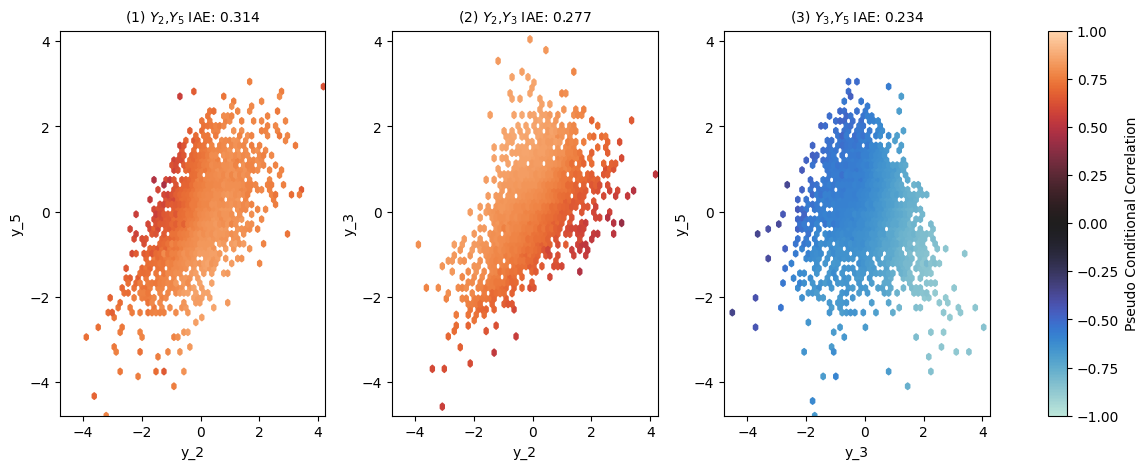

In [22]:
model.plot_conditional_dependence_structure(data=synthetic_samples,
                          dependence_metric_threshholding="iae",
                          minimum_dependence_threshold=0.2, 
                          )

In [23]:
# model.plot_densities(synthetic_samples, x_lim=[-4,4], y_lim=[-4,4])

The splines of the model, 10 transformation layer splines and 3 x 45 decorrelation layer splines can also be plotted.

In [24]:
#model.plot_splines(layer_type="transformation")

In [25]:
#model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=0)

In [26]:
#model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=1)

In [27]:
#model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=2)

### 6. Identifying the Conditional Independence Graph

We compare the true known conditional independence Graph to the one learned by the GTM. To do so we first merge the true structure table with our learned one.

In [28]:
merged_ci_tables = pd.merge(
    conditional_independence_table,
    df_true_structure_sub,
    on=["var_row", "var_col"]
)


take a look at the table and sort by some idicator such as iae.

In [29]:
#merged_ci_tables.sort_values("iae",ascending=False) 

with the spearman and pearson correlations one can see how similar the metrics are and how strongly correlated they are to the dependence.

In [30]:
merged_ci_tables.corr("spearman") #"pearson"

,index,var_row,var_col,precision_abs_mean,precision_square_mean,cond_correlation_abs_mean,cond_correlation_square_mean,kld,iae,dependence
index,1.000000,0.977008,0.642034,0.474026,0.461039,0.474026,0.459740,0.493506,0.463636,0.094475
var_row,0.977008,1.000000,0.471429,0.443974,0.435334,0.455273,0.441980,0.479199,0.445303,0.096699
var_col,0.642034,0.471429,1.000000,0.427358,0.398779,0.374188,0.363553,0.362224,0.372858,0.080582
precision_abs_mean,0.474026,0.443974,0.427358,1.000000,0.997403,0.976623,0.974026,0.968831,0.987013,0.566853
precision_square_mean,0.461039,0.435334,0.398779,0.997403,1.000000,0.980519,0.977922,0.979221,0.992208,0.582599
cond_correlation_abs_mean,0.474026,0.455273,0.374188,0.976623,0.980519,1.000000,0.998701,0.983117,0.985714,0.535361
cond_correlation_square_mean,0.459740,0.441980,0.363553,0.974026,0.977922,0.998701,1.000000,0.977922,0.981818,0.551107
kld,0.493506,0.479199,0.362224,0.968831,0.979221,0.983117,0.977922,1.000000,0.989610,0.582599
iae,0.463636,0.445303,0.372858,0.987013,0.992208,0.985714,0.981818,0.989610,1.000000,0.566853
dependence,0.094475,0.096699,0.080582,0.566853,0.582599,0.535361,0.551107,0.582599,0.566853,1.000000


however the proper metric as identifying full conditional independence is a classification task is the AUC (Area under the ROC-Curve).

In [31]:
auc_iae = roc_auc_score(merged_ci_tables["dependence"], merged_ci_tables["iae"])
auc_kld = roc_auc_score(merged_ci_tables["dependence"], merged_ci_tables["kld"])
auc_corr = roc_auc_score(merged_ci_tables["dependence"], merged_ci_tables["cond_correlation_abs_mean"])
auc_pmat = roc_auc_score(merged_ci_tables["dependence"], merged_ci_tables["precision_abs_mean"])
print("AUC IAE                    :",auc_iae)
print("AUC KLD                    :",auc_kld)
print("AUC Conditional Correlation:",auc_corr)
print("AUC Precision Matrix       :",auc_pmat)

AUC IAE                    : 0.8272727272727273
AUC KLD                    : 0.8363636363636363
AUC Conditional Correlation: 0.8090909090909091
AUC Precision Matrix       : 0.8272727272727273


We further print the ROC Curves for different metrics.

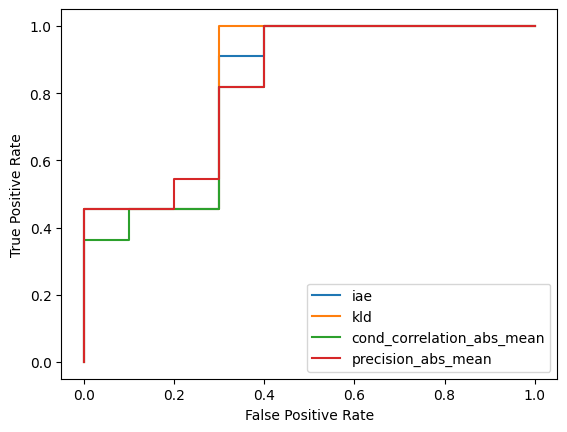

In [32]:
fpr, tpr, thresholds = roc_curve(merged_ci_tables["dependence"], merged_ci_tables["iae"])
plt.plot(fpr, tpr, label="iae")
fpr, tpr, thresholds = roc_curve(merged_ci_tables["dependence"], merged_ci_tables["kld"])
plt.plot(fpr, tpr, label="kld")
fpr, tpr, thresholds = roc_curve(merged_ci_tables["dependence"], merged_ci_tables["cond_correlation_abs_mean"])
plt.plot(fpr, tpr, label="cond_correlation_abs_mean")
fpr, tpr, thresholds = roc_curve(merged_ci_tables["dependence"], merged_ci_tables["precision_abs_mean"])
plt.plot(fpr, tpr, label="precision_abs_mean")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()